<h1 align="center">WORKOUT ACTIVITY PREDICTIVE MODELS</h1>
<h3 align="center">Regression, Classification and Clustering</h3>
<br>
<br>
<center>Practical Assignment</center>
<center>A240A0050 Big Data in Business and Industry</center>
<center>Autumn 2022</center>
<center>Authors: Thanh Tran (000285359), Nghia Nguyen (000275466)</center>

A dataset containing tracking **workout details** belonging to one person for the period from 2017 to 2020 with **3456 events** recorded with a sport tracking software named **Endomondo** has been offered for this project.

The modelling goal is to construct a **predictive model pipeline** which is capable to suggest the exercise type, time and duration of the next workout event.

In order to accomplish the modelling goal, **four alternatives** have been implemented and compared in terms of  performance, optimization, computation efficiency, degree of complexity, time efficiency... One alternative will be concluded as our **final model**.

## Modelling Plan

This project aims at generating **ONE FINAL PREDICTIVE MODEL** to predict the **exercise type, time** and **duration** of the person's **next workout event**.

- Alternative 1: Using all variables with **No movement patterns** considered => KNN classifier, Logistics Regressor, Decision Tree Classifier, Huber Regressor
- Alternative 2: Using only some variables with **No movement patterns** considered and redundant variables excluded => KNN classifier, Logistics Regressor, Decision Tree Classifier, Huber Regressor
- Alternative 3: Using all variables with filled values and **2D (latitude, longtitude) movement patterns** replicated as Image processing task => KNN classifier, Logistics Regressor, Decision Tree Classifier, Huber Regressor
- Alternative 4: Using all variables with filled values and **2D (latitude, longtitude) movement patterns** with Polar decomposition transformation => KNN classifier, Logistics Regressor, Decision Tree Classifier, Huber Regressor
- Decision on the most optimal model => **FINAL MODEL**

## Source code

* The repository to the project is made public and can be accessed from [HERE](https://github.com/Thanhtrannd/WorkoutBigDataPredictiveModel.git)
* Installation of some python packages might be needed on the local machine where the file is executed.


## Procedure

* Data Exploration (JSON Data Loading, Plotting)
* Data Pretreatment (Checking & Filling NaN values, One-hot encoding, Data Normalization)
* Feature Engineering (Data Mining, timeseries shifting, Data Transformation, Dataset generation)
* Model Construction (KNN classifier, Logistics Regressor, Decision Tree Classifier, Huber Regressor)
* Final Model Selection

## The Data

Our data has been offered in form of a separate JSON file for each workout event. The tracking data comes from 2 sources which are auto-tracking and manual input. That causes inconsistency in the raw data with a plethora of NaN values for several features.

Therefore, the data after loading has yet been ready for model construction, so several steps of exploration and pretreatment need to be carried out.

## Library Importation

Firstly, we import all need libraries.

In [117]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import re
#import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import linear_model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Math
import joblib


## Data Visualization

The visualization is constructed using the pre-processed and some feature engineered dataset that has been created after step 3 of "Feature Engineering" and stored in "./data/df_res_full.csv".

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 1:</b> Loading the Data
</div>

In [118]:
# Plot data
df_plot = pd.read_csv("data/df_res_full.csv")

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 2:</b> Pie chart of calories per exercise type

This pie chart shows how much Calories(Kcal) on average are burned in each Sport.The marks are labeled by Sport and average of Calories Kcal.
</div>

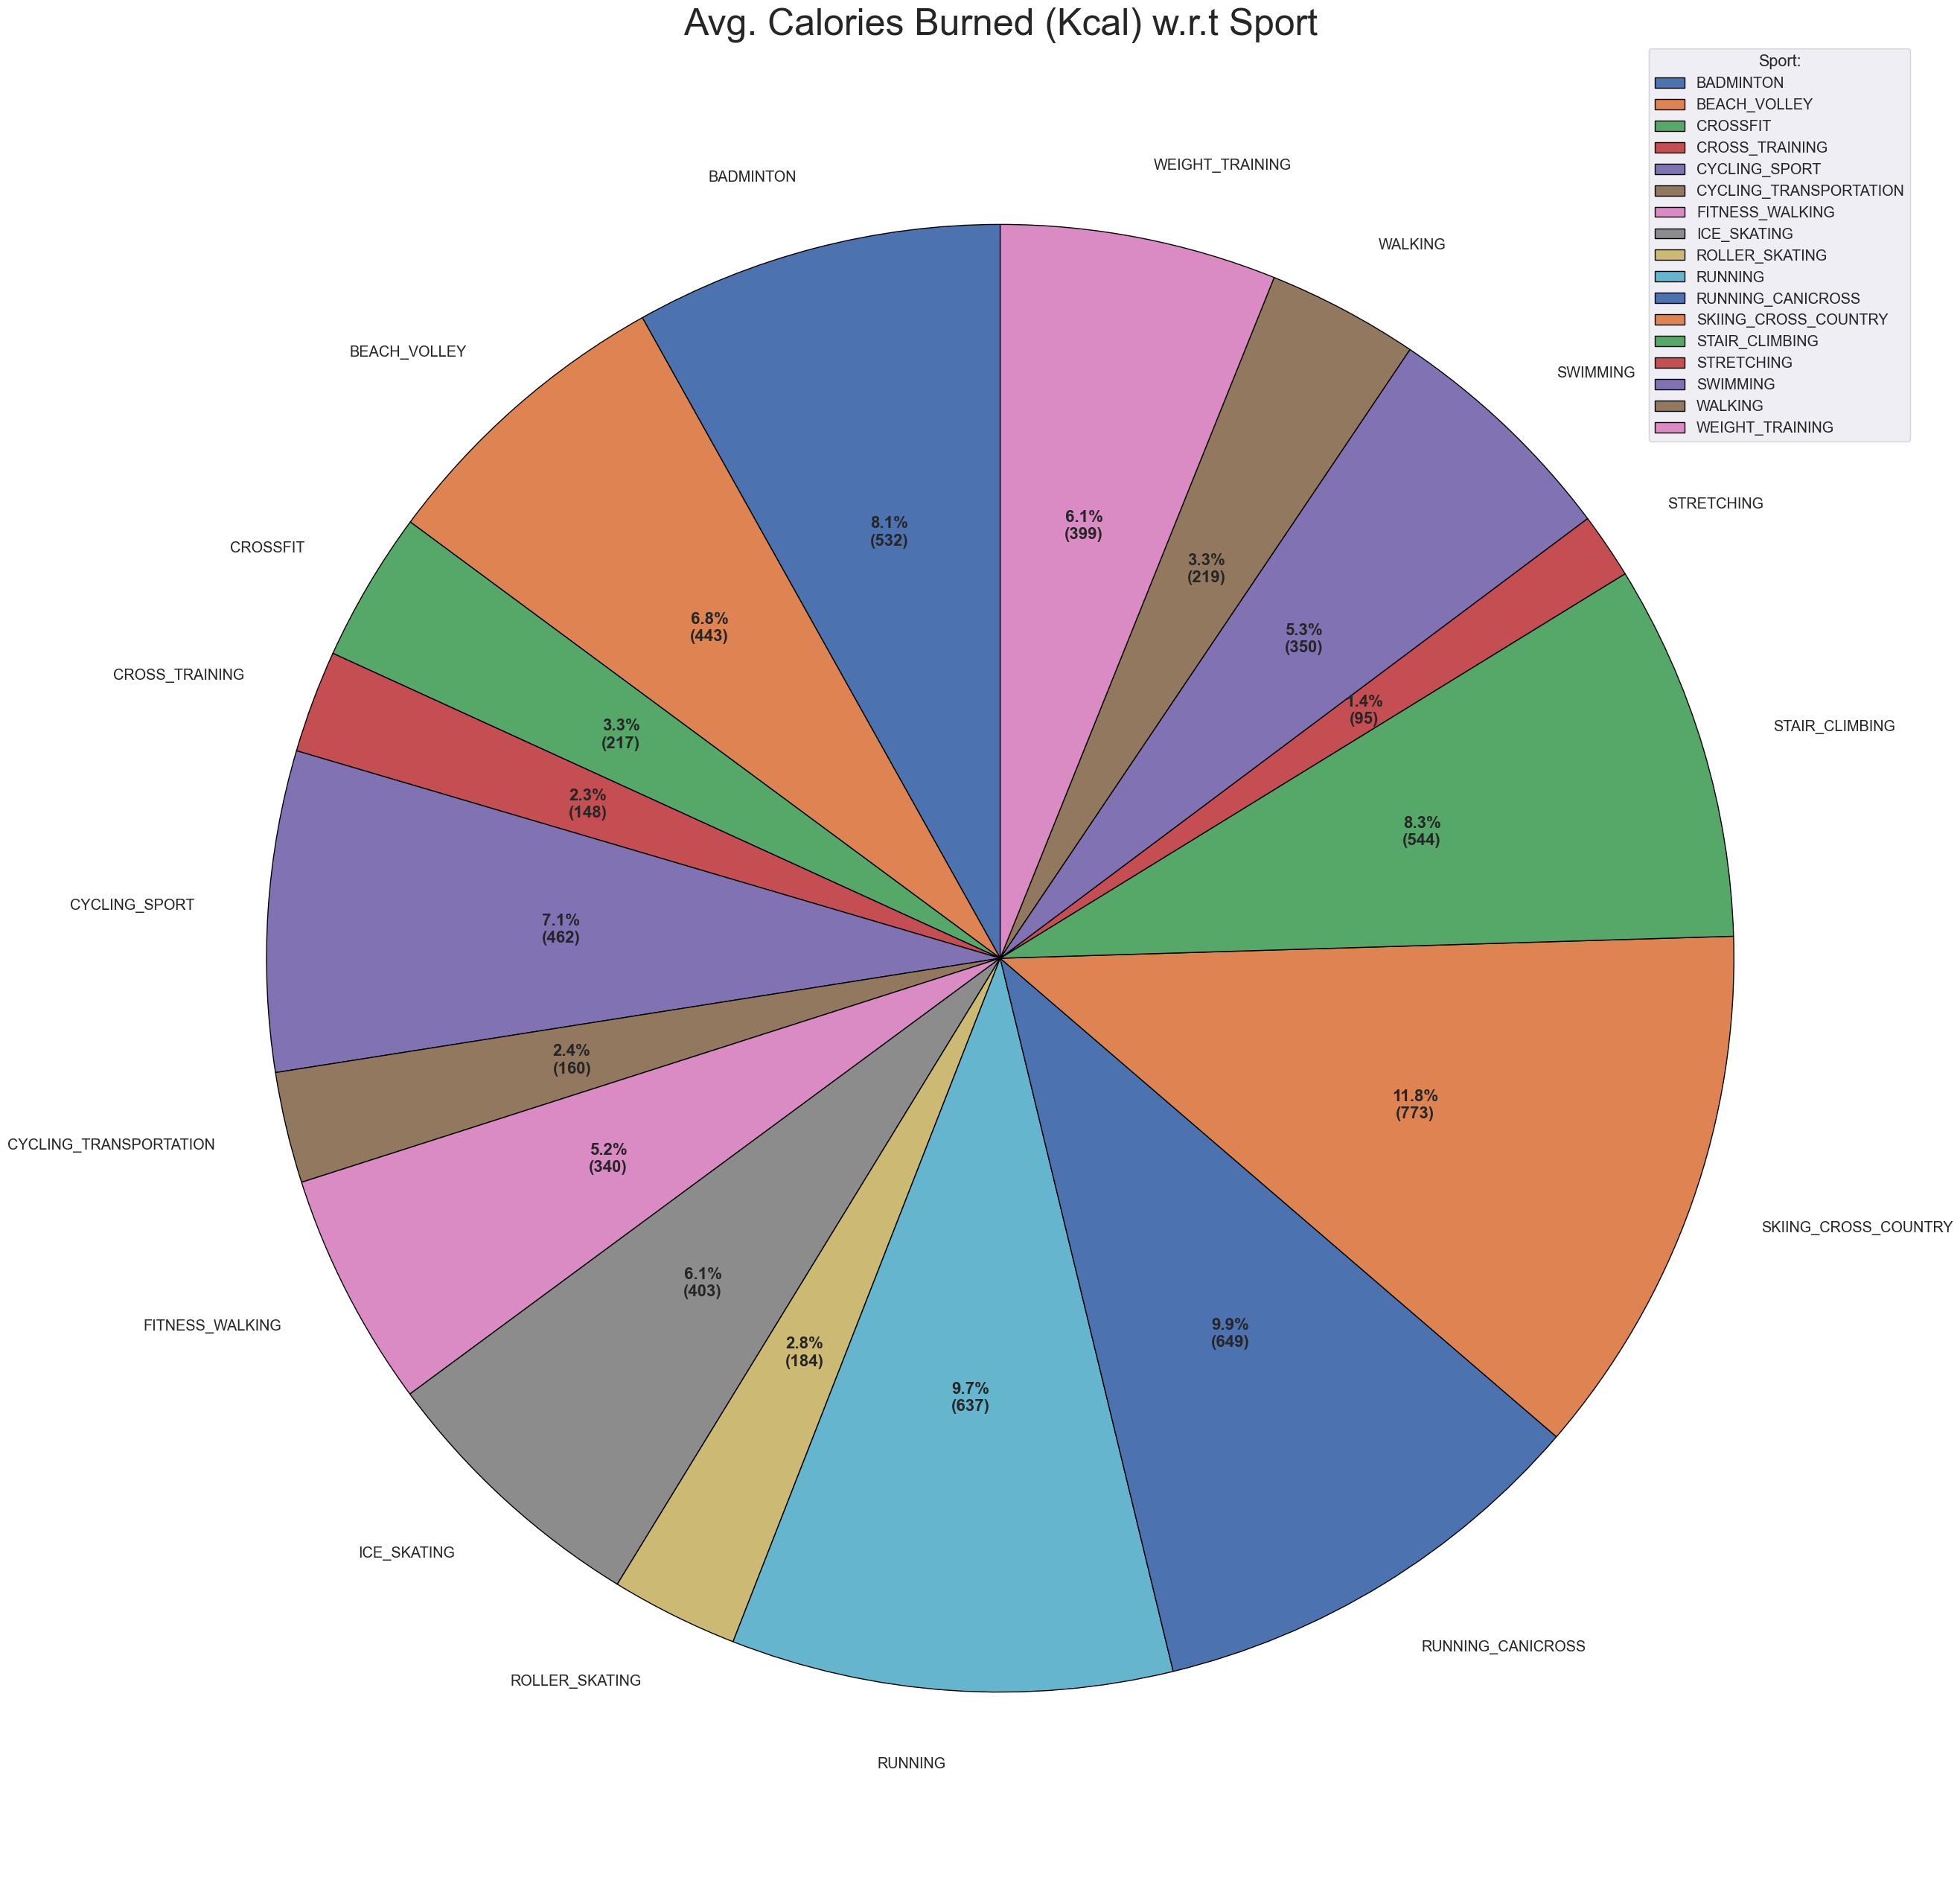

In [119]:
Sport_calories_kcal = df_plot.groupby("sport")["calories_kcal"].mean()
Sport_calories_kcal = Sport_calories_kcal.to_frame()
Sport_calories_kcal = Sport_calories_kcal.reset_index()

def pie_chart(data, label):
    
    # Wedge properties
    wp = { 'linewidth' : 1, 'edgecolor' : "black" }
    
    # Creating autocpt arguments
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.1f}%\n({v:1d})'.format(p=pct,v=val)
        return my_autopct
    
    # Creating plot
    fig, ax = plt.subplots(figsize =(36, 32))
    wedges, texts, autotexts = ax.pie(data, labels = label, startangle = 90, shadow = False, wedgeprops = wp, autopct = make_autopct(data))
    
    # Adding legend
    ax.legend(wedges, label,
              title = "Sport:",
              loc = "upper right")    
    
    plt.setp(autotexts, size = 16, weight ="bold")
    ax.set_title("Avg. Calories Burned (Kcal) w.r.t Sport", fontsize=36)
    
    # Show plot
    plt.show() 

pie_chart(Sport_calories_kcal["calories_kcal"], Sport_calories_kcal["sport"])

From the pie chart, we can observe that crpss country skiing and both kinds of running are the type of sport that burns the most calories on average and they contribute to more than a quarter of the chart.
On the other hand, it is obvious that stretching, cross_training and roller_skating are the type of sport that burns the least calories on average.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 3:</b> Bar plot - Duration, WeekDay w.r.t Sport

This stacked bar plot shows the average duration for each weekday. Color shows details about Sport.
</div>

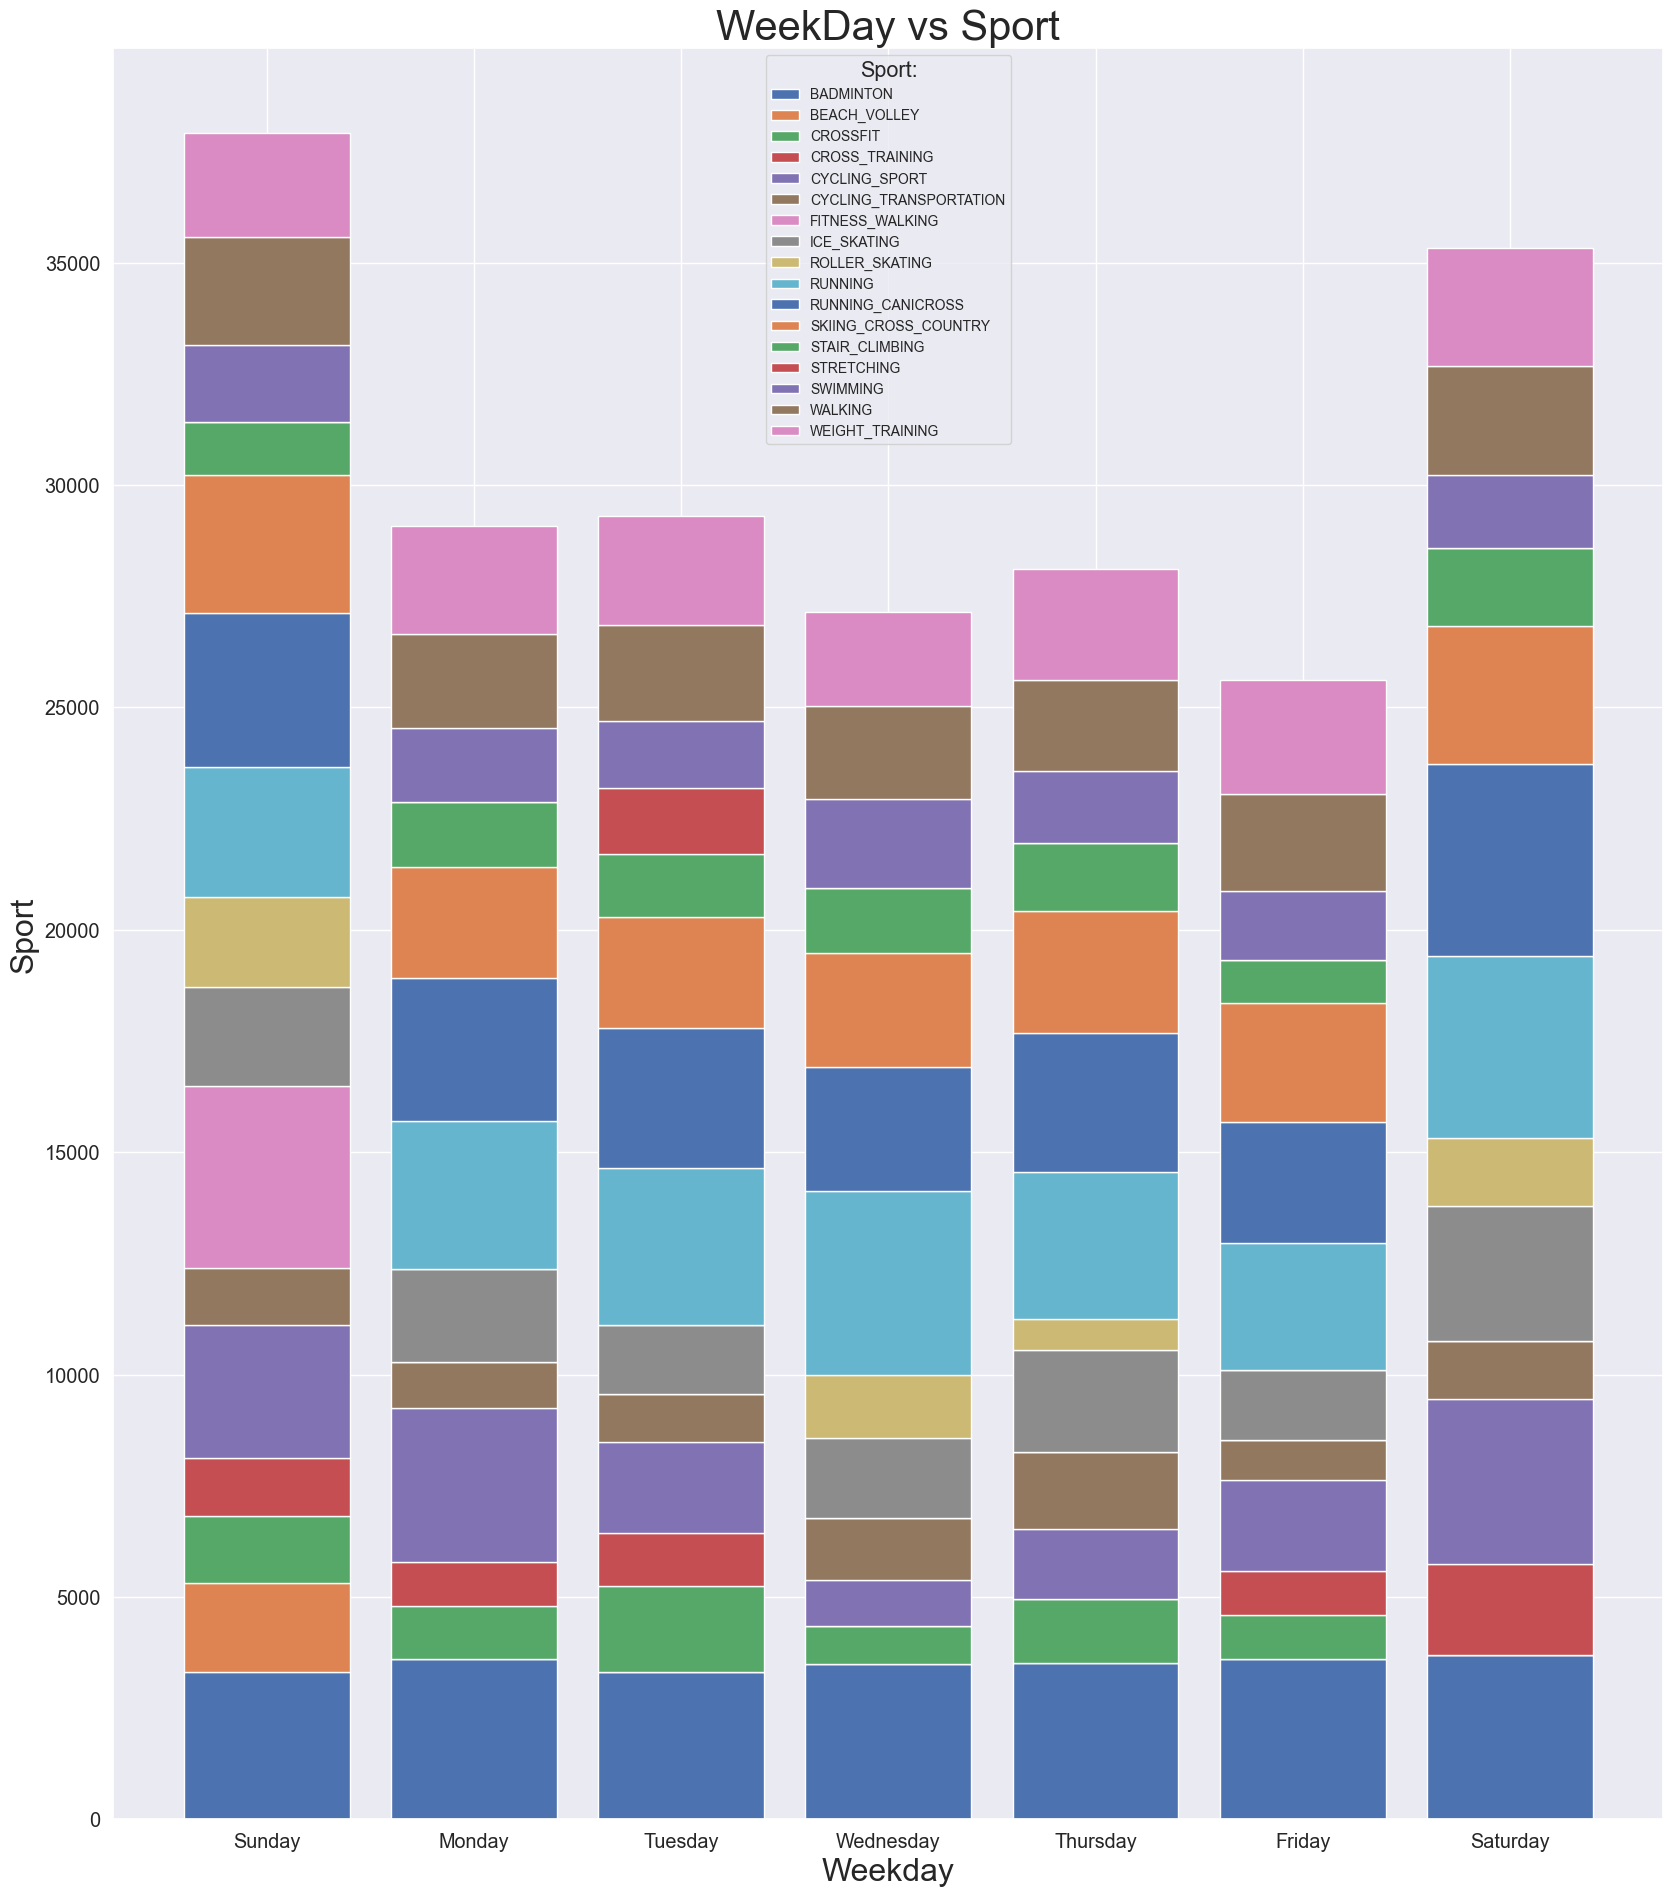

In [120]:
Sport_duration_s = df_plot.groupby(["sport","start_time_weekday_cat"])["duration_s"].mean()
Sport_duration_s = Sport_duration_s.to_frame()
Sport_duration_s = Sport_duration_s.reset_index()

cats = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sport_unique = Sport_duration_s["sport"].unique()

dict_ = {}
for i in sport_unique:
    dict_[i] = Sport_duration_s[Sport_duration_s["sport"] == i]
    dict_[i] = dict_[i].set_index('start_time_weekday_cat').reindex(cats).reset_index()
    dict_[i] = dict_[i].fillna(0)
    dict_[i] = dict_[i].to_numpy()

plt.subplots(figsize =(20, 23))

for j in sport_unique:
    if j == sport_unique[0]:
        plt.bar(dict_[j][:,0].tolist(),dict_[j][:,2])
        bottom_ = dict_[j][:,2]
    else:    
        plt.bar(dict_[j][:,0],dict_[j][:,2], bottom = bottom_)
        bottom_ = bottom_ + dict_[j][:,2] 
    
# Adding legend
plt.xlabel("Weekday", fontsize = 23)
plt.ylabel("Sport",fontsize = 23)
plt.legend(sport_unique,
          title = "Sport:",
          loc = "upper center",fontsize = 10)
plt.title("WeekDay vs Sport",fontsize = 30)
plt.show()

From the chart, we can observe that the weekend(saturday and sunday) has the most activity with saturday being the most active day of the week and all other week days have on average similar divison of sport activities with Friday being the least active among all comparatively.
Generally, it seems that running, weight_training, badminton and walking are sports contributing most everyday activities including weekends. 
In contrast, there are several activies happing only on some specific days. For instance, beach volley and fitness walking happen only on Sunday or stretch happens only on Tuesday.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 4:</b> Bar plot - Seasons w.r.t sports

This stacked bar chart shows the activity for each season. Color shows details about Sport.
</div>

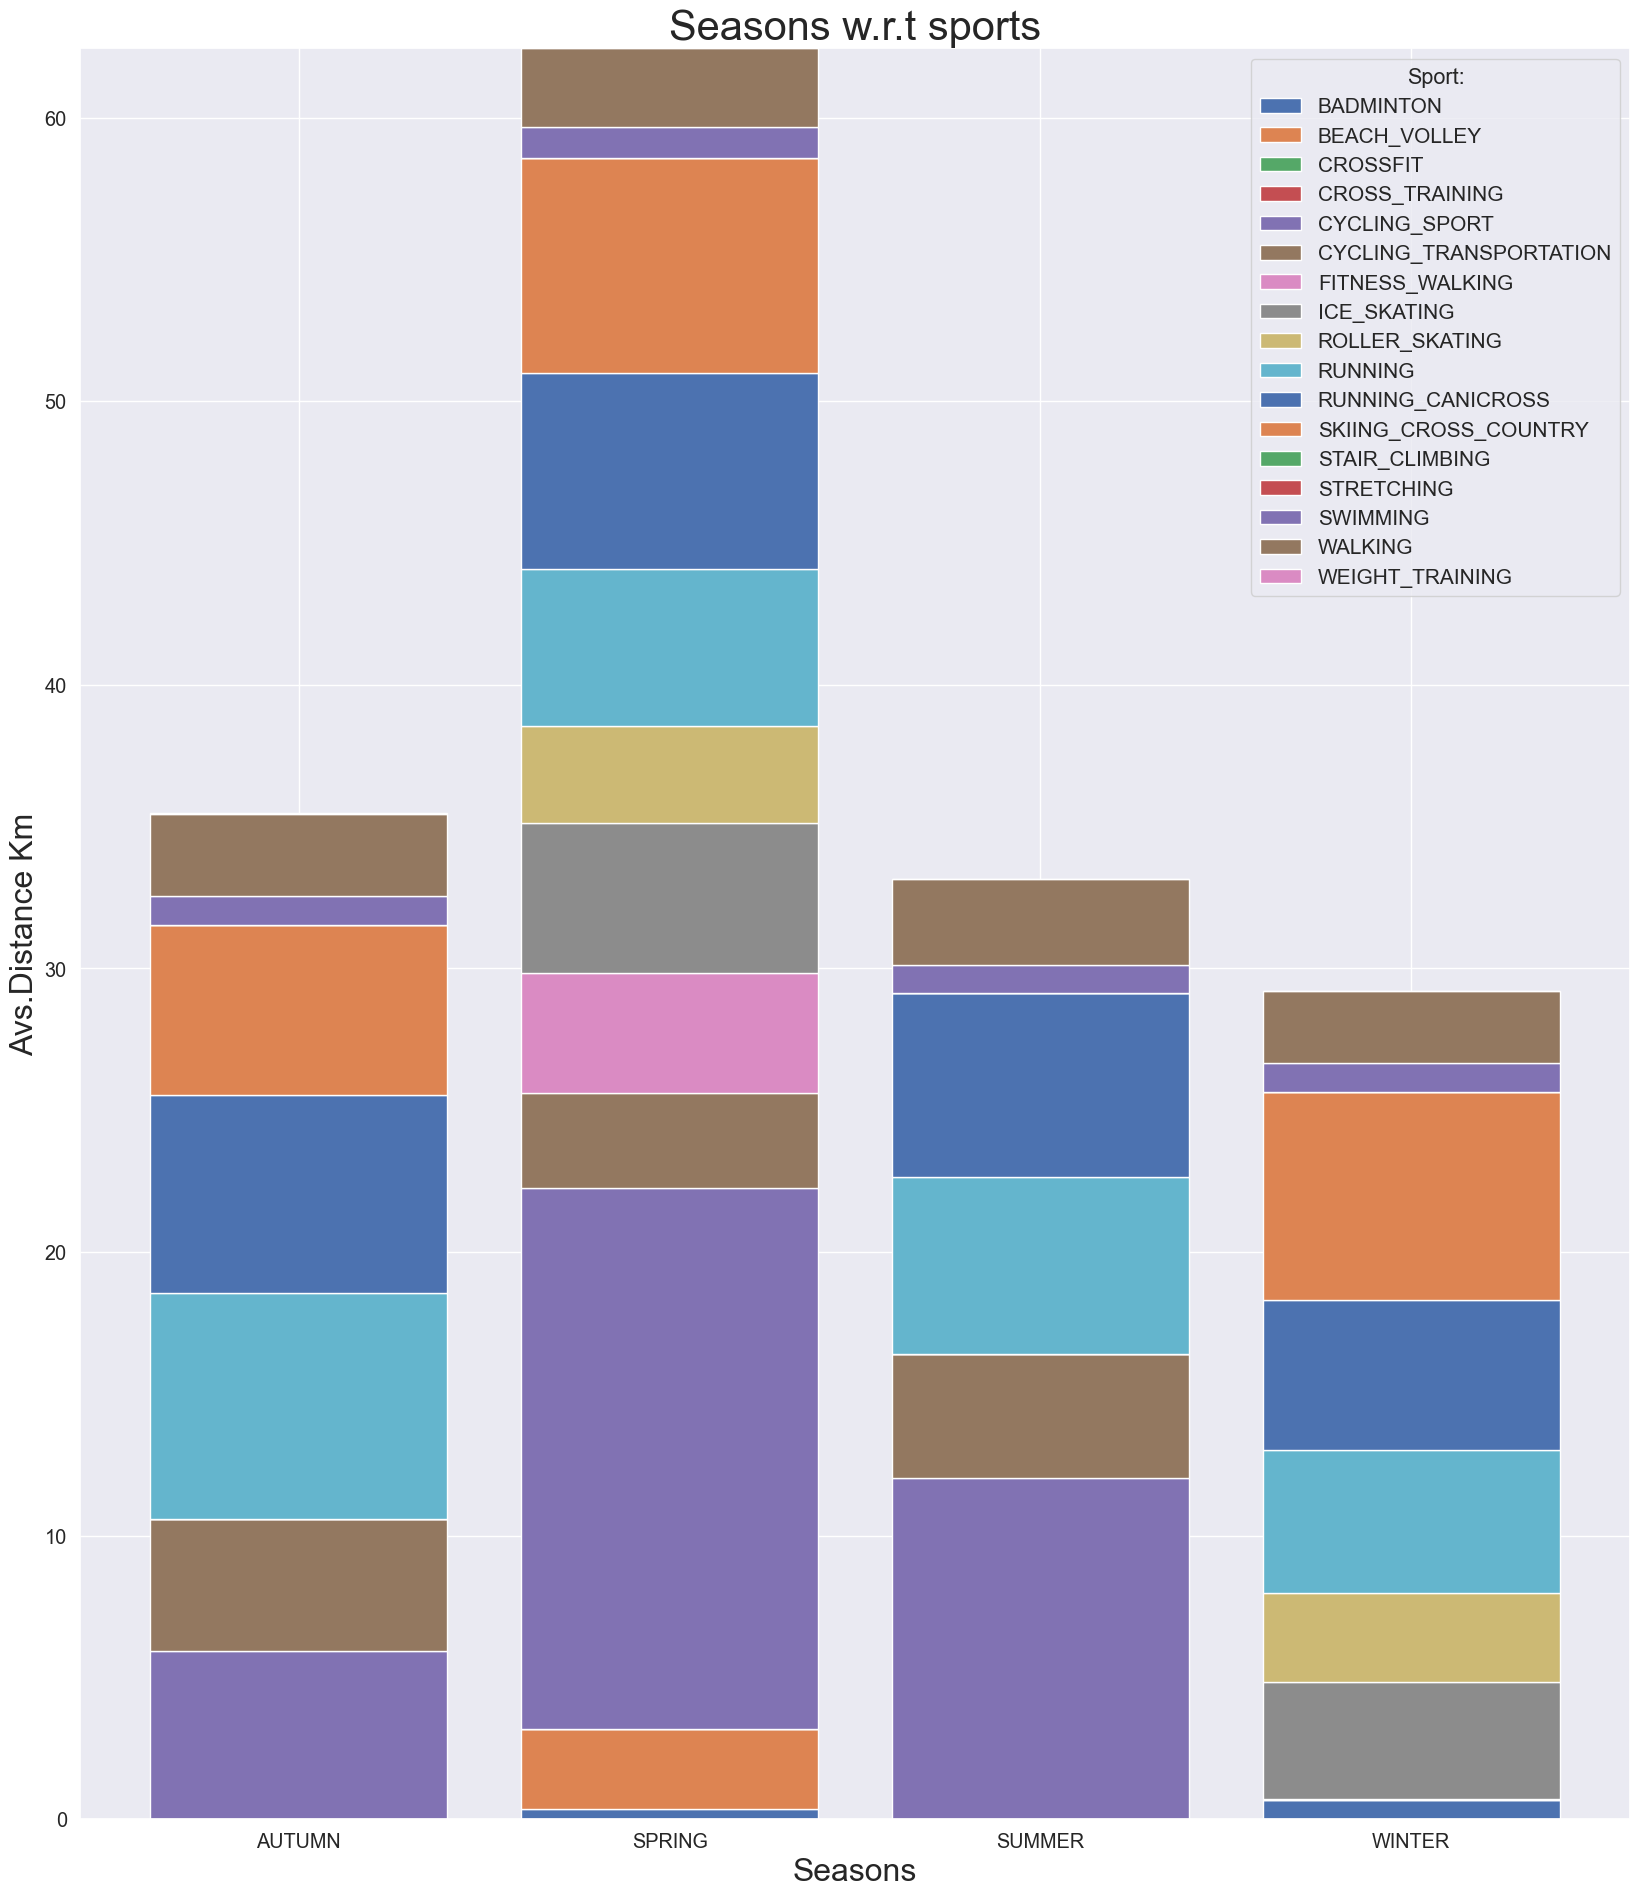

In [121]:
Sport_distance_km = df_plot.groupby(["sport","start_time_season_cat"])["distance_km"].mean()
Sport_distance_km = Sport_distance_km.to_frame()
Sport_distance_km = Sport_distance_km.reset_index()

cats = ["AUTUMN", "SPRING", "SUMMER", "WINTER" ]
sport_unique = Sport_distance_km["sport"].unique()

dict_ = {}
for i in sport_unique:
    dict_[i] = Sport_distance_km[Sport_distance_km["sport"] == i]
    dict_[i] = dict_[i].set_index('start_time_season_cat').reindex(cats).reset_index()
    dict_[i] = dict_[i].fillna(0)
    dict_[i] = dict_[i].to_numpy()
    
plt.subplots(figsize =(20, 23))

for j in sport_unique:
    if j == sport_unique[0]:
        plt.bar(dict_[j][:,0].tolist(),dict_[j][:,2])
        bottom_ = dict_[j][:,2]
    else:    
        plt.bar(dict_[j][:,0],dict_[j][:,2], bottom = bottom_)
        bottom_ = bottom_ + dict_[j][:,2]
 
# Adding legend
plt.xlabel("Seasons", fontsize = 23)
plt.ylabel("Avs.Distance Km",fontsize = 23)
plt.legend(sport_unique,
          title = "Sport:",
          loc = "upper right",fontsize = 15)
plt.title("Seasons w.r.t sports",fontsize = 30)
plt.show()


From the figure, we can observe that the most sports season according to this data is Spring and the least active as can be expected is Winter.
Autumn and Summer are both similiar in activies. Suprisingly, Summer is less active than 
Autumn and cycling sport dominates during Spring with significantly high distribution among activities. Fitness walking activity particularly happens only during Spring.


<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 5:</b> Multivariate Plots - Average duration w.r.t sport

This plot shows us Average of duration for each time hour broken down by Sport.
</div>

<Figure size 3000x500 with 0 Axes>

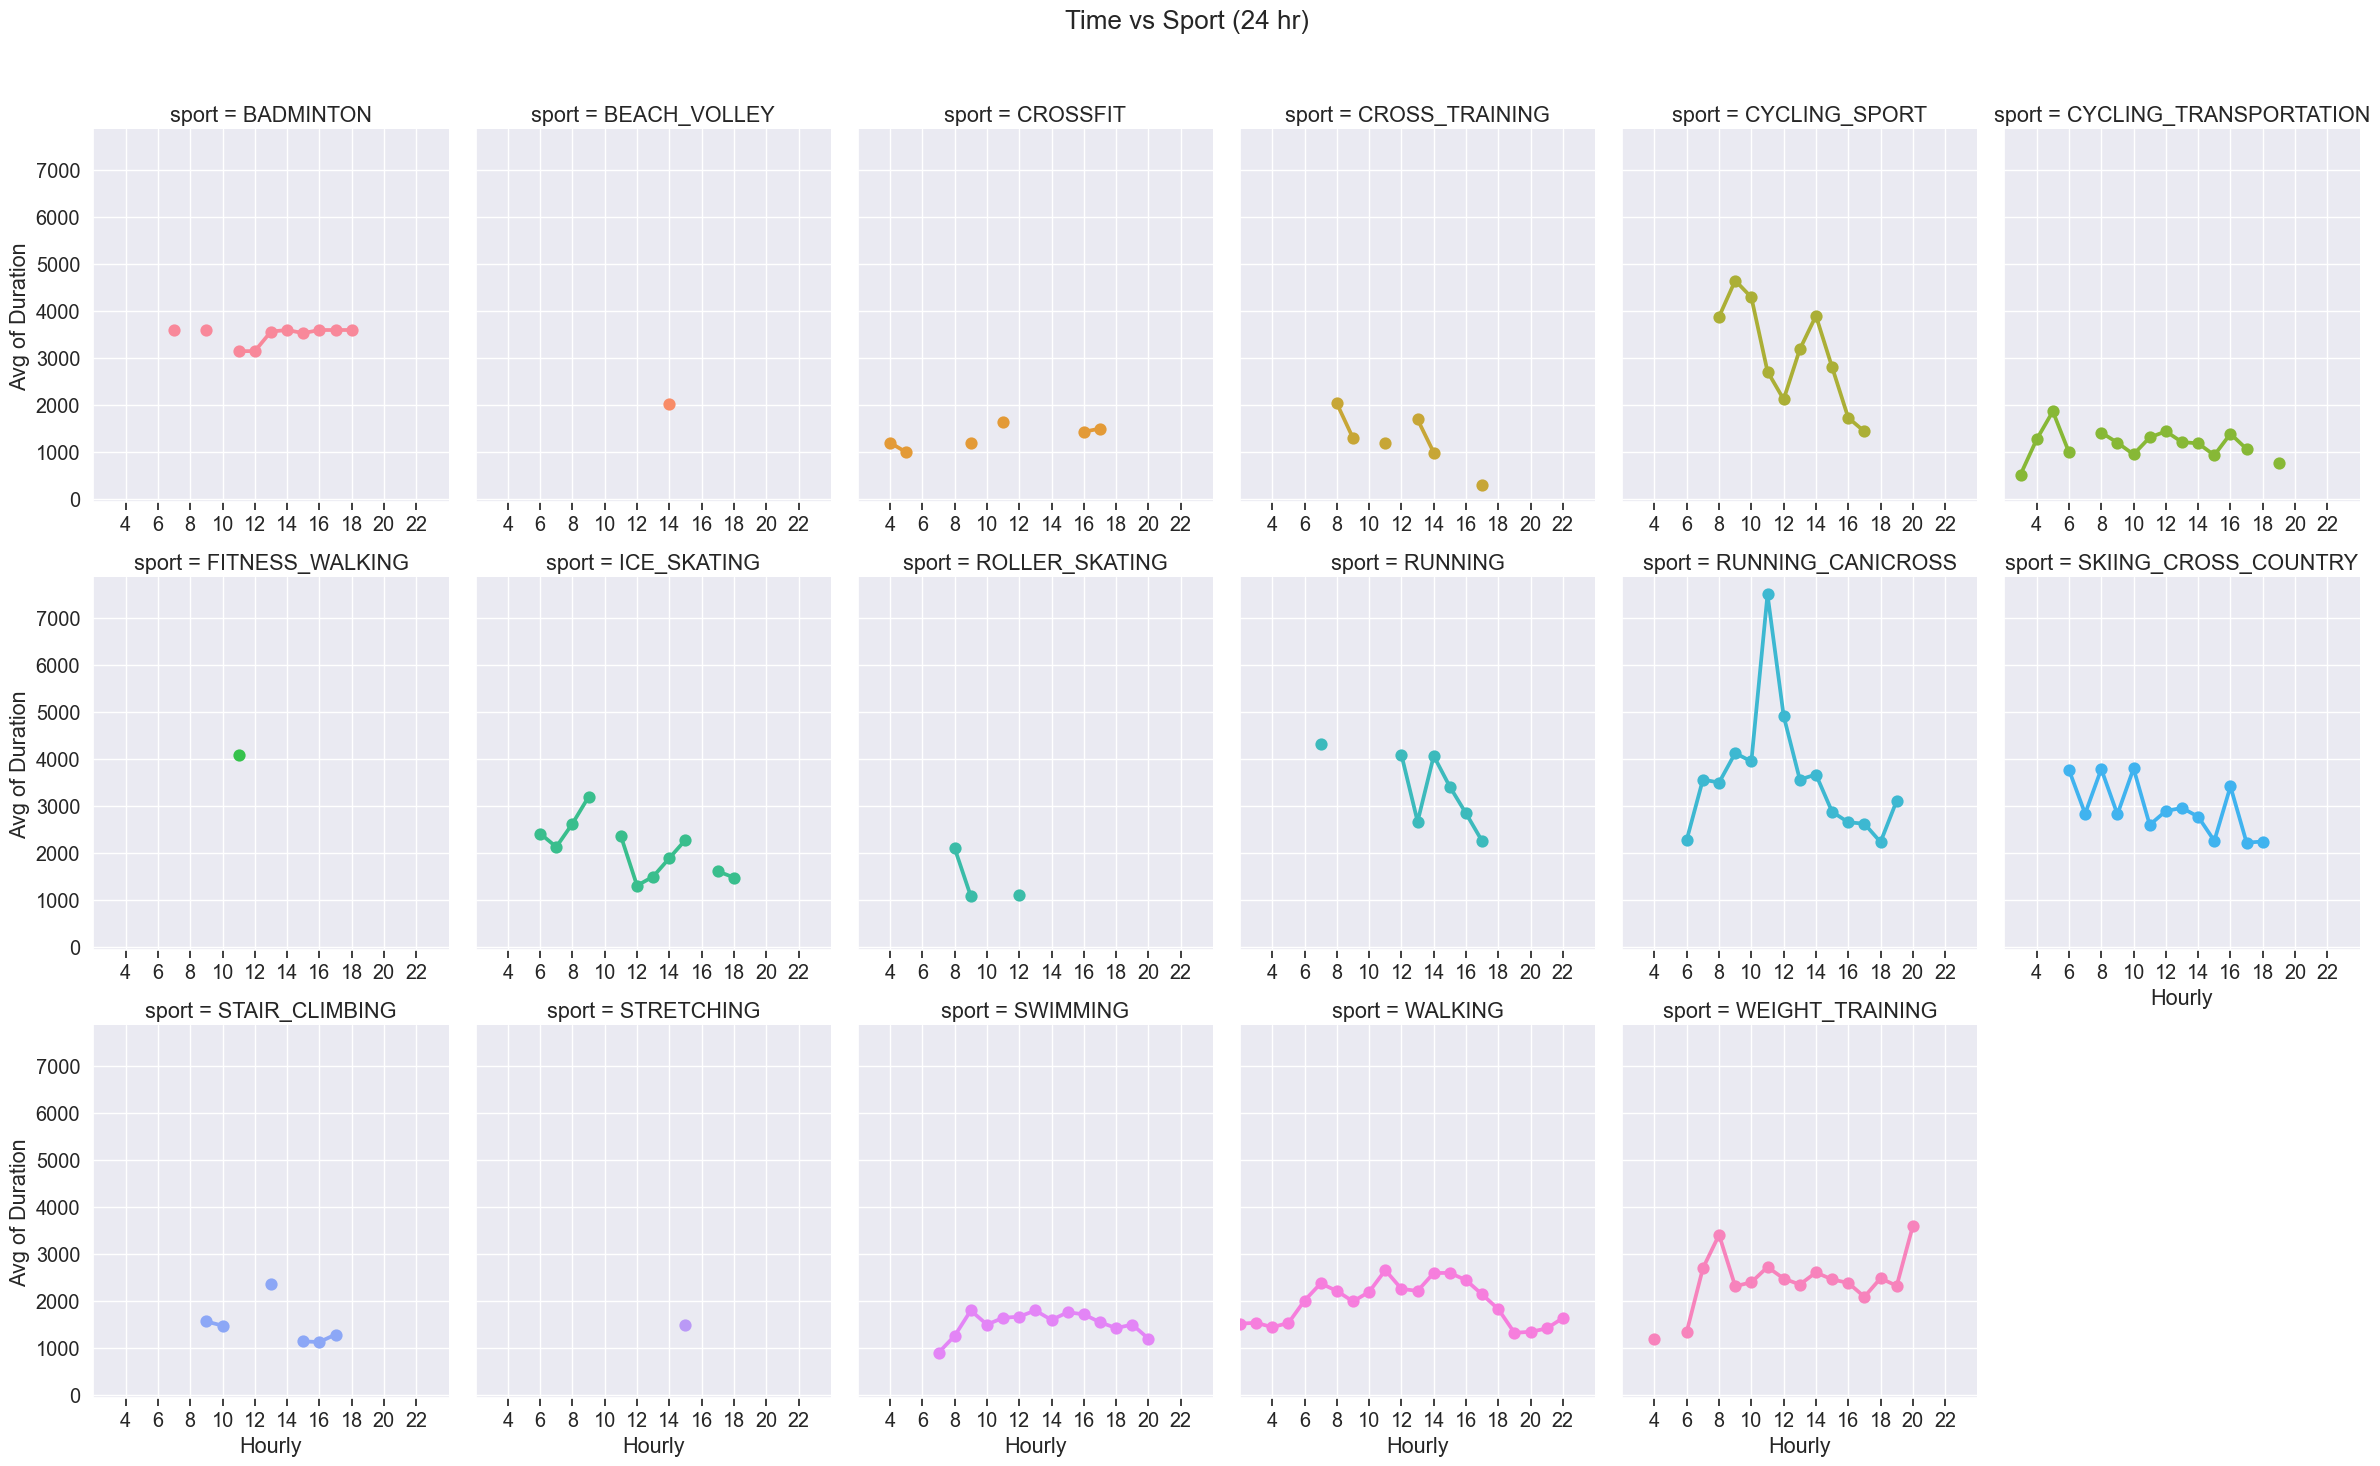

In [122]:
sns.set_style("ticks")
sns.set(font_scale=1.3)
plt.figure(figsize=(30,5))

Sport_duration_s_1 = df_plot.groupby(["sport","start_time_hour"])["duration_s"].mean()
Sport_duration_s_1 = Sport_duration_s_1.to_frame()
Sport_duration_s_1 = Sport_duration_s_1.reset_index()

cats = list(range(2,23))
sport_unique = Sport_duration_s_1["sport"].unique()

dict_ = {}
for i in sport_unique:
    dict_[i] = Sport_duration_s_1[Sport_duration_s_1["sport"] == i]
    dict_[i] = dict_[i].set_index('start_time_hour').reindex(cats).reset_index()
    dict_[i] = dict_[i].fillna(0)
    dict_[i] = dict_[i].to_numpy()

# Final solution
cat = sns.catplot(
    x="start_time_hour", 
    y="duration_s", 
    data=Sport_duration_s_1, 
    height=5,
    aspect=.8,
    kind='point',
    hue='sport', 
    col='sport', 
    col_wrap=6)

cat.fig.subplots_adjust(top=.9)

cat.fig.suptitle("Time vs Sport (24 hr)")

for ax in cat.fig.axes:
    ax.set_xlim(0,22)
    ax.set_xticks(range(2,22,2))
    ax.xaxis.tick_bottom()
    ax.grid(True, axis='both')

cat.set(xlabel="Hourly", ylabel = "Avg of Duration")


We can observe that walking is the only sport that has activity around the clock. Cycling, swimming, walking, weight_training, and cross country skiing all have similar pattern of activity from 8 AM to 6 PM approximately.
Stretching and beach volley is the sport activities  that are done for the specific time and only in the afternoon. However, fitness walking happens before noon and last roughly 1.5 hours.

## Data Exploration

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 1:</b> Loading the Data without movement details. 
 
The following code loads and transforms the dataset into a neat pandas dataframe which is saved into a csv file named `"df_res.csv"`, in which each row represents a data point and each column a feature.
The loading step can be commented out to save computational power and time consumption for reloading 3456 JSON files.
</div>

In [123]:
# Define helper function for data loading and locating to one data frame
def read_file_to_df(filename):
    """ Created by h17163,
        start and end latitude and longitude loading modified by Thanh Tran
    """
    data = pd.read_json(filename, typ='series')
    value = []
    key = []
    for j in list(range(0, data.size)):
        if list(data[j].keys())[0] != 'points':
            key.append(list(data[j].keys())[0])
            value.append(list(data[j].items())[0][1])
            dictionary = dict(zip(key, value))
       

    if list(data[j].keys())[0] == 'points':
        try:
            points = list(data[j].items())[0][1]
            start = points[0]
            end = points[-1]
            start_loc = start[0]['location']
            end_loc = end[0]['location']
            dictionary['start_lat'] = start_loc[0][0]['latitude']
            dictionary['start_long'] = start_loc[0][1]['longitude']
            dictionary['end_lat'] = end_loc[0][0]['latitude']
            dictionary['end_long'] = end_loc[0][1]['longitude']
            
        except:
            print('No detailed data recorded')
            
        
    df = pd.DataFrame(dictionary, index = [0])

    return df

#################### DATA HAS ALREADY LOADED, SO THIS PART IS COMMENTED OUT TO SAVE COMPUTATIONAL POWER AND TIME CONSUMPTION ###################

# # Load JSON data files from data folder @author: h17163
# folder = 'WorkoutData_2017to2020'
# file_list = os.listdir(folder)

# # Create Empty DataFrame @author: h17163
# df_res = pd.DataFrame()

# # Read files to a common dataframe @author: h17163
# for filename in file_list:
#     print('\n'+ filename)
#     df_process = read_file_to_df(folder + '/' + filename)
#     df_res = pd.concat([df_res, df_process], 0)

# df_res.reset_index(drop=True, inplace = True)

# # Save loaded data frame into "./data/df_res.csv"
# df_res.to_csv('data/df_res.csv', index = False)


# Read in data from the csv file and store it in the data matrix df_rex.
df_res = pd.read_csv("./data/df_res.csv")

# Display first 5 rows
print("First five datapoints:")
display(df_res.head(5))

# Acknowledge the number of variables (columns) and observations (rows)
df_res_cols = list(df_res.columns)  # columns of df_res
[df_res_nObs, df_res_nCol] = df_res.shape  # number of columns
print(f"The dataframe \"df_res\" has {df_res_nCol} variables (columns) and {df_res_nObs} observations (rows).")


First five datapoints:


sport               source           created_date  \
0          WALKING         TRACK_MOBILE  2017-01-01 08:54:23.0   
1  WEIGHT_TRAINING  INPUT_MANUAL_MOBILE  2017-01-01 15:02:04.0   
2          WALKING         TRACK_MOBILE  2017-01-01 17:47:03.0   
3          WALKING         TRACK_MOBILE  2017-01-02 08:57:23.0   
4          RUNNING         TRACK_MOBILE  2017-01-02 16:20:51.0   

              start_time               end_time  duration_s  distance_km  \
0  2017-01-01 08:53:04.0  2017-01-01 09:27:49.0        2084         2.15   
1  2017-01-01 14:01:00.0  2017-01-01 14:41:00.0        2400         0.00   
2  2017-01-01 17:46:00.0  2017-01-01 18:12:07.0        1566         1.69   
3  2017-01-02 08:55:52.0  2017-01-02 09:26:06.0        1812         2.07   
4  2017-01-02 16:13:34.0  2017-01-02 16:54:52.0        2444         5.87   

   calories_kcal  altitude_min_m  altitude_max_m  speed_avg_kmh  \
0        171.651           145.5           198.0       3.714012   
1        393.333             NaN             NaN       0.000000   
2        132.168           126.5           174.5       3.885057   
3        157.828            81.0           201.0       4.112583   
4        591.404            97.5           159.5       8.646481   

   speed_max_kmh  ascend_m  descend_m  start_lat  start_long    end_lat  \
0            6.3      78.0       77.0  64.231747   27.729461  64.231976   
1            NaN       NaN        NaN        NaN         NaN        NaN   
2            5.4      28.0       34.5  64.231885   27.729526  64.231758   
3            6.3     119.5       47.5  64.231953   27.729530  64.231829   
4           12.6     137.5      140.5  64.231735   27.729492  64.232033   

    end_long  hydration_l  
0  27.729551          NaN  
1        NaN          NaN  
2  27.729491          NaN  
3  27.729530          NaN  
4  27.729567          NaN

The dataframe "df_res" has 19 variables (columns) and 3456 observations (rows).


<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 2:</b> Loading the Data with movement details
</div>

This step loads location points with movement details and save each event's data into separate .csv file in `data/points/original/`  with the same name as the original JSON file.

In [124]:
def read_file_get_points(filename):
    data = pd.read_json(filename, typ='series')    
    np_points = np.empty((0,2))
    for j in list(range(0, data.size)):
        if list(data[j].keys())[0] == 'points':            
            try:
                points = list(data[j].items())[0][1]
                for p in points:
                    ind = p[0]['location']
                    latitude = ind[0][0]['latitude']
                    longitude = ind[0][1]['longitude']
                    np_points = np.append(np_points, np.array([[latitude,longitude]]), axis=0)
            except:
                pass
    return np_points

folder = 'WorkoutData_2017to2020'
file_list = os.listdir(folder)

for filename in file_list:
    filename_ = filename
    filename_ = filename_.split('.')[0]
    np_points = read_file_get_points(folder + '/' + filename)
    np_points_filename = f'data/points/original/{filename_}.csv'
    np.savetxt(np_points_filename, np_points, delimiter=',')

print("Details on movement per event are stored in each .csv file in ./data/points/original/")
print("Those files are used for generating additional dataset for alternative 3 and 4.")

Details on movement per event are stored in each .csv file in ./data/points/original/
Those files are used for generating additional dataset for alternative 3 and 4.


## Data Pretreatment

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 1:</b> Converting variables to datetime data type and sort dataset ascending by "start_time"
 
To ease the computation on time-related variables, they are converted to datetime format.
</div>

In [125]:
# Convert time variable to datetime format
df_res["created_date"] = pd.to_datetime(df_res["created_date"])
df_res["start_time"] = pd.to_datetime(df_res["start_time"])
df_res["end_time"] = pd.to_datetime(df_res["end_time"])

# Sort dataset by variable "start_time" and reset index
df_res.sort_values(by="start_time", ascending = True, inplace = True)
df_res.reset_index(drop = True, inplace = True)

df_res.to_csv("data/df_res_sorted.csv", index = False)

# Convert object-typed variables to string
df_res["sport"] = df_res["sport"].astype('string')
df_res["source"] = df_res["source"].astype('string')

# Display first 5 rows
print("First five datapoints:")
display(df_res.head(5))
df_res.info()

First five datapoints:


sport               source        created_date  \
0          WALKING         TRACK_MOBILE 2017-01-01 08:54:23   
1  WEIGHT_TRAINING  INPUT_MANUAL_MOBILE 2017-01-01 15:02:04   
2          WALKING         TRACK_MOBILE 2017-01-01 17:47:03   
3          WALKING         TRACK_MOBILE 2017-01-02 08:57:23   
4          RUNNING         TRACK_MOBILE 2017-01-02 16:20:51   

           start_time            end_time  duration_s  distance_km  \
0 2017-01-01 08:53:04 2017-01-01 09:27:49        2084         2.15   
1 2017-01-01 14:01:00 2017-01-01 14:41:00        2400         0.00   
2 2017-01-01 17:46:00 2017-01-01 18:12:07        1566         1.69   
3 2017-01-02 08:55:52 2017-01-02 09:26:06        1812         2.07   
4 2017-01-02 16:13:34 2017-01-02 16:54:52        2444         5.87   

   calories_kcal  altitude_min_m  altitude_max_m  speed_avg_kmh  \
0        171.651           145.5           198.0       3.714012   
1        393.333             NaN             NaN       0.000000   
2        132.168           126.5           174.5       3.885057   
3        157.828            81.0           201.0       4.112583   
4        591.404            97.5           159.5       8.646481   

   speed_max_kmh  ascend_m  descend_m  start_lat  start_long    end_lat  \
0            6.3      78.0       77.0  64.231747   27.729461  64.231976   
1            NaN       NaN        NaN        NaN         NaN        NaN   
2            5.4      28.0       34.5  64.231885   27.729526  64.231758   
3            6.3     119.5       47.5  64.231953   27.729530  64.231829   
4           12.6     137.5      140.5  64.231735   27.729492  64.232033   

    end_long  hydration_l  
0  27.729551          NaN  
1        NaN          NaN  
2  27.729491          NaN  
3  27.729530          NaN  
4  27.729567          NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3456 entries, 0 to 3455
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sport           3456 non-null   string        
 1   source          3456 non-null   string        
 2   created_date    3456 non-null   datetime64[ns]
 3   start_time      3456 non-null   datetime64[ns]
 4   end_time        3456 non-null   datetime64[ns]
 5   duration_s      3456 non-null   int64         
 6   distance_km     3456 non-null   float64       
 7   calories_kcal   3455 non-null   float64       
 8   altitude_min_m  3048 non-null   float64       
 9   altitude_max_m  3048 non-null   float64       
 10  speed_avg_kmh   3456 non-null   float64       
 11  speed_max_kmh   3043 non-null   float64       
 12  ascend_m        3045 non-null   float64       
 13  descend_m       3045 non-null   float64       
 14  start_lat       3033 non-null   float64       
 15  star

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 2:</b> Checking NaN
 
The code snippet below checks the number of NaN values of each feature
</div>

In [126]:
# Count NaN values of each feature
print("NaN Counting...")
print("<Feature>: <Number of NaN values>")
df_res_nNaN = dict()  # Initialize list of number of NaN values in corresponding columns
df_res_cols = list(df_res.columns)  # columns of df_res
[df_res_nObs, df_res_nCol] = df_res.shape

for col in df_res_cols:
    df_res_nNaN[col] = df_res[col].isnull().sum()
    print(f"{col}: {df_res_nNaN[col]}")

NaN Counting...
<Feature>: <Number of NaN values>
sport: 0
source: 0
created_date: 0
start_time: 0
end_time: 0
duration_s: 0
distance_km: 0
calories_kcal: 1
altitude_min_m: 408
altitude_max_m: 408
speed_avg_kmh: 0
speed_max_kmh: 413
ascend_m: 411
descend_m: 411
start_lat: 423
start_long: 423
end_lat: 423
end_long: 423
hydration_l: 922


<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 3:</b> Fill NaN for variable "calories_kcal"
</div>

There is **only ONE NaN** value in the `"calories_kcal"` column and that NaN can easily be filled based on the average calorie burn rate of the corresponding exercise type. Therefore, the below code snippet aims at filling that NaN of that observation.

In [127]:
# Find exercise type of the observation having that NaN
obs_idx = df_res.loc[pd.isna(df_res["calories_kcal"]), :].index
obs_idx = obs_idx.tolist()[0]
obs_idx_sport = df_res.iloc[obs_idx]['sport']
print(f"The observation {obs_idx} having NaN value in the \"calories_kcal\" column has exercise type being \"{obs_idx_sport}\".")

# Calculate calorie burn rate of that sport
df_res_NaNsport = df_res[df_res['sport']==obs_idx_sport][["sport", "calories_kcal", "duration_s"]]
df_res_NaNsport['calorie burn rate'] = df_res_NaNsport['calories_kcal'] / df_res_NaNsport['duration_s']
mean_walking_calorie_burn_rate = df_res_NaNsport['calorie burn rate'].mean()
display(df_res_NaNsport.head(5))

# Fill NaN
mean_NaNsport_calorie_burn_rate = df_res_NaNsport['calorie burn rate'].mean()
df_res.loc[obs_idx, "calories_kcal"] = mean_NaNsport_calorie_burn_rate
print(f"The average calorie burn rate of {obs_idx_sport} is {mean_NaNsport_calorie_burn_rate}, which replaces the NaN value in of the observation {obs_idx}.")

# Check NaN existence
nNaN = df_res["calories_kcal"].isnull().sum()
print(f"The number of NaN values in column \"calories_kcal\" is {nNaN}")

The observation 3150 having NaN value in the "calories_kcal" column has exercise type being "WALKING".


sport  calories_kcal  duration_s  calorie burn rate
0  WALKING        171.651        2084           0.082366
2  WALKING        132.168        1566           0.084398
3  WALKING        157.828        1812           0.087102
5  WALKING        167.024        1963           0.085086
7  WALKING        178.907        1927           0.092842

The average calorie burn rate of WALKING is 0.10086510083945138, which replaces the NaN value in of the observation 3150.
The number of NaN values in column "calories_kcal" is 0


<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 4:</b> Fill NaN for location variables "start_lat", "start_long", "end_lat" and "end_long"
</div>

Filling the **other NaN** is a little **trickier** and might involve **some assumptions**.
We assume that the person cannot be too far away from the location he/she was tracked for the most previous or following event. Therefore, 4 variables `"start_lat", "start_long", "end_lat" and "end_long"`, each of which has **423 NaN values**, will **be filled** by replicating the values of either the **most previous or the following observation**'s corresponding variables' value depending on which observation ever has the **least time difference** of the `"start_time"` compared to the observation of interest.

In [128]:
# Define a list of location variables
loc_vars = ["start_lat", "start_long", "end_lat", "end_long"]
for var in loc_vars:
    # Find indices of observations with NaN values
    obs_idx_ls = df_res.loc[pd.isna(df_res[var]), :].index.tolist()
    for obs_idx in obs_idx_ls:
        # If this is the first event, consider only the following event
        if obs_idx == 0:
            fol_i = 1
            while True:
                fol_i_var = df_res.loc[obs_idx + fol_i, var]
                if not pd.isna(fol_i_var):
                    break
                fol_i += 1
            
            df_res.loc[obs_idx, var] = df_res.loc[obs_idx + fol_i, var]

        # If this is the last event, consider only the previous event
        elif obs_idx == df_res_nObs - 1:
            pre_i = 1
            while True:
                pre_i_var = df_res.loc[obs_idx - pre_i, var]
                if not pd.isna(pre_i_var):
                    break
                pre_i += 1
            
            df_res.loc[obs_idx, var] = df_res.loc[obs_idx - pre_i, var]
        
        else:            
            # Check if previous or following is also NaN then increment the index
            pre_i = 1
            while True:
                pre_i_var = df_res.loc[obs_idx - pre_i, var]
                if not pd.isna(pre_i_var):
                    break
                pre_i += 1

            fol_i = 1
            while True:
                fol_i_var = df_res.loc[obs_idx + fol_i, var]
                if not pd.isna(fol_i_var):
                    break
                fol_i += 1

            # Compute time difference between the start time values
            pre_diff = (df_res.loc[obs_idx, "start_time"] - df_res.loc[obs_idx - pre_i, "start_time"]).total_seconds()
            fol_diff = (df_res.loc[obs_idx + fol_i, "start_time"] - df_res.loc[obs_idx, "start_time"]).total_seconds()
            # Fill NaN with the considered observation having less time difference
            if pre_diff < fol_diff:
                df_res.loc[obs_idx, var] = df_res.loc[obs_idx - pre_i, var]
            else:
                df_res.loc[obs_idx, var] = df_res.loc[obs_idx + fol_i, var]

# Display first 5 rows
print("First five datapoints:")
display(df_res.head(5))

# Check NaN existence
for var in loc_vars:
    nNaN = df_res[var].isnull().sum()
    print(f"The number of NaN values in column {var} is {nNaN}")

First five datapoints:


sport               source        created_date  \
0          WALKING         TRACK_MOBILE 2017-01-01 08:54:23   
1  WEIGHT_TRAINING  INPUT_MANUAL_MOBILE 2017-01-01 15:02:04   
2          WALKING         TRACK_MOBILE 2017-01-01 17:47:03   
3          WALKING         TRACK_MOBILE 2017-01-02 08:57:23   
4          RUNNING         TRACK_MOBILE 2017-01-02 16:20:51   

           start_time            end_time  duration_s  distance_km  \
0 2017-01-01 08:53:04 2017-01-01 09:27:49        2084         2.15   
1 2017-01-01 14:01:00 2017-01-01 14:41:00        2400         0.00   
2 2017-01-01 17:46:00 2017-01-01 18:12:07        1566         1.69   
3 2017-01-02 08:55:52 2017-01-02 09:26:06        1812         2.07   
4 2017-01-02 16:13:34 2017-01-02 16:54:52        2444         5.87   

   calories_kcal  altitude_min_m  altitude_max_m  speed_avg_kmh  \
0        171.651           145.5           198.0       3.714012   
1        393.333             NaN             NaN       0.000000   
2        132.168           126.5           174.5       3.885057   
3        157.828            81.0           201.0       4.112583   
4        591.404            97.5           159.5       8.646481   

   speed_max_kmh  ascend_m  descend_m  start_lat  start_long    end_lat  \
0            6.3      78.0       77.0  64.231747   27.729461  64.231976   
1            NaN       NaN        NaN  64.231885   27.729526  64.231758   
2            5.4      28.0       34.5  64.231885   27.729526  64.231758   
3            6.3     119.5       47.5  64.231953   27.729530  64.231829   
4           12.6     137.5      140.5  64.231735   27.729492  64.232033   

    end_long  hydration_l  
0  27.729551          NaN  
1  27.729491          NaN  
2  27.729491          NaN  
3  27.729530          NaN  
4  27.729567          NaN

The number of NaN values in column start_lat is 0
The number of NaN values in column start_long is 0
The number of NaN values in column end_lat is 0
The number of NaN values in column end_long is 0


<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 5:</b> Fill  NaN of variable "speed_max_kmh"
</div>

Due to varible `"speed_max_kmh"` having missing values and no patterns found, the procedure to fill data for this variables follow **multiple rules of logic** and we try to keep it aligned with the most intuitive logic.

In [129]:
# Remove impossibly high speed observation
print("Speed-related outlier removal ...")
df_res_sorted_speed = df_res[["sport", "speed_avg_kmh", "speed_max_kmh"]].sort_values(by = "speed_max_kmh", ascending = False)
display(df_res_sorted_speed.head(20))

df_res_groupby_sport = df_res.groupby("sport")
sport_idx = df_res_groupby_sport.indices
removed_obs = []
for sport in sport_idx:
    if sport == "CYCLING_SPORT":
        fastest_speed = 296.009
    elif sport == "ICE_SKATING":
        fastest_speed = 103
    elif sport in ["RUNNING", "RUNNING_CANICROSS", "WALKING", "SKIING_CROSS_COUNTRY"]:
        fastest_speed = 44.72
    else:
        continue
    
    idx_ls = sport_idx[sport]
    for i in idx_ls:
        if df_res.loc[i, "speed_max_kmh"] > fastest_speed:
            df_res = df_res.drop([i], axis = 0)
            removed_obs.append(i)

df_res.reset_index(drop = True, inplace = True)

print("Because of the fact that in reality the fastest ever recorded speed of \"CYCLING\" is 296.009 km/h, any observation having speed above that threshold is removed.")
print("Because of the fact that in reality the fastest ever recorded speed of \"ICE SKATING\" is 103 km/h, any observation having speed above that threshold is removed.")
print("Because of the fact that in reality the fastest ever recorded speed of \"RUNNING\" is 44.72km/h, any observation having speed above that threshold is removed.")
print(f"List of removed observation (total {len(removed_obs)} observations): {removed_obs}")

# Compute mean and max value per sport of variable "speed_avg_kmh"
df_res_groupby_sport = df_res.groupby("sport")
df_res_groupby_sport_speed_avg_mean = df_res_groupby_sport.agg({'speed_avg_kmh': 'mean'})
df_res_groupby_sport_speed_avg_max = df_res_groupby_sport.agg({'speed_avg_kmh': 'max'})
df_res_groupby_sport_speed_avg = pd.concat([df_res_groupby_sport_speed_avg_mean, df_res_groupby_sport_speed_avg_max], keys = ['sport', 'sport'], axis = 1)
df_res_groupby_sport_speed_avg.columns = ["mean_speed_avg_kmh", "max_speed_avg_kmh"]

# Compute mean and max value per sport of variable "speed_max_kmh"
df_res_groupby_sport_speed_max_mean = df_res_groupby_sport.agg({'speed_max_kmh': 'mean'})
df_res_groupby_sport_speed_max_max = df_res_groupby_sport.agg({'speed_max_kmh': 'max'})
df_res_groupby_sport_speed_max = pd.concat([df_res_groupby_sport_speed_max_mean, df_res_groupby_sport_speed_max_max], keys = ['sport', 'sport'], axis = 1)
df_res_groupby_sport_speed_max.columns = ["mean_speed_max_kmh", "max_speed_max_kmh"]

# Concatenate the two above dataframe with aggregate speed
df_res_groupby_sport_speed = pd.concat([df_res_groupby_sport_speed_avg, df_res_groupby_sport_speed_max], keys = ['sport', 'sport'], axis = 1)
df_res_groupby_sport_speed.columns = ["mean_speed_avg_kmh", "max_speed_avg_kmh", "mean_speed_max_kmh", "max_speed_max_kmh"]
display(df_res_groupby_sport_speed)

# Fill NaN per sport
epsilon = 0.00000000001
sport_idx = df_res_groupby_sport.indices
for sport in sport_idx:
    sport_mean_speed_avg = df_res_groupby_sport_speed.loc[sport, "mean_speed_avg_kmh"]
    sport_max_speed_avg = df_res_groupby_sport_speed.loc[sport, "max_speed_avg_kmh"]
    sport_mean_speed_max = df_res_groupby_sport_speed.loc[sport, "mean_speed_max_kmh"]
    sport_max_speed_max = df_res_groupby_sport_speed.loc[sport, "max_speed_max_kmh"]

    if pd.isna(sport_mean_speed_max) and pd.isna(sport_max_speed_max):
        replace_value = sport_max_speed_avg
    else:
        replace_value = sport_mean_speed_max 
    
    idx_ls = sport_idx[sport]
    for i in idx_ls:
        if pd.isna(df_res.loc[i, "speed_max_kmh"]):
            df_res.loc[i, "speed_max_kmh"] = replace_value

# Check NaN existence
nNaN = df_res["speed_max_kmh"].isnull().sum()
print(f"The number of NaN values in column \"speed_max_kmh\" is {nNaN}")

Speed-related outlier removal ...


sport  speed_avg_kmh  speed_max_kmh
1359         CYCLING_SPORT      16.003489       682.2190
1351         CYCLING_SPORT      19.633608       602.4600
1385         CYCLING_SPORT      16.871275       595.2490
1336         CYCLING_SPORT      16.068071       552.1550
1066           ICE_SKATING       9.804720       487.0480
1272               RUNNING       7.726175       334.0810
1210     RUNNING_CANICROSS       8.641583       325.8400
1091           ICE_SKATING       9.811507       307.2120
1035               WALKING       4.810718       297.0030
987   SKIING_CROSS_COUNTRY      10.420710       279.4690
1274               RUNNING       7.961036       240.3210
652                WALKING      10.808569       149.4000
1388         CYCLING_SPORT      13.840323       145.4460
406                WALKING       3.704312        96.3000
586                WALKING       5.984549        79.2000
438                WALKING       4.512558        73.8000
1019               WALKING       4.680204        63.9392
484                WALKING       6.021818        63.0000
1132               WALKING       4.909091        62.6825
1029               WALKING       5.117056        59.4502

Because of the fact that in reality the fastest ever recorded speed of "CYCLING" is 296.009 km/h, any observation having speed above that threshold is removed.
Because of the fact that in reality the fastest ever recorded speed of "ICE SKATING" is 103 km/h, any observation having speed above that threshold is removed.
Because of the fact that in reality the fastest ever recorded speed of "RUNNING" is 44.72km/h, any observation having speed above that threshold is removed.
List of removed observation (total 32 observations): [1336, 1351, 1359, 1385, 1066, 1091, 1272, 1274, 1210, 987, 1840, 28, 406, 438, 484, 524, 573, 578, 586, 652, 938, 1019, 1029, 1035, 1132, 1456, 1530, 1607, 2257, 2528, 2602, 3072]


mean_speed_avg_kmh  max_speed_avg_kmh  \
sport                                                           
BADMINTON                         0.394737           5.000000   
BEACH_VOLLEY                      5.026569           5.026569   
CROSSFIT                          0.012333           0.110997   
CROSS_TRAINING                    0.000000           0.000000   
CYCLING_SPORT                    14.549718          20.407730   
CYCLING_TRANSPORTATION           13.295340          19.320688   
FITNESS_WALKING                   3.750550           3.750550   
ICE_SKATING                       8.920657          11.313119   
ROLLER_SKATING                    8.615051          11.202263   
RUNNING                           7.417547          11.200619   
RUNNING_CANICROSS                 7.755839          10.859860   
SKIING_CROSS_COUNTRY              9.506216          12.615682   
STAIR_CLIMBING                    0.000000           0.000000   
STRETCHING                        0.000000           0.000000   
SWIMMING                          2.246275           2.888889   
WALKING                           4.755458         267.428562   
WEIGHT_TRAINING                   0.026087           2.400000   

                        mean_speed_max_kmh  max_speed_max_kmh  
sport                                                          
BADMINTON                              NaN                NaN  
BEACH_VOLLEY                     10.377800            10.3778  
CROSSFIT                          3.600000             3.6000  
CROSS_TRAINING                         NaN                NaN  
CYCLING_SPORT                    38.443148           145.4460  
CYCLING_TRANSPORTATION           35.150104            48.2768  
FITNESS_WALKING                   8.100000             8.1000  
ICE_SKATING                      29.868158            40.5403  
ROLLER_SKATING                   24.900000            27.0000  
RUNNING                          14.772206            22.5000  
RUNNING_CANICROSS                17.926439            25.2194  
SKIING_CROSS_COUNTRY             32.521331            43.8447  
STAIR_CLIMBING                         NaN                NaN  
STRETCHING                             NaN                NaN  
SWIMMING                               NaN                NaN  
WALKING                          10.054601            42.2631  
WEIGHT_TRAINING                        NaN                NaN

The number of NaN values in column "speed_max_kmh" is 0


<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 6:</b> Fill NaN of variable "hydration_l"
</div>

The NaN values of the variable `"hydration_l"` are filled with the average value of corresponding exercise type.

In [130]:
# Compute mean hydration value per sport
df_res_groupby_sport_hydraMean = df_res_groupby_sport.agg({'hydration_l': 'mean'})

# Assume that the hydration of ice_skating and roller_skating is the same
df_res_groupby_sport_hydraMean.loc["ROLLER_SKATING", "hydration_l"] = df_res_groupby_sport_hydraMean.loc["ICE_SKATING", "hydration_l"]

# Assume that the hydration of fitness_walking is in-between that of walking and running
df_res_groupby_sport_hydraMean.loc["FITNESS_WALKING", "hydration_l"] = (df_res_groupby_sport_hydraMean.loc["WALKING", "hydration_l"] + df_res_groupby_sport_hydraMean.loc["RUNNING", "hydration_l"]) / 2

# Display the computed means
display(df_res_groupby_sport_hydraMean)

# Fill NaN per sport
sport_idx = df_res_groupby_sport.indices
for sport in sport_idx:
    idx_ls = sport_idx[sport]
    for i in idx_ls:
        if pd.isna(df_res.loc[i, "hydration_l"]):
            df_res.loc[i, "hydration_l"] = df_res_groupby_sport_hydraMean.loc[sport, "hydration_l"]

# Check NaN existence
nNaN = df_res["hydration_l"].isnull().sum()
print(f"The number of NaN values in column \"hydration_l\" is {nNaN}")

hydration_l
sport                              
BADMINTON                  0.265088
BEACH_VOLLEY               0.226187
CROSSFIT                   0.102779
CROSS_TRAINING             0.082855
CYCLING_SPORT              0.281130
CYCLING_TRANSPORTATION     0.090818
FITNESS_WALKING            0.209218
ICE_SKATING                0.208603
ROLLER_SKATING             0.208603
RUNNING                    0.285542
RUNNING_CANICROSS          0.332548
SKIING_CROSS_COUNTRY       0.368719
STAIR_CLIMBING             0.261149
STRETCHING                 0.062151
SWIMMING                   0.175710
WALKING                    0.132893
WEIGHT_TRAINING            0.202580

The number of NaN values in column "hydration_l" is 0


<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 7:</b> Remove redundant variables
</div>

At this state of investigation, we consider 4 variables namely `"altitude_min_m", "altitude_max_m", "ascend_m" and "descend_m"` redundant and highly correlated. Therefore, we remove them from the dataframe. In the third alternative model, altitude shall be taken into account.

In [131]:
df_res = df_res.drop(["altitude_min_m", "altitude_max_m", "ascend_m", "descend_m"], axis=1)

# Display first 5 rows
print("First five datapoints:")
display(df_res.head(5))
df_res.info()

First five datapoints:


sport               source        created_date  \
0          WALKING         TRACK_MOBILE 2017-01-01 08:54:23   
1  WEIGHT_TRAINING  INPUT_MANUAL_MOBILE 2017-01-01 15:02:04   
2          WALKING         TRACK_MOBILE 2017-01-01 17:47:03   
3          WALKING         TRACK_MOBILE 2017-01-02 08:57:23   
4          RUNNING         TRACK_MOBILE 2017-01-02 16:20:51   

           start_time            end_time  duration_s  distance_km  \
0 2017-01-01 08:53:04 2017-01-01 09:27:49        2084         2.15   
1 2017-01-01 14:01:00 2017-01-01 14:41:00        2400         0.00   
2 2017-01-01 17:46:00 2017-01-01 18:12:07        1566         1.69   
3 2017-01-02 08:55:52 2017-01-02 09:26:06        1812         2.07   
4 2017-01-02 16:13:34 2017-01-02 16:54:52        2444         5.87   

   calories_kcal  speed_avg_kmh  speed_max_kmh  start_lat  start_long  \
0        171.651       3.714012            6.3  64.231747   27.729461   
1        393.333       0.000000            2.4  64.231885   27.729526   
2        132.168       3.885057            5.4  64.231885   27.729526   
3        157.828       4.112583            6.3  64.231953   27.729530   
4        591.404       8.646481           12.6  64.231735   27.729492   

     end_lat   end_long  hydration_l  
0  64.231976  27.729551     0.132893  
1  64.231758  27.729491     0.202580  
2  64.231758  27.729491     0.132893  
3  64.231829  27.729530     0.132893  
4  64.232033  27.729567     0.285542

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sport          3424 non-null   string        
 1   source         3424 non-null   string        
 2   created_date   3424 non-null   datetime64[ns]
 3   start_time     3424 non-null   datetime64[ns]
 4   end_time       3424 non-null   datetime64[ns]
 5   duration_s     3424 non-null   int64         
 6   distance_km    3424 non-null   float64       
 7   calories_kcal  3424 non-null   float64       
 8   speed_avg_kmh  3424 non-null   float64       
 9   speed_max_kmh  3424 non-null   float64       
 10  start_lat      3424 non-null   float64       
 11  start_long     3424 non-null   float64       
 12  end_lat        3424 non-null   float64       
 13  end_long       3424 non-null   float64       
 14  hydration_l    3424 non-null   float64       
dtypes: datetime64[ns](3),

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 8:</b> Save the pretreated dataframe to csv file
</div>


The resulting dataset is saved into a csv file named `"./data/df_res_filled.csv"`, in which each row represents a data point and each column a feature.

In [132]:
df_res_cols = list(df_res.columns)  # columns of df_res
[df_res_nObs, df_res_nCol] = df_res.shape

df_res.to_csv("data/df_res_filled.csv", index = False)
print(f"After pretreatment, the resulting dataset has {df_res_nCol} variables (columns) and {df_res_nObs} observations (rows)")

After pretreatment, the resulting dataset has 15 variables (columns) and 3424 observations (rows)


<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 9:</b> Rechecking NaN
 
The code snippet below checks the number of NaN values of each feature
</div>

In [133]:
# Count NaN values of each feature
print("NaN Counting...")
print("<Feature>: <Number of NaN values>")
df_res_nNaN = dict()  # Initialize list of number of NaN values in corresponding columns
df_res_cols = list(df_res.columns)  # columns of df_res
[df_res_nObs, df_res_nCol] = df_res.shape

for col in df_res_cols:
    df_res_nNaN[col] = df_res[col].isnull().sum()
    print(f"{col}: {df_res_nNaN[col]}")

NaN Counting...
<Feature>: <Number of NaN values>
sport: 0
source: 0
created_date: 0
start_time: 0
end_time: 0
duration_s: 0
distance_km: 0
calories_kcal: 0
speed_avg_kmh: 0
speed_max_kmh: 0
start_lat: 0
start_long: 0
end_lat: 0
end_long: 0
hydration_l: 0


## Feature Engineering

This stage aims at converting and transforming data to a consistent format for model construction.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 1:</b> Extracting date and time elements of datetime variables "created_date", "start_time" and "end_time"
</div>

In [134]:
df = df_res.copy()

######################### EXTRACTING DATETIME VARIABLES #########################
def extractDatetime(df, ColName):
    df[f"{ColName}_year"] = df[ColName].apply(lambda x: int(x.strftime("%Y")))

    df[f"{ColName}_month"] = df[ColName].apply(lambda x: int(x.strftime("%m")))

    df[f"{ColName}_day"] = df[ColName].apply(lambda x: int(x.strftime("%d")))

    df[f"{ColName}_weekday_cat"] = df[ColName].apply(lambda x: x.strftime("%A"))
    df[f"{ColName}_weekday_cat"] = df[f"{ColName}_weekday_cat"].astype('string')

    df[f"{ColName}_hour"] = df[ColName].apply(lambda x: int(x.strftime("%H")))

    df[f"{ColName}_minute"] = df[ColName].apply(lambda x: int(x.strftime("%M")))

    df[f"{ColName}_second"] = df[ColName].apply(lambda x: int(x.strftime("%S")))

    num_cols = [f"{ColName}_year", f"{ColName}_month", f"{ColName}_day", f"{ColName}_hour", f"{ColName}_minute", f"{ColName}_second"]
    cat_cols = [f"{ColName}_weekday_cat"]
    
    return df, num_cols, cat_cols

### Variable "created_date"

df, created_date_num_cols, created_date_cat_cols = extractDatetime(df, "created_date")
# Drop the orginal datetime column
df = df.drop(["created_date", "created_date_weekday_cat"], axis=1)

### Variable "start_time"
df, start_time_num_cols, start_time_cat_cols = extractDatetime(df, "start_time")
# Drop the orginal datetime column
df = df.drop(["start_time"], axis=1)

### Variable "end_time"
df, end_time_num_cols, end_time_cat_cols = extractDatetime(df, "end_time")
# Drop the orginal datetime column
df = df.drop(["end_time", "end_time_weekday_cat"], axis=1)

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 2.1:</b> Converting hour-minute-second generic variable "start_time_hms" to categorical generic variable "start_time_daytime"
</div>

In [135]:
def getDaytimeFromHour(df, ColName):
    # Define categoring thresholds
    morning_default_left = 5
    morning_default_right = 10


    afternoon_default_left = 11
    afternoon_default_right = 16

    evening_default_left = 17
    evening_default_right = 22

    night_default_left = 23
    night_default_right = 4

    # Categorize start_time
    df[f"{ColName}_daytime_cat"] = df[f"{ColName}_hour"]

    for i in range(0,len(df[f"{ColName}_hour"])):
        if morning_default_left <= df.loc[i, f"{ColName}_hour"] <= morning_default_right:
            df.loc[i, f"{ColName}_daytime_cat"] = "MORNING"
        elif afternoon_default_left <= df.loc[i, f"{ColName}_hour"] <= afternoon_default_right:
            df.loc[i, f"{ColName}_daytime_cat"] = "AFTERNOON"
        elif evening_default_left <= df.loc[i, f"{ColName}_hour"] <= evening_default_right:
            df.loc[i, f"{ColName}_daytime_cat"] = "EVENING"
        elif night_default_left <= df.loc[i, f"{ColName}_hour"] <= 24 or 0 <= df.loc[i, f"{ColName}_hour"] <= night_default_right:
            df.loc[i, f"{ColName}_daytime_cat"] = "NIGHT"
        else:
            df.loc[i, f"{ColName}_daytime_cat"] = np.NaN
            
    df[f"{ColName}_daytime_cat"] = df[f"{ColName}_daytime_cat"].astype('string')

    daytimeColName = f"{ColName}_daytime_cat"
    
    return df, daytimeColName

def getNorthernSeasonFromMonth(df, ColName):

    # Define categoring thresholds
    winter_default_left = 12
    winter_default_right = 2


    spring_default_left = 3
    spring_default_right = 5

    summer_default_left = 6
    summer_default_right = 8

    autumn_default_left = 9
    autumn_default_right = 11

    # Categorize start_time
    df[f"{ColName}_season_cat"] = df[f"{ColName}_month"]

    for i in range(0,len(df[f"{ColName}_month"])):
        if spring_default_left <= df.loc[i, f"{ColName}_month"] <= spring_default_right:
            df.loc[i, f"{ColName}_season_cat"] = "SPRING"
        elif summer_default_left <= df.loc[i, f"{ColName}_month"] <= summer_default_right:
            df.loc[i, f"{ColName}_season_cat"] = "SUMMER"
        elif autumn_default_left <= df.loc[i, f"{ColName}_month"] <= autumn_default_right:
            df.loc[i, f"{ColName}_season_cat"] = "AUTUMN"
        elif winter_default_left <= df.loc[i, f"{ColName}_month"] <= 12 or 0 <= df.loc[i, f"{ColName}_month"] <= winter_default_right:
            df.loc[i, f"{ColName}_season_cat"] = "WINTER"
        else:
            df.loc[i, f"{ColName}_season_cat"] = np.NaN

    df[f"{ColName}_season_cat"] = df[f"{ColName}_season_cat"].astype('string')

    seasonColName = f"{ColName}_season_cat"
    
    return df, seasonColName

# Extract categorical daytime from "start_time"
df, start_time_daytime_catColName = getDaytimeFromHour(df, "start_time")
# Extract categorical seasons from "start_time"
df, start_time_season_catColName = getNorthernSeasonFromMonth(df, "start_time")

start_time_cat_cols = start_time_cat_cols + [start_time_daytime_catColName, start_time_season_catColName]

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 3:</b> One-hot encoding categorical/ string data variables
</div>

In [136]:
# Create dummy for "sport" variable
sport_dummy = pd.get_dummies(df["sport"], prefix="sport")
sport_dummy_cols = sport_dummy.columns.to_list()
print(f"sport dummy columns: {sport_dummy_cols}")
# Create dummy for "source" variable and drop the original "source" column
source_dummy = pd.get_dummies(df["source"], prefix="source")
source_dummy_cols = source_dummy.columns.to_list() 
df = df.drop(["source"], axis = 1)

# Create dummy for "start_time_weekday_cat" variable
start_time_weekday_dummy = pd.get_dummies(df["start_time_weekday_cat"], prefix="start_time_weekday")
start_time_weekday_dummy_cols = start_time_weekday_dummy.columns.to_list()

# Create dummy for "start_time_daytime_cat" variable
start_time_daytime_dummy = pd.get_dummies(df["start_time_daytime_cat"], prefix="start_time_daytime")
start_time_daytime_dummy_cols = start_time_daytime_dummy.columns.to_list()

# Create dummy for "start_time_season_cat" variable
start_time_season_dummy = pd.get_dummies(df["start_time_season_cat"], prefix="start_time_season")
start_time_season_dummy_cols = start_time_season_dummy.columns.to_list()

start_time_dummy_cols = start_time_weekday_dummy_cols + start_time_daytime_dummy_cols + start_time_season_dummy_cols
print(f"start_time dummy columns: {start_time_dummy_cols}")
# Join all dummy columns to the dataframe df
df = pd.concat([df, sport_dummy, source_dummy, start_time_weekday_dummy, start_time_daytime_dummy, start_time_season_dummy], axis = 1)

display(df.head(5))

sport dummy columns: ['sport_BADMINTON', 'sport_BEACH_VOLLEY', 'sport_CROSSFIT', 'sport_CROSS_TRAINING', 'sport_CYCLING_SPORT', 'sport_CYCLING_TRANSPORTATION', 'sport_FITNESS_WALKING', 'sport_ICE_SKATING', 'sport_ROLLER_SKATING', 'sport_RUNNING', 'sport_RUNNING_CANICROSS', 'sport_SKIING_CROSS_COUNTRY', 'sport_STAIR_CLIMBING', 'sport_STRETCHING', 'sport_SWIMMING', 'sport_WALKING', 'sport_WEIGHT_TRAINING']
start_time dummy columns: ['start_time_weekday_Friday', 'start_time_weekday_Monday', 'start_time_weekday_Saturday', 'start_time_weekday_Sunday', 'start_time_weekday_Thursday', 'start_time_weekday_Tuesday', 'start_time_weekday_Wednesday', 'start_time_daytime_AFTERNOON', 'start_time_daytime_EVENING', 'start_time_daytime_MORNING', 'start_time_daytime_NIGHT', 'start_time_season_AUTUMN', 'start_time_season_SPRING', 'start_time_season_SUMMER', 'start_time_season_WINTER']


sport  duration_s  distance_km  calories_kcal  speed_avg_kmh  \
0          WALKING        2084         2.15        171.651       3.714012   
1  WEIGHT_TRAINING        2400         0.00        393.333       0.000000   
2          WALKING        1566         1.69        132.168       3.885057   
3          WALKING        1812         2.07        157.828       4.112583   
4          RUNNING        2444         5.87        591.404       8.646481   

   speed_max_kmh  start_lat  start_long    end_lat   end_long  ...  \
0            6.3  64.231747   27.729461  64.231976  27.729551  ...   
1            2.4  64.231885   27.729526  64.231758  27.729491  ...   
2            5.4  64.231885   27.729526  64.231758  27.729491  ...   
3            6.3  64.231953   27.729530  64.231829  27.729530  ...   
4           12.6  64.231735   27.729492  64.232033  27.729567  ...   

   start_time_weekday_Tuesday  start_time_weekday_Wednesday  \
0                           0                             0   
1                           0                             0   
2                           0                             0   
3                           0                             0   
4                           0                             0   

   start_time_daytime_AFTERNOON  start_time_daytime_EVENING  \
0                             0                           0   
1                             1                           0   
2                             0                           1   
3                             0                           0   
4                             1                           0   

   start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0                           1                         0   
1                           0                         0   
2                           0                         0   
3                           1                         0   
4                           0                         0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   start_time_season_SUMMER  start_time_season_WINTER  
0                         0                         1  
1                         0                         1  
2                         0                         1  
3                         0                         1  
4                         0                         1  

[5 rows x 66 columns]

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 3.1:</b> Reorganize dataframe and export as "./data/df_res_full.csv"
</div>

In [137]:
def bringCatVariablesFront(df):
    numeric_types = ["float", "float64", "int", "int64", "uint8"]
    Cols_Idx = df.shape[1]
    categorical_cols = []
    numeric_cols = []
    Cols = df.columns.to_list()

    for c in range(Cols_Idx):
        if df.iloc[:,c].dtype not in numeric_types:
            categorical_cols.append(Cols[c])
        else:
            numeric_cols.append(Cols[c])

    df = df.loc[:, categorical_cols + numeric_cols]

    return df, categorical_cols

df, categorical_cols = bringCatVariablesFront(df)
display(df.head(5))
df.to_csv("data/df_res_full.csv", index = False)

sport start_time_weekday_cat start_time_daytime_cat  \
0          WALKING                 Sunday                MORNING   
1  WEIGHT_TRAINING                 Sunday              AFTERNOON   
2          WALKING                 Sunday                EVENING   
3          WALKING                 Monday                MORNING   
4          RUNNING                 Monday              AFTERNOON   

  start_time_season_cat  duration_s  distance_km  calories_kcal  \
0                WINTER        2084         2.15        171.651   
1                WINTER        2400         0.00        393.333   
2                WINTER        1566         1.69        132.168   
3                WINTER        1812         2.07        157.828   
4                WINTER        2444         5.87        591.404   

   speed_avg_kmh  speed_max_kmh  start_lat  ...  start_time_weekday_Tuesday  \
0       3.714012            6.3  64.231747  ...                           0   
1       0.000000            2.4  64.231885  ...                           0   
2       3.885057            5.4  64.231885  ...                           0   
3       4.112583            6.3  64.231953  ...                           0   
4       8.646481           12.6  64.231735  ...                           0   

   start_time_weekday_Wednesday  start_time_daytime_AFTERNOON  \
0                             0                             0   
1                             0                             1   
2                             0                             0   
3                             0                             0   
4                             0                             1   

   start_time_daytime_EVENING  start_time_daytime_MORNING  \
0                           0                           1   
1                           0                           0   
2                           1                           0   
3                           0                           1   
4                           0                           0   

   start_time_daytime_NIGHT  start_time_season_AUTUMN  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   start_time_season_SPRING  start_time_season_SUMMER  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   start_time_season_WINTER  
0                         1  
1                         1  
2                         1  
3                         1  
4                         1  

[5 rows x 66 columns]

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 4:</b> Normalizing data
</div>

In [138]:
def min_max_normalize(df, reallocate = True):
    """
    Normalize numeric columns of provided dataframe

    :param dataframe df: dataframe containing columns to be normalized
    :return dataframe df: dataframe with required columns normalized
    """
    Cols = df.columns.to_list()
    normalized_cols_name = []
    min_list = []
    max_list = []

    numeric_types = ["float", "float64", "int", "int64", "uint8"]
    Cols_Idx = df.shape[1]
    skipped_cols = []
    normalized_cols = []

    for c in range(Cols_Idx):
        if df.iloc[:,c].dtype in numeric_types:

            normalized_cols_name.append(Cols[c])
            min_list.append(df.iloc[:,c].min())
            max_list.append(df.iloc[:,c].max())

            df.iloc[:,c] = (df.iloc[:,c]-df.iloc[:,c].min())/(df.iloc[:,c].max()-df.iloc[:,c].min())
            normalized_cols.append(c)

        else:
            skipped_cols.append(c)

    if reallocate:
        df = df.iloc[:, skipped_cols + normalized_cols]

    # Make df of min max values
    min_max_values = {"Columns Name" : normalized_cols_name,
                      "min_values" : min_list,
                      "max_values" : max_list}

    min_max_values_df = pd.DataFrame(min_max_values)

    return df, min_max_values_df

df_norm = df.copy()
df_norm, min_max_values_df = min_max_normalize(df_norm)
min_max_values_df.to_csv("data/min_max_values.csv", index = False)

display(df_norm.head(5))

sport start_time_weekday_cat start_time_daytime_cat  \
0          WALKING                 Sunday                MORNING   
1  WEIGHT_TRAINING                 Sunday              AFTERNOON   
2          WALKING                 Sunday                EVENING   
3          WALKING                 Monday                MORNING   
4          RUNNING                 Monday              AFTERNOON   

  start_time_season_cat  duration_s  distance_km  calories_kcal  \
0                WINTER    0.124111     0.060566       0.111403   
1                WINTER    0.142994     0.000000       0.255362   
2                WINTER    0.093158     0.047607       0.085763   
3                WINTER    0.107858     0.058312       0.102427   
4                WINTER    0.145623     0.165358       0.383988   

   speed_avg_kmh  speed_max_kmh  start_lat  ...  start_time_weekday_Tuesday  \
0       0.013888       0.043315   0.833809  ...                         0.0   
1       0.000000       0.016501   0.833814  ...                         0.0   
2       0.014527       0.037127   0.833814  ...                         0.0   
3       0.015378       0.043315   0.833817  ...                         0.0   
4       0.032332       0.086630   0.833809  ...                         0.0   

   start_time_weekday_Wednesday  start_time_daytime_AFTERNOON  \
0                           0.0                           0.0   
1                           0.0                           1.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           1.0   

   start_time_daytime_EVENING  start_time_daytime_MORNING  \
0                         0.0                         1.0   
1                         0.0                         0.0   
2                         1.0                         0.0   
3                         0.0                         1.0   
4                         0.0                         0.0   

   start_time_daytime_NIGHT  start_time_season_AUTUMN  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SPRING  start_time_season_SUMMER  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_WINTER  
0                       1.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       1.0  

[5 rows x 66 columns]

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 5.1:</b> Generate datasets for alternative 1
</div>

In [139]:
SPORT_CLASS_COL = "sport"
DAYTIME_CLASS_COL = "start_time_daytime_cat"
HOUR_CLASS_COL = "start_time_hour_original"
DUR_CLASS_COL = "duration_s_original"

# Create dataset for sport prediction
print("Alt1: Dataset DF1_SPORT for SPORT prediction")
DF1_SPORT_excluded_cat_col = categorical_cols.copy()
DF1_SPORT_excluded_cat_col.remove(SPORT_CLASS_COL)
DF1_SPORT = df_norm.drop(DF1_SPORT_excluded_cat_col, axis = 1)
display(DF1_SPORT.head(5))

# Create dataset for daytime of start time prediction
print("Alt1: Dataset DF1_DAYTIME for DAYTIME prediction")
DF1_DAYTIME_excluded_cat_col = categorical_cols.copy()
DF1_DAYTIME_excluded_cat_col.remove(DAYTIME_CLASS_COL)
DF1_DAYTIME = df_norm.drop(DF1_DAYTIME_excluded_cat_col, axis = 1)
display(DF1_DAYTIME.head(5))

# Create dataset for hour of start time prediction
print("Alt1: Dataset DF1_HOUR for HOUR prediction")
DF1_HOUR_excluded_cat_col = categorical_cols.copy()
DF1_HOUR = df_norm.drop(DF1_HOUR_excluded_cat_col, axis = 1)
DF1_HOUR_Cols = DF1_HOUR.columns.to_list()
DF1_HOUR[HOUR_CLASS_COL] = df["start_time_hour"]  # Get original duration values
DF1_HOUR = DF1_HOUR.loc[:, [HOUR_CLASS_COL] + DF1_HOUR_Cols]
display(DF1_HOUR.head(5))

# Create dataset for duration prediction
print("Alt1: Dataset DF1_DUR for DURATION prediction")
DF1_DUR_excluded_cat_col = categorical_cols.copy()
DF1_DUR = df_norm.drop(DF1_DUR_excluded_cat_col, axis = 1)
DF1_DUR_Cols = DF1_DUR.columns.to_list()
DF1_DUR[DUR_CLASS_COL] = df["duration_s"]  # Get original duration values
DF1_DUR = DF1_DUR.loc[:, [DUR_CLASS_COL] + DF1_DUR_Cols]
display(DF1_DUR.head(5))


Alt1: Dataset DF1_SPORT for SPORT prediction


sport  duration_s  distance_km  calories_kcal  speed_avg_kmh  \
0          WALKING    0.124111     0.060566       0.111403       0.013888   
1  WEIGHT_TRAINING    0.142994     0.000000       0.255362       0.000000   
2          WALKING    0.093158     0.047607       0.085763       0.014527   
3          WALKING    0.107858     0.058312       0.102427       0.015378   
4          RUNNING    0.145623     0.165358       0.383988       0.032332   

   speed_max_kmh  start_lat  start_long   end_lat  end_long  ...  \
0       0.043315   0.833809    0.936068  0.833813  0.936069  ...   
1       0.016501   0.833814    0.936071  0.833805  0.936067  ...   
2       0.037127   0.833814    0.936071  0.833805  0.936067  ...   
3       0.043315   0.833817    0.936071  0.833808  0.936068  ...   
4       0.086630   0.833809    0.936070  0.833815  0.936069  ...   

   start_time_weekday_Tuesday  start_time_weekday_Wednesday  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   

   start_time_daytime_AFTERNOON  start_time_daytime_EVENING  \
0                           0.0                         0.0   
1                           1.0                         0.0   
2                           0.0                         1.0   
3                           0.0                         0.0   
4                           1.0                         0.0   

   start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0                         1.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         1.0                       0.0   
4                         0.0                       0.0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SUMMER  start_time_season_WINTER  
0                       0.0                       1.0  
1                       0.0                       1.0  
2                       0.0                       1.0  
3                       0.0                       1.0  
4                       0.0                       1.0  

[5 rows x 63 columns]

Alt1: Dataset DF1_DAYTIME for DAYTIME prediction


start_time_daytime_cat  duration_s  distance_km  calories_kcal  \
0                MORNING    0.124111     0.060566       0.111403   
1              AFTERNOON    0.142994     0.000000       0.255362   
2                EVENING    0.093158     0.047607       0.085763   
3                MORNING    0.107858     0.058312       0.102427   
4              AFTERNOON    0.145623     0.165358       0.383988   

   speed_avg_kmh  speed_max_kmh  start_lat  start_long   end_lat  end_long  \
0       0.013888       0.043315   0.833809    0.936068  0.833813  0.936069   
1       0.000000       0.016501   0.833814    0.936071  0.833805  0.936067   
2       0.014527       0.037127   0.833814    0.936071  0.833805  0.936067   
3       0.015378       0.043315   0.833817    0.936071  0.833808  0.936068   
4       0.032332       0.086630   0.833809    0.936070  0.833815  0.936069   

   ...  start_time_weekday_Tuesday  start_time_weekday_Wednesday  \
0  ...                         0.0                           0.0   
1  ...                         0.0                           0.0   
2  ...                         0.0                           0.0   
3  ...                         0.0                           0.0   
4  ...                         0.0                           0.0   

   start_time_daytime_AFTERNOON  start_time_daytime_EVENING  \
0                           0.0                         0.0   
1                           1.0                         0.0   
2                           0.0                         1.0   
3                           0.0                         0.0   
4                           1.0                         0.0   

   start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0                         1.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         1.0                       0.0   
4                         0.0                       0.0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SUMMER  start_time_season_WINTER  
0                       0.0                       1.0  
1                       0.0                       1.0  
2                       0.0                       1.0  
3                       0.0                       1.0  
4                       0.0                       1.0  

[5 rows x 63 columns]

Alt1: Dataset DF1_HOUR for HOUR prediction


start_time_hour_original  duration_s  distance_km  calories_kcal  \
0                         8    0.124111     0.060566       0.111403   
1                        14    0.142994     0.000000       0.255362   
2                        17    0.093158     0.047607       0.085763   
3                         8    0.107858     0.058312       0.102427   
4                        16    0.145623     0.165358       0.383988   

   speed_avg_kmh  speed_max_kmh  start_lat  start_long   end_lat  end_long  \
0       0.013888       0.043315   0.833809    0.936068  0.833813  0.936069   
1       0.000000       0.016501   0.833814    0.936071  0.833805  0.936067   
2       0.014527       0.037127   0.833814    0.936071  0.833805  0.936067   
3       0.015378       0.043315   0.833817    0.936071  0.833808  0.936068   
4       0.032332       0.086630   0.833809    0.936070  0.833815  0.936069   

   ...  start_time_weekday_Tuesday  start_time_weekday_Wednesday  \
0  ...                         0.0                           0.0   
1  ...                         0.0                           0.0   
2  ...                         0.0                           0.0   
3  ...                         0.0                           0.0   
4  ...                         0.0                           0.0   

   start_time_daytime_AFTERNOON  start_time_daytime_EVENING  \
0                           0.0                         0.0   
1                           1.0                         0.0   
2                           0.0                         1.0   
3                           0.0                         0.0   
4                           1.0                         0.0   

   start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0                         1.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         1.0                       0.0   
4                         0.0                       0.0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SUMMER  start_time_season_WINTER  
0                       0.0                       1.0  
1                       0.0                       1.0  
2                       0.0                       1.0  
3                       0.0                       1.0  
4                       0.0                       1.0  

[5 rows x 63 columns]

Alt1: Dataset DF1_DUR for DURATION prediction


duration_s_original  duration_s  distance_km  calories_kcal  speed_avg_kmh  \
0                 2084    0.124111     0.060566       0.111403       0.013888   
1                 2400    0.142994     0.000000       0.255362       0.000000   
2                 1566    0.093158     0.047607       0.085763       0.014527   
3                 1812    0.107858     0.058312       0.102427       0.015378   
4                 2444    0.145623     0.165358       0.383988       0.032332   

   speed_max_kmh  start_lat  start_long   end_lat  end_long  ...  \
0       0.043315   0.833809    0.936068  0.833813  0.936069  ...   
1       0.016501   0.833814    0.936071  0.833805  0.936067  ...   
2       0.037127   0.833814    0.936071  0.833805  0.936067  ...   
3       0.043315   0.833817    0.936071  0.833808  0.936068  ...   
4       0.086630   0.833809    0.936070  0.833815  0.936069  ...   

   start_time_weekday_Tuesday  start_time_weekday_Wednesday  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   

   start_time_daytime_AFTERNOON  start_time_daytime_EVENING  \
0                           0.0                         0.0   
1                           1.0                         0.0   
2                           0.0                         1.0   
3                           0.0                         0.0   
4                           1.0                         0.0   

   start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0                         1.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         1.0                       0.0   
4                         0.0                       0.0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SUMMER  start_time_season_WINTER  
0                       0.0                       1.0  
1                       0.0                       1.0  
2                       0.0                       1.0  
3                       0.0                       1.0  
4                       0.0                       1.0  

[5 rows x 63 columns]

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 5.2:</b> Generate datasets for alternative 2
</div>

In [140]:
DF2_assumed_noise_vars = ["start_lat", "start_long", "end_lat", "end_long"] + created_date_num_cols + end_time_num_cols + source_dummy_cols + start_time_num_cols + ["hydration_l", "speed_max_kmh"]
print("Excluded columns for DF2: " , DF2_assumed_noise_vars)

# Create dataset for sport prediction
print("Alt2: Dataset DF2_SPORT for SPORT prediction")
DF2_SPORT_excluded_cat_col = categorical_cols.copy() + DF2_assumed_noise_vars
DF2_SPORT_excluded_cat_col.remove(SPORT_CLASS_COL)
DF2_SPORT = df_norm.drop(DF2_SPORT_excluded_cat_col, axis = 1)
display(DF2_SPORT.head(5))

# Create dataset for daytime of start time prediction
print("Alt2: Dataset DF2_DAYTIME for DAYTIME prediction")
DF2_DAYTIME_excluded_cat_col = categorical_cols.copy() + DF2_assumed_noise_vars
DF2_DAYTIME_excluded_cat_col.remove(DAYTIME_CLASS_COL)
DF2_DAYTIME = df_norm.drop(DF2_DAYTIME_excluded_cat_col, axis = 1)
display(DF2_DAYTIME.head(5))

# Create dataset for hour of start time prediction
print("Alt2: Dataset DF2_HOUR for HOUR prediction")
DF2_HOUR_excluded_cat_col = categorical_cols.copy() + DF2_assumed_noise_vars
DF2_HOUR = df_norm.drop(DF2_HOUR_excluded_cat_col , axis = 1)
DF2_HOUR_Cols = DF2_HOUR.columns.to_list()
DF2_HOUR[HOUR_CLASS_COL] = df["start_time_hour"]  # Get original duration values
DF2_HOUR = DF2_HOUR.loc[:, [HOUR_CLASS_COL] + DF2_HOUR_Cols]
display(DF2_HOUR.head(5))

# Create dataset for duration prediction
print("Alt2: Dataset DF2_DUR for DURATION prediction")
DF2_DUR_excluded_cat_col = categorical_cols.copy() + DF2_assumed_noise_vars
DF2_DUR = df_norm.drop(DF2_DUR_excluded_cat_col, axis = 1)
DF2_DUR_Cols = DF2_DUR.columns.to_list()
DF2_DUR[DUR_CLASS_COL] = df["duration_s"]  # Get original duration values
DF2_DUR = DF2_DUR.loc[:, [DUR_CLASS_COL] + DF2_DUR_Cols]
display(DF2_DUR.head(5))


Excluded columns for DF2:  ['start_lat', 'start_long', 'end_lat', 'end_long', 'created_date_year', 'created_date_month', 'created_date_day', 'created_date_hour', 'created_date_minute', 'created_date_second', 'end_time_year', 'end_time_month', 'end_time_day', 'end_time_hour', 'end_time_minute', 'end_time_second', 'source_INPUT_MANUAL_MOBILE', 'source_TRACK_MOBILE', 'start_time_year', 'start_time_month', 'start_time_day', 'start_time_hour', 'start_time_minute', 'start_time_second', 'hydration_l', 'speed_max_kmh']
Alt2: Dataset DF2_SPORT for SPORT prediction


sport  duration_s  distance_km  calories_kcal  speed_avg_kmh  \
0          WALKING    0.124111     0.060566       0.111403       0.013888   
1  WEIGHT_TRAINING    0.142994     0.000000       0.255362       0.000000   
2          WALKING    0.093158     0.047607       0.085763       0.014527   
3          WALKING    0.107858     0.058312       0.102427       0.015378   
4          RUNNING    0.145623     0.165358       0.383988       0.032332   

   sport_BADMINTON  sport_BEACH_VOLLEY  sport_CROSSFIT  sport_CROSS_TRAINING  \
0              0.0                 0.0             0.0                   0.0   
1              0.0                 0.0             0.0                   0.0   
2              0.0                 0.0             0.0                   0.0   
3              0.0                 0.0             0.0                   0.0   
4              0.0                 0.0             0.0                   0.0   

   sport_CYCLING_SPORT  ...  start_time_weekday_Tuesday  \
0                  0.0  ...                         0.0   
1                  0.0  ...                         0.0   
2                  0.0  ...                         0.0   
3                  0.0  ...                         0.0   
4                  0.0  ...                         0.0   

   start_time_weekday_Wednesday  start_time_daytime_AFTERNOON  \
0                           0.0                           0.0   
1                           0.0                           1.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           1.0   

   start_time_daytime_EVENING  start_time_daytime_MORNING  \
0                         0.0                         1.0   
1                         0.0                         0.0   
2                         1.0                         0.0   
3                         0.0                         1.0   
4                         0.0                         0.0   

   start_time_daytime_NIGHT  start_time_season_AUTUMN  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SPRING  start_time_season_SUMMER  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_WINTER  
0                       1.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       1.0  

[5 rows x 37 columns]

Alt2: Dataset DF2_DAYTIME for DAYTIME prediction


start_time_daytime_cat  duration_s  distance_km  calories_kcal  \
0                MORNING    0.124111     0.060566       0.111403   
1              AFTERNOON    0.142994     0.000000       0.255362   
2                EVENING    0.093158     0.047607       0.085763   
3                MORNING    0.107858     0.058312       0.102427   
4              AFTERNOON    0.145623     0.165358       0.383988   

   speed_avg_kmh  sport_BADMINTON  sport_BEACH_VOLLEY  sport_CROSSFIT  \
0       0.013888              0.0                 0.0             0.0   
1       0.000000              0.0                 0.0             0.0   
2       0.014527              0.0                 0.0             0.0   
3       0.015378              0.0                 0.0             0.0   
4       0.032332              0.0                 0.0             0.0   

   sport_CROSS_TRAINING  sport_CYCLING_SPORT  ...  start_time_weekday_Tuesday  \
0                   0.0                  0.0  ...                         0.0   
1                   0.0                  0.0  ...                         0.0   
2                   0.0                  0.0  ...                         0.0   
3                   0.0                  0.0  ...                         0.0   
4                   0.0                  0.0  ...                         0.0   

   start_time_weekday_Wednesday  start_time_daytime_AFTERNOON  \
0                           0.0                           0.0   
1                           0.0                           1.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           1.0   

   start_time_daytime_EVENING  start_time_daytime_MORNING  \
0                         0.0                         1.0   
1                         0.0                         0.0   
2                         1.0                         0.0   
3                         0.0                         1.0   
4                         0.0                         0.0   

   start_time_daytime_NIGHT  start_time_season_AUTUMN  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SPRING  start_time_season_SUMMER  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_WINTER  
0                       1.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       1.0  

[5 rows x 37 columns]

Alt2: Dataset DF2_HOUR for HOUR prediction


start_time_hour_original  duration_s  distance_km  calories_kcal  \
0                         8    0.124111     0.060566       0.111403   
1                        14    0.142994     0.000000       0.255362   
2                        17    0.093158     0.047607       0.085763   
3                         8    0.107858     0.058312       0.102427   
4                        16    0.145623     0.165358       0.383988   

   speed_avg_kmh  sport_BADMINTON  sport_BEACH_VOLLEY  sport_CROSSFIT  \
0       0.013888              0.0                 0.0             0.0   
1       0.000000              0.0                 0.0             0.0   
2       0.014527              0.0                 0.0             0.0   
3       0.015378              0.0                 0.0             0.0   
4       0.032332              0.0                 0.0             0.0   

   sport_CROSS_TRAINING  sport_CYCLING_SPORT  ...  start_time_weekday_Tuesday  \
0                   0.0                  0.0  ...                         0.0   
1                   0.0                  0.0  ...                         0.0   
2                   0.0                  0.0  ...                         0.0   
3                   0.0                  0.0  ...                         0.0   
4                   0.0                  0.0  ...                         0.0   

   start_time_weekday_Wednesday  start_time_daytime_AFTERNOON  \
0                           0.0                           0.0   
1                           0.0                           1.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           1.0   

   start_time_daytime_EVENING  start_time_daytime_MORNING  \
0                         0.0                         1.0   
1                         0.0                         0.0   
2                         1.0                         0.0   
3                         0.0                         1.0   
4                         0.0                         0.0   

   start_time_daytime_NIGHT  start_time_season_AUTUMN  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SPRING  start_time_season_SUMMER  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_WINTER  
0                       1.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       1.0  

[5 rows x 37 columns]

Alt2: Dataset DF2_DUR for DURATION prediction


duration_s_original  duration_s  distance_km  calories_kcal  speed_avg_kmh  \
0                 2084    0.124111     0.060566       0.111403       0.013888   
1                 2400    0.142994     0.000000       0.255362       0.000000   
2                 1566    0.093158     0.047607       0.085763       0.014527   
3                 1812    0.107858     0.058312       0.102427       0.015378   
4                 2444    0.145623     0.165358       0.383988       0.032332   

   sport_BADMINTON  sport_BEACH_VOLLEY  sport_CROSSFIT  sport_CROSS_TRAINING  \
0              0.0                 0.0             0.0                   0.0   
1              0.0                 0.0             0.0                   0.0   
2              0.0                 0.0             0.0                   0.0   
3              0.0                 0.0             0.0                   0.0   
4              0.0                 0.0             0.0                   0.0   

   sport_CYCLING_SPORT  ...  start_time_weekday_Tuesday  \
0                  0.0  ...                         0.0   
1                  0.0  ...                         0.0   
2                  0.0  ...                         0.0   
3                  0.0  ...                         0.0   
4                  0.0  ...                         0.0   

   start_time_weekday_Wednesday  start_time_daytime_AFTERNOON  \
0                           0.0                           0.0   
1                           0.0                           1.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           1.0   

   start_time_daytime_EVENING  start_time_daytime_MORNING  \
0                         0.0                         1.0   
1                         0.0                         0.0   
2                         1.0                         0.0   
3                         0.0                         1.0   
4                         0.0                         0.0   

   start_time_daytime_NIGHT  start_time_season_AUTUMN  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SPRING  start_time_season_SUMMER  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_WINTER  
0                       1.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       1.0  

[5 rows x 37 columns]

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 5.3:</b> Generate additional dataset for movement records and Generate datasets for alternative 3

WARNING: This alternative was invented to challenge computer with big dataset, and obviously, a powerful computer has been defeated!
         If you think your computer is strong enough with plenty of memory space or cloud computing is possible at your disposal, you are welcome to uncomment the commented lines of code to generate the datasets.

NOTE: Having no options, we had to leave it at this stage with only code snippet but no prediction results since we have not been able to perform actually model building using these generated datasets.

However, the take-away point is that we have been able to view a normal dataset from the BIG DATA points of view.

Do you curious of what have been done here?

Simply that we mathematically plot the location points with normalised latitude and longtitude data to an imaginary 10^4 x 10^4 2D piece of paper. All location points along the movement path have been marked with 1 and 0 otherwise.
For each event, all location points are firstly normalized with min-max scaling method, so that values range between 0 and 1. Then, the normalized matrix is multiplied by 10^4 and convert into integers, which are then used as indices to project points onto same size matrix.
Therefore, for one single 2D dataset of points representing one event, a generic matrix of size 10^4 x 10^4 can been created with the below code snippet within 33 seconds (on my defeated computer). Hmm... and for the records, we have just 3456 files representing 3456 events to be processed.
Not done yet! Each of that matrix can then be converted into one single row vector with 10^8 columns. At the end, we have an additional dataset representing movement data of 3456 recorded events having 3456 rows and 10^8 columns.

Then, that dataset can be concatenated to the dataset in alternative 1 and BUM! We have the third imaginary dataset to try with cloud computing.

</div>

In [141]:
####################################################################### UNCOMMENT THIS PART TO GENERATE DATASET FOR ALTERNATIVE 3 ###########################################################
# original_points_folder = 'data/points/original'
# original_points_file_list = os.listdir(original_points_folder)

# power = 10**4

# # creating an empty array of int type
# points_array = np.empty((0, (power+1)*(power+1)), int)

# for filename in original_points_file_list:
#     np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimiter=',', dtype="float")
#     try:
#         scaler = MinMaxScaler()
#         scaler.fit(np_points)
#         np_points = scaler.transform(np_points)
#         np_points = np_points * power    
#         np_points = np.int_(np_points)
#     except:
#         pass

#     np_mat = np.zeros((power+1,power+1))
#     np_mat = np_mat.astype(int)
#     for i in range(0, np_points.shape[0]):
#         np_mat[power - np_points[i, 1],  np_points[i, 0]] = 1

#     filename_ = filename
#     filename_ = filename_.split('.')[0]

#     recomputed_points_filename = f'data/points/recomputed/{filename_}.csv'
#     transformed_points_filename = f'data/points/transformed/{filename_}.csv'

#     # Dataset is too large to be store to the repository. Therefore, in case, you want to test it, just uncomment the following line
#     # np.savetxt(recomputed_points_filename, np_points, delimiter=',')
#     # np.savetxt(transformed_points_filename, np_mat, delimiter=',')
    
#     np_row = np_mat.flatten()
#     points_array = np.row_stack((points_array, np_row))

# for removed_i in removed_obs:
#     points_array = np.delete(points_array, removed_i, axis=0)
        
# points_df = pd.DataFrame(points_array)
# points_df = min_max_normalize(points_df, reallocate = True)

# ### Concatenate movement array to DF1 to make DF3

# # Create dataset for sport prediction
# print("Alt3: Dataset DF3_SPORT for SPORT prediction")
# DF3_SPORT = pd.merge(DF1_SPORT, points_df, left_index=True, right_index=True)
# display(DF3_SPORT.head(5))

# # Create dataset for daytime of start time prediction
# print("Alt3: Dataset DF3_DAYTIME for DAYTIME prediction")
# DF3_DAYTIME = pd.merge(DF1_DAYTIME, points_df, left_index=True, right_index=True)
# display(DF3_DAYTIME.head(5))

# # Create dataset for hour of start time prediction
# print("Alt3: Dataset DF3_HOUR for HOUR prediction")
# DF3_HOUR = pd.merge(DF1_HOUR, points_df, left_index=True, right_index=True)
# display(DF3_HOUR.head(5))

# # Create dataset for duration prediction
# print("Alt3: Dataset DF3_DUR for DURATION prediction")
# DF3_DUR = pd.merge(DF1_DUR, points_df, left_index=True, right_index=True)
# display(DF3_DUR.head(5))

Let's check out how those imaginary pieces of paper look like with movement path with two examples from **"2017-01-01 08_54_23.json"** and **"2017-01-01 17_47_03.json"**.

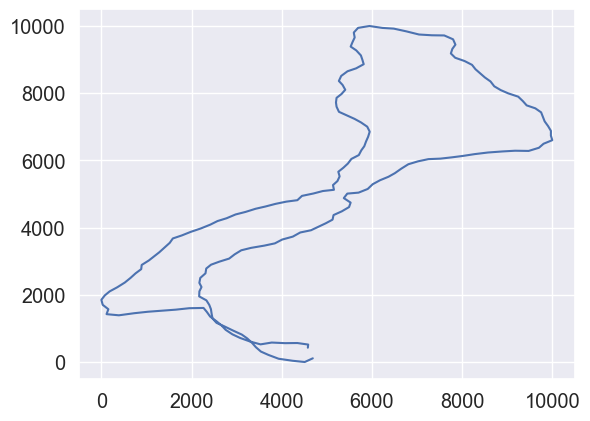

In [142]:
example_np_points_1 = np.genfromtxt("data/points/recomputed/2017-01-01 08_54_23.csv", delimiter=',', dtype="int")
plt.plot(10000-example_np_points_1[:, 1], example_np_points_1[:, 0])

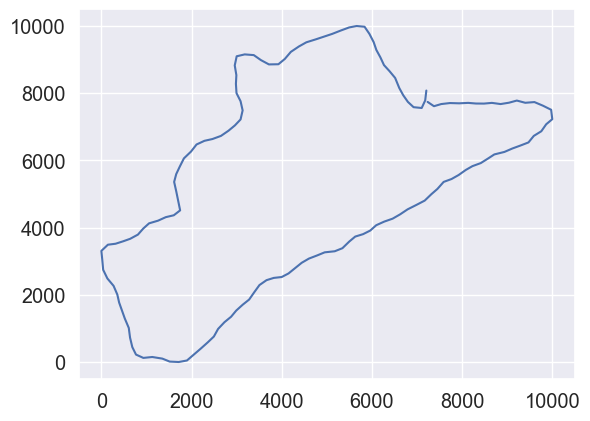

In [143]:
example_np_points_2 = np.genfromtxt("data/points/recomputed/2017-01-01 17_47_03.csv", delimiter=',', dtype="int")
plt.plot(10000-example_np_points_2[:, 1], example_np_points_2[:, 0])

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 5.4:</b> Generate additional dataset for movement records and Generate datasets for alternative 4

</div>

In [144]:
def polarDecomposition(array):
    pd = np.matmul(np.transpose(array), array)
    norm = pd / array.shape[0]
    return norm

original_points_folder = 'data/points/original'
original_points_file_list = os.listdir(original_points_folder)

# creating an empty array of int type
points_array = np.empty((0, 4), float)

for filename in original_points_file_list:
    np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimiter=',', dtype="float")
    if np_points.shape[0] == 0:
        normalized_pd_row = np.zeros((1,4))
    else:
        normalized_pd = polarDecomposition(np_points)
        normalized_pd_row = normalized_pd.flatten()

    points_array = np.row_stack((points_array, normalized_pd_row))

# Exclude outliers
for removed_i in removed_obs:
    points_array = np.delete(points_array, removed_i, axis=0)

points_df = pd.DataFrame(points_array, columns = ['Transformed_points_1','Transformed_points_2','Transformed_points_3','Transformed_points_4'])
points_df, sthelse = min_max_normalize(points_df, reallocate = True)

### Concatenate movement array to DF1 to make DF4

# Create dataset for sport prediction
print("Alt4: Dataset DF4_SPORT for SPORT prediction")
DF4_SPORT = pd.merge(DF1_SPORT, points_df, left_index=True, right_index=True)
display(DF4_SPORT.head(5))

# Create dataset for daytime of start time prediction
print("Alt4: Dataset DF4_DAYTIME for DAYTIME prediction")
DF4_DAYTIME = pd.merge(DF1_DAYTIME, points_df, left_index=True, right_index=True)
display(DF4_DAYTIME.head(5))

# Create dataset for hour of start time prediction
print("Alt4: Dataset DF4_HOUR for HOUR prediction")
DF4_HOUR = pd.merge(DF1_HOUR, points_df, left_index=True, right_index=True)
display(DF4_HOUR.head(5))

# Create dataset for duration prediction
print("Alt4: Dataset DF4_DUR for DURATION prediction")
DF4_DUR = pd.merge(DF1_DUR, points_df, left_index=True, right_index=True)
display(DF4_DUR.head(5))


C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\3222268607.py:13: UserWarning: genfromtxt: Empty input file: "data/points/original/2017-01-01 15_02_04.csv"
  np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimiter=',', dtype="float")
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\3222268607.py:13: UserWarning: genfromtxt: Empty input file: "data/points/original/2017-01-03 17_41_24.csv"
  np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimiter=',', dtype="float")
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\3222268607.py:13: UserWarning: genfromtxt: Empty input file: "data/points/original/2017-01-04 18_05_48.csv"
  np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimiter=',', dtype="float")
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\3222268607.py:13: UserWarning: genfromtxt: Empty input file: "data/points/original/2017-01-07 15_23_19.csv"
  np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimi

Alt4: Dataset DF4_SPORT for SPORT prediction


C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\3222268607.py:13: UserWarning: genfromtxt: Empty input file: "data/points/original/2020-11-14 20_09_15.csv"
  np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimiter=',', dtype="float")
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\3222268607.py:13: UserWarning: genfromtxt: Empty input file: "data/points/original/2020-11-17 18_07_11.csv"
  np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimiter=',', dtype="float")
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\3222268607.py:13: UserWarning: genfromtxt: Empty input file: "data/points/original/2020-11-20 18_23_06.csv"
  np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimiter=',', dtype="float")
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\3222268607.py:13: UserWarning: genfromtxt: Empty input file: "data/points/original/2020-11-24 13_29_36.csv"
  np_points = np.genfromtxt(f"{original_points_folder}/{filename}", delimi

sport  duration_s  distance_km  calories_kcal  speed_avg_kmh  \
0          WALKING    0.124111     0.060566       0.111403       0.013888   
1  WEIGHT_TRAINING    0.142994     0.000000       0.255362       0.000000   
2          WALKING    0.093158     0.047607       0.085763       0.014527   
3          WALKING    0.107858     0.058312       0.102427       0.015378   
4          RUNNING    0.145623     0.165358       0.383988       0.032332   

   speed_max_kmh  start_lat  start_long   end_lat  end_long  ...  \
0       0.043315   0.833809    0.936068  0.833813  0.936069  ...   
1       0.016501   0.833814    0.936071  0.833805  0.936067  ...   
2       0.037127   0.833814    0.936071  0.833805  0.936067  ...   
3       0.043315   0.833817    0.936071  0.833808  0.936068  ...   
4       0.086630   0.833809    0.936070  0.833815  0.936069  ...   

   start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0                         1.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         1.0                       0.0   
4                         0.0                       0.0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SUMMER  start_time_season_WINTER  Transformed_points_1  \
0                       0.0                       1.0              0.869051   
1                       0.0                       1.0              0.000000   
2                       0.0                       1.0              0.868936   
3                       0.0                       1.0              0.869057   
4                       0.0                       1.0              0.868926   

   Transformed_points_2  Transformed_points_3  Transformed_points_4  
0              0.914140              0.914140              0.874725  
1              0.009608              0.009608              0.000000  
2              0.914190              0.914190              0.874938  
3              0.914177              0.914177              0.874789  
4              0.913689              0.913689              0.873977  

[5 rows x 67 columns]

Alt4: Dataset DF4_DAYTIME for DAYTIME prediction


start_time_daytime_cat  duration_s  distance_km  calories_kcal  \
0                MORNING    0.124111     0.060566       0.111403   
1              AFTERNOON    0.142994     0.000000       0.255362   
2                EVENING    0.093158     0.047607       0.085763   
3                MORNING    0.107858     0.058312       0.102427   
4              AFTERNOON    0.145623     0.165358       0.383988   

   speed_avg_kmh  speed_max_kmh  start_lat  start_long   end_lat  end_long  \
0       0.013888       0.043315   0.833809    0.936068  0.833813  0.936069   
1       0.000000       0.016501   0.833814    0.936071  0.833805  0.936067   
2       0.014527       0.037127   0.833814    0.936071  0.833805  0.936067   
3       0.015378       0.043315   0.833817    0.936071  0.833808  0.936068   
4       0.032332       0.086630   0.833809    0.936070  0.833815  0.936069   

   ...  start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0  ...                         1.0                       0.0   
1  ...                         0.0                       0.0   
2  ...                         0.0                       0.0   
3  ...                         1.0                       0.0   
4  ...                         0.0                       0.0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SUMMER  start_time_season_WINTER  Transformed_points_1  \
0                       0.0                       1.0              0.869051   
1                       0.0                       1.0              0.000000   
2                       0.0                       1.0              0.868936   
3                       0.0                       1.0              0.869057   
4                       0.0                       1.0              0.868926   

   Transformed_points_2  Transformed_points_3  Transformed_points_4  
0              0.914140              0.914140              0.874725  
1              0.009608              0.009608              0.000000  
2              0.914190              0.914190              0.874938  
3              0.914177              0.914177              0.874789  
4              0.913689              0.913689              0.873977  

[5 rows x 67 columns]

Alt4: Dataset DF4_HOUR for HOUR prediction


start_time_hour_original  duration_s  distance_km  calories_kcal  \
0                         8    0.124111     0.060566       0.111403   
1                        14    0.142994     0.000000       0.255362   
2                        17    0.093158     0.047607       0.085763   
3                         8    0.107858     0.058312       0.102427   
4                        16    0.145623     0.165358       0.383988   

   speed_avg_kmh  speed_max_kmh  start_lat  start_long   end_lat  end_long  \
0       0.013888       0.043315   0.833809    0.936068  0.833813  0.936069   
1       0.000000       0.016501   0.833814    0.936071  0.833805  0.936067   
2       0.014527       0.037127   0.833814    0.936071  0.833805  0.936067   
3       0.015378       0.043315   0.833817    0.936071  0.833808  0.936068   
4       0.032332       0.086630   0.833809    0.936070  0.833815  0.936069   

   ...  start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0  ...                         1.0                       0.0   
1  ...                         0.0                       0.0   
2  ...                         0.0                       0.0   
3  ...                         1.0                       0.0   
4  ...                         0.0                       0.0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SUMMER  start_time_season_WINTER  Transformed_points_1  \
0                       0.0                       1.0              0.869051   
1                       0.0                       1.0              0.000000   
2                       0.0                       1.0              0.868936   
3                       0.0                       1.0              0.869057   
4                       0.0                       1.0              0.868926   

   Transformed_points_2  Transformed_points_3  Transformed_points_4  
0              0.914140              0.914140              0.874725  
1              0.009608              0.009608              0.000000  
2              0.914190              0.914190              0.874938  
3              0.914177              0.914177              0.874789  
4              0.913689              0.913689              0.873977  

[5 rows x 67 columns]

Alt4: Dataset DF4_DUR for DURATION prediction


duration_s_original  duration_s  distance_km  calories_kcal  speed_avg_kmh  \
0                 2084    0.124111     0.060566       0.111403       0.013888   
1                 2400    0.142994     0.000000       0.255362       0.000000   
2                 1566    0.093158     0.047607       0.085763       0.014527   
3                 1812    0.107858     0.058312       0.102427       0.015378   
4                 2444    0.145623     0.165358       0.383988       0.032332   

   speed_max_kmh  start_lat  start_long   end_lat  end_long  ...  \
0       0.043315   0.833809    0.936068  0.833813  0.936069  ...   
1       0.016501   0.833814    0.936071  0.833805  0.936067  ...   
2       0.037127   0.833814    0.936071  0.833805  0.936067  ...   
3       0.043315   0.833817    0.936071  0.833808  0.936068  ...   
4       0.086630   0.833809    0.936070  0.833815  0.936069  ...   

   start_time_daytime_MORNING  start_time_daytime_NIGHT  \
0                         1.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         1.0                       0.0   
4                         0.0                       0.0   

   start_time_season_AUTUMN  start_time_season_SPRING  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   start_time_season_SUMMER  start_time_season_WINTER  Transformed_points_1  \
0                       0.0                       1.0              0.869051   
1                       0.0                       1.0              0.000000   
2                       0.0                       1.0              0.868936   
3                       0.0                       1.0              0.869057   
4                       0.0                       1.0              0.868926   

   Transformed_points_2  Transformed_points_3  Transformed_points_4  
0              0.914140              0.914140              0.874725  
1              0.009608              0.009608              0.000000  
2              0.914190              0.914190              0.874938  
3              0.914177              0.914177              0.874789  
4              0.913689              0.913689              0.873977  

[5 rows x 67 columns]

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 6:</b> Shifting timeseries
</div>

In [145]:
def past_time_shift(df_, classCol, nEvents, to_numpy_ = True, Xfilename=None, Yfilename=None):
    df_Y = df_[classCol]
    df_X = df_.drop([classCol], axis = 1)
    Cols_X = list(df_X.columns)
    
    for c in Cols_X:
        for e in range(1, nEvents + 1): 
            name = c+"_"+str(e)
            df_X[name] = df_X[c].shift(e)
    
    # Keep only past event columns
    df_X = df_X.drop(Cols_X, axis = 1)
    # Remove nEvents first rows having NaN
    df_X = df_X.iloc[nEvents:, :]
    df_Y = df_Y.iloc[nEvents:]

    df_X.reset_index(drop = True, inplace = True)
    df_Y.reset_index(drop = True, inplace = True)

    if to_numpy_:
        # Transform to numpy array
        df_X = df_X.to_numpy()
        df_Y = df_Y.to_numpy()

        if Xfilename:
            np.savetxt(Xfilename, df_X, delimiter = ",")
        if Yfilename:
            if isinstance(df_Y[0], str):
                np.savetxt(Yfilename, df_Y, delimiter = ",", fmt='%s')
            else:
                np.savetxt(Yfilename, df_Y, delimiter = ",")
    else:
        if Xfilename:
            df_X.to_csv(Xfilename, index=False)
        if Xfilename:
            df_Y.to_csv(Yfilename, index=False)

    return df_X, df_Y

################# ALTERNATIVE 1'S DATASETS ##################
nEvents = 15

### Dataset DF1_SPORT_X
DF1_SPORT_X, DF1_SPORT_Y = past_time_shift(DF1_SPORT, SPORT_CLASS_COL, nEvents, True, "data/DF1/DF1_SPORT_X.csv", "data/DF1/DF1_SPORT_Y.csv")

### Dataset DF1_DAYTIME_X
DF1_DAYTIME_X, DF1_DAYTIME_Y = past_time_shift(DF1_DAYTIME, DAYTIME_CLASS_COL, nEvents, True, "data/DF1/DF1_DAYTIME_X.csv", "data/DF1/DF1_DAYTIME_Y.csv")

### Dataset DF1_HOUR_X
DF1_HOUR_X, DF1_HOUR_Y = past_time_shift(DF1_HOUR, HOUR_CLASS_COL, nEvents, True, "data/DF1/DF1_HOUR_X.csv", "data/DF1/DF1_HOUR_Y.csv")

### Dataset DF1_DUR_X
DF1_DUR_X, DF1_DUR_Y = past_time_shift(DF1_DUR, DUR_CLASS_COL, nEvents, True, "data/DF1/DF1_DUR_X.csv", "data/DF1/DF1_DUR_Y.csv")

################# ALTERNATIVE 2'S DATASETS ##################
### Dataset DF2_SPORT_X
DF2_SPORT_X, DF2_SPORT_Y = past_time_shift(DF2_SPORT, SPORT_CLASS_COL, nEvents, True, "data/DF2/DF2_SPORT_X.csv", "data/DF2/DF2_SPORT_Y.csv")

### Dataset DF2_DAYTIME_X
DF2_DAYTIME_X, DF2_DAYTIME_Y = past_time_shift(DF2_DAYTIME, DAYTIME_CLASS_COL, nEvents, True, "data/DF2/DF2_DAYTIME_X.csv", "data/DF2/DF2_DAYTIME_Y.csv")

### Dataset DF2_HOUR_X
DF2_HOUR_X, DF2_HOUR_Y = past_time_shift(DF2_HOUR, HOUR_CLASS_COL, nEvents, True, "data/DF2/DF2_HOUR_X.csv", "data/DF2/DF2_HOUR_Y.csv")

### Dataset DF2_DUR_X
DF2_DUR_X, DF2_DUR_Y = past_time_shift(DF2_DUR, DUR_CLASS_COL, nEvents, True, "data/DF2/DF2_DUR_X.csv", "data/DF2/DF2_DUR_Y.csv")

################# ALTERNATIVE 3'S DATASETS ################## UNCOMMENT THIS PART TO RUN ALTERNATIVE 3 ###########################################################
### Dataset DF3_SPORT_X
# DF3_SPORT_X, DF3_SPORT_Y = past_time_shift(DF3_SPORT, SPORT_CLASS_COL, nEvents, True, "data/DF3/DF3_SPORT_X.csv", "data/DF3/DF3_SPORT_Y.csv")

### Dataset DF3_DAYTIME_X
# DF3_DAYTIME_X, DF3_DAYTIME_Y = past_time_shift(DF3_DAYTIME, DAYTIME_CLASS_COL, nEvents, True, "data/DF3/DF3_DAYTIME_X.csv", "data/DF3/DF3_DAYTIME_Y.csv")

### Dataset DF3_HOUR_X
# DF3_HOUR_X, DF3_HOUR_Y = past_time_shift(DF3_HOUR, HOUR_CLASS_COL, nEvents, True, "data/DF3/DF3_HOUR_X.csv", "data/DF3/DF3_HOUR_Y.csv")

### Dataset DF3_DUR_X
# DF3_DUR_X, DF3_DUR_Y = past_time_shift(DF3_DUR, DUR_CLASS_COL, nEvents, True, "data/DF3/DF3_DUR_X.csv", "data/DF3/DF3_DUR_Y.csv")

################# ALTERNATIVE 4'S DATASETS ##################
### Dataset DF4_SPORT_X
DF4_SPORT_X, DF4_SPORT_Y = past_time_shift(DF4_SPORT, SPORT_CLASS_COL, nEvents, True, "data/DF4/DF4_SPORT_X.csv", "data/DF4/DF4_SPORT_Y.csv")

### Dataset DF4_DAYTIME_X
DF4_DAYTIME_X, DF4_DAYTIME_Y = past_time_shift(DF4_DAYTIME, DAYTIME_CLASS_COL, nEvents, True, "data/DF4/DF4_DAYTIME_X.csv", "data/DF4/DF4_DAYTIME_Y.csv")

### Dataset DF4_HOUR_X
DF4_HOUR_X, DF4_HOUR_Y = past_time_shift(DF4_HOUR, HOUR_CLASS_COL, nEvents, True, "data/DF4/DF4_HOUR_X.csv", "data/DF4/DF4_HOUR_Y.csv")

### Dataset DF4_DUR_X
DF4_DUR_X, DF4_DUR_Y = past_time_shift(DF4_DUR, DUR_CLASS_COL, nEvents, True, "data/DF4/DF4_DUR_X.csv", "data/DF4/DF4_DUR_Y.csv")

C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_X[name] = df_X[c].shift(e)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_X[name] = df_X[c].shift(e)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Step 7:</b> Partitioning data
</div>

In [146]:
def getIndexPartition(X, Y, test_percent, stratify_cv=None):
    # Set random seed for reproducibility
    np.random.seed(0)

    nX = X.shape[0]
    X_Idx = np.arange(0, nX, 1, dtype=int)
    nY = Y.shape[0]
    Y_Idx = np.arange(0, nY, 1, dtype=int)
    if stratify_cv:
        stratify_ = Y_Idx
    else:
        stratify_ = None
        
    XtrainIdx, XtestIdx, YtrainIdx, YtestIdx = train_test_split(X_Idx, Y_Idx, test_size=test_percent, stratify = stratify_)
    

    return XtrainIdx, XtestIdx

def getPartitionByIdx(X, Y, trainIdx, testIdx, XtrainFilename=None, XtestFilename=None, YtrainFilename=None, YtestFilename=None):
    Xtrain = X[trainIdx, :]
    Xtest = X[testIdx, :]
    Ytrain = Y[trainIdx]
    Ytest = Y[testIdx]

    if XtrainFilename:
        np.savetxt(XtrainFilename, Xtrain, delimiter = ",")
    if XtestFilename:
        np.savetxt(XtestFilename, Xtest, delimiter = ",")
    if YtrainFilename:
            if isinstance(Ytrain[0], str):
                np.savetxt(YtrainFilename, Ytrain, delimiter = ",", fmt='%s')
            else:
                np.savetxt(YtrainFilename, Ytrain, delimiter = ",")
    if YtestFilename:
            if isinstance(Ytest[0], str):
                np.savetxt(YtestFilename, Ytest, delimiter = ",", fmt='%s')
            else:
                np.savetxt(YtestFilename, Ytest, delimiter = ",")
    
    return Xtrain, Xtest, Ytrain, Ytest

test_percent = 0.15
trainIdx, testIdx = getIndexPartition(DF1_SPORT_X, DF1_SPORT_Y, test_percent)

################# ALTERNATIVE 1'S DATASETS' PARTITIONS ##################
### Dataset DF1_SPORT_X
DF1_SPORT_Xtrain, DF1_SPORT_Xtest, DF1_SPORT_Ytrain, DF1_SPORT_Ytest = getPartitionByIdx(DF1_SPORT_X, DF1_SPORT_Y, trainIdx, testIdx, "data/DF1/DF1_SPORT_Xtrain.csv", "data/DF1/DF1_SPORT_Xtest.csv", "data/DF1/DF1_SPORT_Ytrain.csv", "data/DF1/DF1_SPORT_Ytest.csv")
### Dataset DF1_DAYTIME
DF1_DAYTIME_Xtrain, DF1_DAYTIME_Xtest, DF1_DAYTIME_Ytrain, DF1_DAYTIME_Ytest = getPartitionByIdx(DF1_DAYTIME_X, DF1_DAYTIME_Y, trainIdx, testIdx, "data/DF1/DF1_DAYTIME_Xtrain.csv", "data/DF1/DF1_DAYTIME_Xtest.csv", "data/DF1/DF1_DAYTIME_Ytrain.csv", "data/DF1/DF1_DAYTIME_Ytest.csv")
### Dataset DF1_HOUR
DF1_HOUR_Xtrain, DF1_HOUR_Xtest, DF1_HOUR_Ytrain, DF1_HOUR_Ytest = getPartitionByIdx(DF1_HOUR_X, DF1_HOUR_Y, trainIdx, testIdx, "data/DF1/DF1_HOUR_Xtrain.csv", "data/DF1/DF1_HOUR_Xtest.csv", "data/DF1/DF1_HOUR_Ytrain.csv", "data/DF1/DF1_HOUR_Ytest.csv")
### Dataset DF1_DUR
DF1_DUR_Xtrain, DF1_DUR_Xtest, DF1_DUR_Ytrain, DF1_DUR_Ytest = getPartitionByIdx(DF1_DUR_X, DF1_DUR_Y, trainIdx, testIdx, "data/DF1/DF1_DUR_Xtrain.csv", "data/DF1/DF1_DUR_Xtest.csv", "data/DF1/DF1_DUR_Ytrain.csv", "data/DF1/DF1_DUR_Ytest.csv")

################# ALTERNATIVE 2'S DATASETS ##################
### Dataset DF2_SPORT_X
DF2_SPORT_Xtrain, DF2_SPORT_Xtest, DF2_SPORT_Ytrain, DF2_SPORT_Ytest = getPartitionByIdx(DF2_SPORT_X, DF2_SPORT_Y, trainIdx, testIdx, "data/DF2/DF2_SPORT_Xtrain.csv", "data/DF2/DF2_SPORT_Xtest.csv", "data/DF2/DF2_SPORT_Ytrain.csv", "data/DF2/DF2_SPORT_Ytest.csv")
### Dataset DF2_DAYTIME
DF2_DAYTIME_Xtrain, DF2_DAYTIME_Xtest, DF2_DAYTIME_Ytrain, DF2_DAYTIME_Ytest = getPartitionByIdx(DF2_DAYTIME_X, DF2_DAYTIME_Y, trainIdx, testIdx, "data/DF2/DF2_DAYTIME_Xtrain.csv", "data/DF2/DF2_DAYTIME_Xtest.csv", "data/DF2/DF2_DAYTIME_Ytrain.csv", "data/DF2/DF2_DAYTIME_Ytest.csv")
### Dataset DF2_HOUR
DF2_HOUR_Xtrain, DF2_HOUR_Xtest, DF2_HOUR_Ytrain, DF2_HOUR_Ytest = getPartitionByIdx(DF2_HOUR_X, DF2_HOUR_Y, trainIdx, testIdx, "data/DF2/DF2_HOUR_Xtrain.csv", "data/DF2/DF2_HOUR_Xtest.csv", "data/DF2/DF2_HOUR_Ytrain.csv", "data/DF2/DF2_HOUR_Ytest.csv")
### Dataset DF2_DUR
DF2_DUR_Xtrain, DF2_DUR_Xtest, DF2_DUR_Ytrain, DF2_DUR_Ytest = getPartitionByIdx(DF2_DUR_X, DF2_DUR_Y, trainIdx, testIdx, "data/DF2/DF2_DUR_Xtrain.csv", "data/DF2/DF2_DUR_Xtest.csv", "data/DF2/DF2_DUR_Ytrain.csv", "data/DF2/DF2_DUR_Ytest.csv")

################# ALTERNATIVE 3'S DATASETS ################## UNCOMMENT THIS PART TO RUN ALTERNATIVE 3 ###########################################################
### Dataset DF3_SPORT_X
# DF3_SPORT_Xtrain, DF3_SPORT_Xtest, DF3_SPORT_Ytrain, DF3_SPORT_Ytest = getPartitionByIdx(DF3_SPORT_X, DF3_SPORT_Y, trainIdx, testIdx, "data/DF3/DF3_SPORT_Xtrain.csv", "data/DF3/DF3_SPORT_Xtest.csv", "data/DF3/DF3_SPORT_Ytrain.csv", "data/DF3/DF3_SPORT_Ytest.csv")
### Dataset DF3_DAYTIME
# DF3_DAYTIME_Xtrain, DF3_DAYTIME_Xtest, DF3_DAYTIME_Ytrain, DF3_DAYTIME_Ytest = getPartitionByIdx(DF3_DAYTIME_X, DF3_DAYTIME_Y, trainIdx, testIdx, "data/DF3/DF3_DAYTIME_Xtrain.csv", "data/DF3/DF3_DAYTIME_Xtest.csv", "data/DF3/DF3_DAYTIME_Ytrain.csv", "data/DF3/DF3_DAYTIME_Ytest.csv")
### Dataset DF3_HOUR
# DF3_HOUR_Xtrain, DF3_HOUR_Xtest, DF3_HOUR_Ytrain, DF3_HOUR_Ytest = getPartitionByIdx(DF3_HOUR_X, DF3_HOUR_Y, trainIdx, testIdx, "data/DF3/DF3_HOUR_Xtrain.csv", "data/DF3/DF3_HOUR_Xtest.csv", "data/DF3/DF3_HOUR_Ytrain.csv", "data/DF3/DF3_HOUR_Ytest.csv")
### Dataset DF3_DUR
# DF3_DUR_Xtrain, DF3_DUR_Xtest, DF3_DUR_Ytrain, DF3_DUR_Ytest = getPartitionByIdx(DF3_DUR_X, DF3_DUR_Y, trainIdx, testIdx, "data/DF3/DF3_DUR_Xtrain.csv", "data/DF3/DF3_DUR_Xtest.csv", "data/DF3/DF3_DUR_Ytrain.csv", "data/DF3/DF3_DUR_Ytest.csv")

################# ALTERNATIVE 4'S DATASETS ##################
### Dataset DF4_SPORT_X
DF4_SPORT_Xtrain, DF4_SPORT_Xtest, DF4_SPORT_Ytrain, DF4_SPORT_Ytest = getPartitionByIdx(DF4_SPORT_X, DF4_SPORT_Y, trainIdx, testIdx, "data/DF4/DF4_SPORT_Xtrain.csv", "data/DF4/DF4_SPORT_Xtest.csv", "data/DF4/DF4_SPORT_Ytrain.csv", "data/DF4/DF4_SPORT_Ytest.csv")
### Dataset DF4_DAYTIME
DF4_DAYTIME_Xtrain, DF4_DAYTIME_Xtest, DF4_DAYTIME_Ytrain, DF4_DAYTIME_Ytest = getPartitionByIdx(DF4_DAYTIME_X, DF4_DAYTIME_Y, trainIdx, testIdx, "data/DF4/DF4_DAYTIME_Xtrain.csv", "data/DF4/DF4_DAYTIME_Xtest.csv", "data/DF4/DF4_DAYTIME_Ytrain.csv", "data/DF4/DF4_DAYTIME_Ytest.csv")
### Dataset DF4_HOUR
DF4_HOUR_Xtrain, DF4_HOUR_Xtest, DF4_HOUR_Ytrain, DF4_HOUR_Ytest = getPartitionByIdx(DF4_HOUR_X, DF4_HOUR_Y, trainIdx, testIdx, "data/DF4/DF4_HOUR_Xtrain.csv", "data/DF4/DF4_HOUR_Xtest.csv", "data/DF4/DF4_HOUR_Ytrain.csv", "data/DF4/DF4_HOUR_Ytest.csv")
### Dataset DF4_DUR
DF4_DUR_Xtrain, DF4_DUR_Xtest, DF4_DUR_Ytrain, DF4_DUR_Ytest = getPartitionByIdx(DF4_DUR_X, DF4_DUR_Y, trainIdx, testIdx, "data/DF4/DF4_DUR_Xtrain.csv", "data/DF4/DF4_DUR_Xtest.csv", "data/DF4/DF4_DUR_Ytrain.csv", "data/DF4/DF4_DUR_Ytest.csv")

## MODEL CONSTRUCTION

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 1:</b> Model 1 - KNN Classification, Logistic Regression and Decision Tree Classification for sport prediction
</div>

In [147]:
def KNNClassify(Xtrain, Xtest, Ytrain, Ytest, nNeighboursList):
    # Set random seed for reproducibility
    np.random.seed(0)

    modelDict = dict()
    Ytest_predDict = dict()
    accuracyDict = dict()

    if not isinstance(nNeighboursList, list):
        nNeighboursList = list(nNeighboursList)
    for nNeighbours in nNeighboursList:
        model = KNeighborsClassifier(n_neighbors= nNeighbours)
        model.fit(Xtrain, Ytrain)
        modelDict[str(nNeighbours)] = model
        Ytest_pred = model.predict(Xtest)
        Ytest_predDict[str(nNeighbours)] = Ytest_pred
        accuracy = accuracy_score(Ytest, Ytest_pred)*100
        accuracyDict[str(nNeighbours)] = accuracy

    return modelDict, Ytest_predDict, accuracyDict

def LogisticRegress_Multiclass(Xtrain, Xtest, Ytrain, Ytest):
    # Set random seed for reproducibility
    np.random.seed(0)
    
    # Fit logistic regression model
    model = LogisticRegression(multi_class='ovr')
    model.fit(Xtrain, Ytrain)

    # Predict labels and probabilities
    Ytest_pred = model.predict(Xtest)
    Ytest_pred_probabilities = model.predict_proba(Xtest)

    accuracy = accuracy_score(Ytest, Ytest_pred)*100
    print(f"Accuracy: {round(accuracy, 2)}%")

    return model, Ytest_pred, accuracy

def DecisionTreeClassify(Xtrain, Xtest, Ytrain, Ytest):
    # Set random seed
    np.random.seed(0)

    # Load data and select only the first two features
    model = DecisionTreeClassifier(criterion='entropy')   # define object "clf" which represents a decision tree
    model.fit(Xtrain, Ytrain)                    # learn a decision tree that fits well the labeled images  
    Ytest_pred = model.predict(Xtest)          # compute the predicted labels for the images

    # Calculate the accuracy score of the predictions
    accuracy = accuracy_score(Ytest, Ytest_pred)*100
    print(f"Accuracy: {round(accuracy, 2)}%")
    
    return model, Ytest_pred, accuracy

def printDict(Dict):
    for key, value in Dict.items():
        print(key, ' : ', value)

def plottingConfusionMatrix(model, Xtest, Ytest):
    matrix = plot_confusion_matrix(model, Xtest, Ytest, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()

### Dataset DF1_SPORT_X
nNeighboursTuning = list(range(7, 50))
DF1_SPORT_MODEL_DICT, DF1_SPORT_Ytest_pred_DICT, DF1_SPORT_ACCURACY_DICT = KNNClassify(DF1_SPORT_Xtrain, DF1_SPORT_Xtest, DF1_SPORT_Ytrain, DF1_SPORT_Ytest, nNeighboursTuning)
# print("Accuracy of KNN model for predicting SPORT of Alternative 1 ...\n<number of neighbours> : <accuracy>")
# printDict(DF1_SPORT_ACCURACY_DICT)


The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of 79.1015625 is 9. Therefore, the selected model is the corresponding model of that accuracy.


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


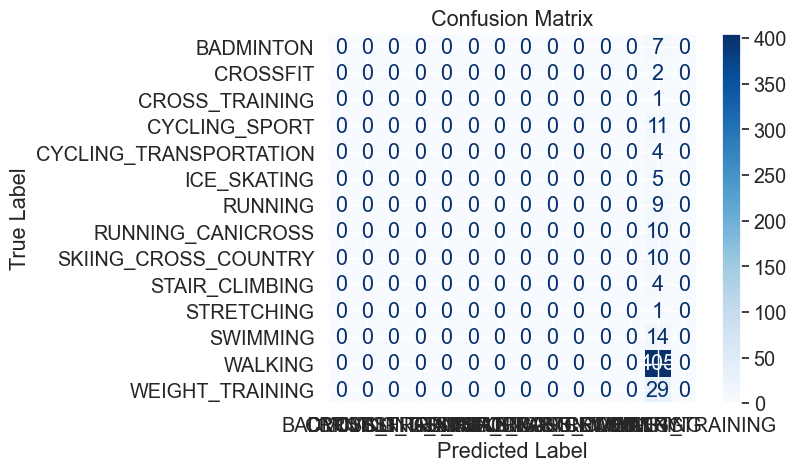

In [148]:
### KNN Classification
DF1_SPORT_MAX_ACCURACY = max(DF1_SPORT_ACCURACY_DICT.values())
DF1_SPORT_MAX_ACCURACY_nNeighbours = max(DF1_SPORT_ACCURACY_DICT, key=DF1_SPORT_ACCURACY_DICT.get)
print(f"The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of {DF1_SPORT_MAX_ACCURACY} is {DF1_SPORT_MAX_ACCURACY_nNeighbours}. Therefore, the selected model is the corresponding model of that accuracy.")
DF1_SPORT_MODEL_KNN = DF1_SPORT_MODEL_DICT[DF1_SPORT_MAX_ACCURACY_nNeighbours]
DF1_SPORT_Ytest_pred_KNN = DF1_SPORT_Ytest_pred_DICT[DF1_SPORT_MAX_ACCURACY_nNeighbours]
DF1_SPORT_ACCURACY_KNN = DF1_SPORT_ACCURACY_DICT[DF1_SPORT_MAX_ACCURACY_nNeighbours]

plottingConfusionMatrix(DF1_SPORT_MODEL_KNN, DF1_SPORT_Xtest, DF1_SPORT_Ytest)

# Save the model to disk
DF1_SPORT_MODEL_KNN_filename = 'model/DF1_SPORT_MODEL_KNN.sav'
#joblib.dump(DF1_SPORT_MODEL_KNN, DF1_SPORT_MODEL_KNN_filename)

c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 76.17%


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


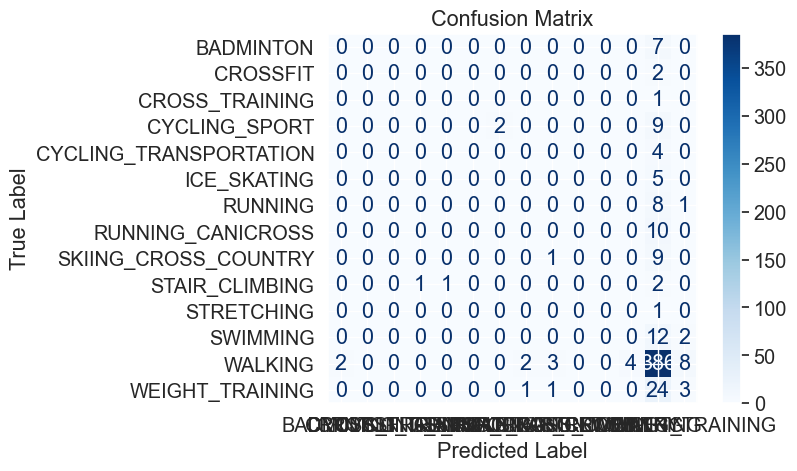

In [149]:
### Logistic regression
DF1_SPORT_MODEL_LOG, DF1_SPORT_Ytest_pred_LOG, DF1_SPORT_ACCURACY_LOG = LogisticRegress_Multiclass(DF1_SPORT_Xtrain, DF1_SPORT_Xtest, DF1_SPORT_Ytrain, DF1_SPORT_Ytest)
plottingConfusionMatrix(DF1_SPORT_MODEL_LOG, DF1_SPORT_Xtest, DF1_SPORT_Ytest)

# Save the model to disk
DF1_SPORT_MODEL_LOG_filename = 'model/DF1_SPORT_MODEL_LOG.sav'
#joblib.dump(DF1_SPORT_MODEL_LOG, DF1_SPORT_MODEL_LOG_filename)


Accuracy: 65.62%


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


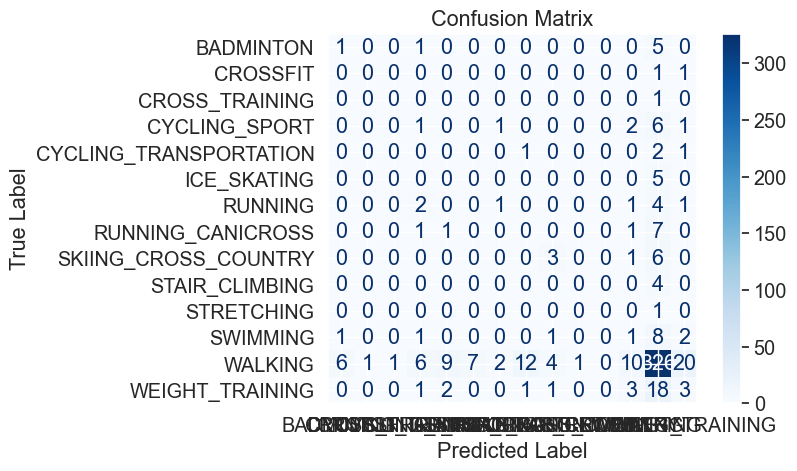

In [150]:
### Decision Tree Classification
DF1_SPORT_MODEL_TREE, DF1_SPORT_Ytest_pred_TREE, DF1_SPORT_ACCURACY_TREE = DecisionTreeClassify(DF1_SPORT_Xtrain, DF1_SPORT_Xtest, DF1_SPORT_Ytrain, DF1_SPORT_Ytest)
plottingConfusionMatrix(DF1_SPORT_MODEL_TREE, DF1_SPORT_Xtest, DF1_SPORT_Ytest)

# Save the model to disk
DF1_SPORT_MODEL_TREE_filename = 'model/DF1_SPORT_MODEL_TREE.sav'
#joblib.dump(DF1_SPORT_MODEL_TREE, DF1_SPORT_MODEL_TREE_filename)

`OVERALL FOR DATASET DF1, KNN CLASSIFIER PERFORMS THE BEST AMONG 3 TESTS ALGORITHMS. THEREFORE, KNN CLASSIFICATION IS CHOSEN TO PERFORM SPORT OF NEXT EVENT PREDICTION.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 1:</b> Model 2 - KNN Classification, Logistic Regression and Decision Tree Classification for daytime prediction
</div>

In [151]:
nNeighboursTuning = list(range(7, 50))
DF1_DAYTIME_MODEL_DICT, DF1_DAYTIME_Ytest_pred_DICT, DF1_DAYTIME_ACCURACY_DICT = KNNClassify(DF1_DAYTIME_Xtrain, DF1_DAYTIME_Xtest, DF1_DAYTIME_Ytrain, DF1_DAYTIME_Ytest, nNeighboursTuning)
print("Accuracy of KNN model for predicting TIME of Alternative 1 ...\n<number of neighbours> : <accuracy>")
printDict(DF1_DAYTIME_ACCURACY_DICT)

Accuracy of KNN model for predicting TIME of Alternative 1 ...
<number of neighbours> : <accuracy>
7  :  50.0
8  :  50.5859375
9  :  50.1953125
10  :  49.8046875
11  :  49.4140625
12  :  51.7578125
13  :  49.8046875
14  :  50.390625
15  :  49.4140625
16  :  51.3671875
17  :  50.5859375
18  :  51.5625
19  :  50.9765625
20  :  51.5625
21  :  53.515625
22  :  53.515625
23  :  52.9296875
24  :  51.953125
25  :  50.5859375
26  :  50.5859375
27  :  49.609375
28  :  50.9765625
29  :  50.78125
30  :  51.171875
31  :  50.9765625
32  :  51.171875
33  :  50.9765625
34  :  51.5625
35  :  51.7578125
36  :  51.171875
37  :  52.34375
38  :  51.7578125
39  :  53.3203125
40  :  52.34375
41  :  53.515625
42  :  52.9296875
43  :  53.515625
44  :  54.296875
45  :  53.90625
46  :  53.125
47  :  54.296875
48  :  52.734375
49  :  54.1015625


The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of 54.296875 is 44. Therefore, the selected model is the corresponding model of that accuracy.
 The model can be accessed from:


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


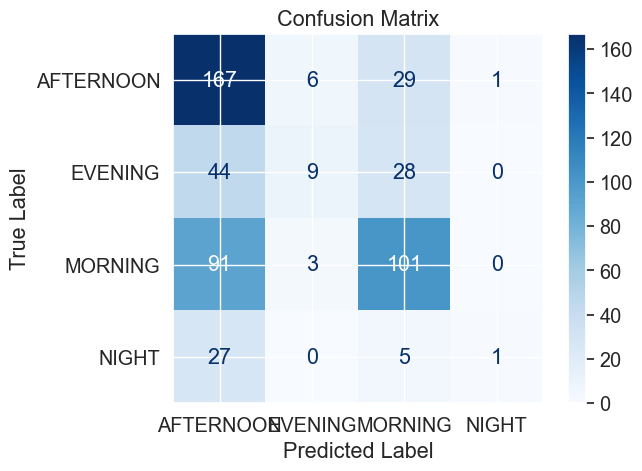

In [152]:
DF1_DAYTIME_MAX_ACCURACY = max(DF1_DAYTIME_ACCURACY_DICT.values())
DF1_DAYTIME_MAX_ACCURACY_nNeighbours = max(DF1_DAYTIME_ACCURACY_DICT, key=DF1_DAYTIME_ACCURACY_DICT.get)
print(f"The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of {DF1_DAYTIME_MAX_ACCURACY} is {DF1_DAYTIME_MAX_ACCURACY_nNeighbours}. Therefore, the selected model is the corresponding model of that accuracy.\n The model can be accessed from:")
DF1_DAYTIME_MODEL_KNN = DF1_DAYTIME_MODEL_DICT[DF1_DAYTIME_MAX_ACCURACY_nNeighbours]
DF1_DAYTIME_Ytest_pred = DF1_DAYTIME_Ytest_pred_DICT[DF1_DAYTIME_MAX_ACCURACY_nNeighbours]
DF1_DAYTIME_ACCURACY = DF1_DAYTIME_ACCURACY_DICT[DF1_DAYTIME_MAX_ACCURACY_nNeighbours]

plottingConfusionMatrix(DF1_DAYTIME_MODEL_KNN, DF1_DAYTIME_Xtest, DF1_DAYTIME_Ytest)

# Save the model to disk
DF1_DAYTIME_MODEL_KNN_filename = 'model/DF1_DAYTIME_MODEL_KNN.sav'
#joblib.dump(DF1_DAYTIME_MODEL_KNN, DF1_DAYTIME_MODEL_KNN_filename)

c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 66.8%


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


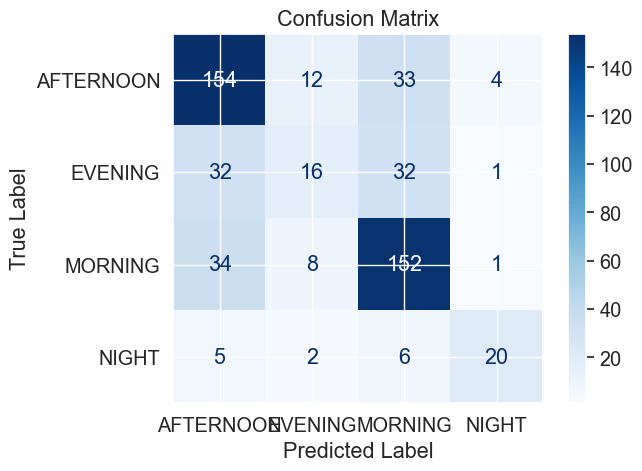

In [153]:
### Logistic regression
DF1_DAYTIME_MODEL_LOG, DF1_DAYTIME_Ytest_pred_LOG, DF1_DAYTIME_ACCURACY_LOG = LogisticRegress_Multiclass(DF1_DAYTIME_Xtrain, DF1_DAYTIME_Xtest, DF1_DAYTIME_Ytrain, DF1_DAYTIME_Ytest)
plottingConfusionMatrix(DF1_DAYTIME_MODEL_LOG, DF1_DAYTIME_Xtest, DF1_DAYTIME_Ytest)

# Save the model to disk
DF1_DAYTIME_MODEL_LOG_filename = 'model/DF1_TIME_MODEL_LOG.sav'
#joblib.dump(DF1_DAYTIME_MODEL_LOG, DF1_DAYTIME_MODEL_LOG_filename)

Accuracy: 60.74%


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


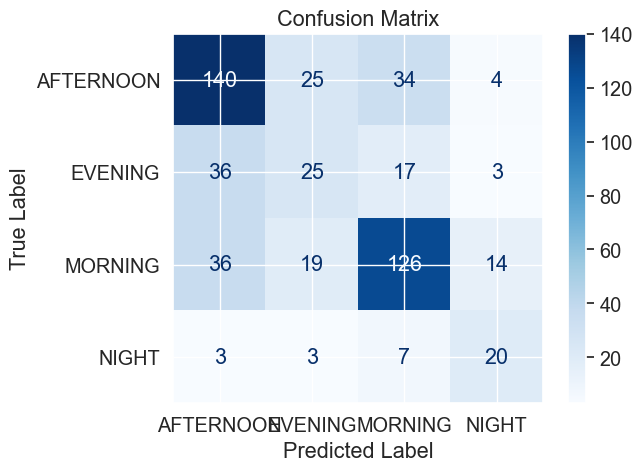

In [154]:
### Decision Tree Classification
DF1_DAYTIME_MODEL_TREE, DF1_DAYTIME_Ytest_pred_TREE, DF1_DAYTIME_ACCURACY_TREE = DecisionTreeClassify(DF1_DAYTIME_Xtrain, DF1_DAYTIME_Xtest, DF1_DAYTIME_Ytrain, DF1_DAYTIME_Ytest)
plottingConfusionMatrix(DF1_DAYTIME_MODEL_TREE, DF1_DAYTIME_Xtest, DF1_DAYTIME_Ytest)

# Save the model to disk
DF1_DAYTIME_MODEL_TREE_filename = 'model/DF1_DAYTIME_MODEL_TREE.sav'
#joblib.dump(DF1_DAYTIME_MODEL_TREE, DF1_DAYTIME_MODEL_TREE_filename)

`OVERALL FOR DATASET DF1, LOGITISTIC REGRESSION MODEL PERFORMS THE BEST AMONG THE 3 TESTS ALGORITHMS. THEREFORE, LOGISTIC REGRESSION MODEL IS CHOSEN TO PERFORM TIME OF DAY OF NEXT EVENT PREDICTION.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 1:</b> Model 3 - Huber Regression for time prediction in terms of hours

We are also interested in predict time (hour) of the start time of the next event, so we chose to use huber regression.
</div>

In [155]:
def HuberRegress(Xtrain, Xtest, Ytrain, Ytest):
    model = HuberRegressor(fit_intercept=True)
    model.fit(Xtrain, Ytrain)

    # Get the optimal weight vector w of the fitted model 
    w_opt = model.coef_

    # Get the optimal intercept of the fitted model  
    w_intercept = model.intercept_

    # Print the optimal weight vector 
    # display(Math(r'$\mathbf{w}_{\rm opt} ='))
    # print(w_opt)

    # Print the optimal intercept
    # display(Math(r'${w}_{0 \rm opt} ='))
    # print(w_intercept)

    Ytest_pred = model.predict(Xtest)

    model_mean_absolute_error = mean_absolute_error(Ytest, Ytest_pred)
    print(f"mean_absolute_error is {model_mean_absolute_error}")

    model_mean_squared_error = mean_squared_error(Ytest, Ytest_pred)
    print(f"mean_squared_error is {model_mean_squared_error}")

    pred_df = pd.DataFrame({'Actual': Ytest, 'Predicted': Ytest_pred})
    display(pred_df)

    return model, Ytest_pred, model_mean_absolute_error

### start time Hour prediction
DF1_HOUR_MODEL, DF1_HOUR_Ytest_pred, DF1_HOUR_MEANERROR = HuberRegress(DF1_HOUR_Xtrain, DF1_HOUR_Xtest, DF1_HOUR_Ytrain, DF1_HOUR_Ytest)

# Save the model to disk
DF1_HOUR_MODEL_filename = 'model/DF1_HOUR_MODEL.sav'
#joblib.dump(DF1_HOUR_MODEL, DF1_HOUR_MODEL_filename)

mean_absolute_error is 3.113624186745994
mean_squared_error is 16.823192937350782


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Actual  Predicted
0        14  13.710032
1         6   7.367433
2         7  10.097547
3        15  17.295597
4        15   6.848952
..      ...        ...
507       9  15.166445
508      13  15.994747
509       6   8.863222
510       8  10.281157
511       3   4.135163

[512 rows x 2 columns]

`OVERALL FOR DATASET DF1, HUBER REGRESSION PERFORMS QUITE GOOD IN PREDICTING THE HOUR OF START TIME OF THE NEXT EVENT WITH ONLY MEAN ERROR OF 3 HOURS`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 1:</b> Model 4 - Huber Regression for duration prediction
We also use huber regression for duration prediction of the next event.
</div>

In [156]:

DF1_DUR_MODEL, DF1_DUR_Ytest_pred, DF1_DUR_MEANERROR = HuberRegress(DF1_DUR_Xtrain, DF1_DUR_Xtest, DF1_DUR_Ytrain, DF1_DUR_Ytest)

# Save the model to disk
DF1_DUR_MODEL_filename = 'model/DF1_DUR_MODEL.sav'
#joblib.dump(DF1_DUR_MODEL, DF1_DUR_MODEL_filename)

mean_absolute_error is 705.2453355057786
mean_squared_error is 833829.5714603905


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Actual    Predicted
0      3721  2447.831544
1      1674  1612.791576
2      3314  2260.654927
3      2381  2162.221583
4      3600  1505.631363
..      ...          ...
507    1903  2500.269278
508    2580  2303.421055
509    1656  1863.372458
510    1748  2326.901764
511    2292  1754.200960

[512 rows x 2 columns]

`OVERALL FOR DATASET DF1, HUBER REGRESSION PERFORMS OKAY IN PREDICTING THE DURATION OF START TIME OF THE NEXT EVENT WITH THE MEAN ERROR OF 11.75 MINUTES`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 2:</b> Model 1 - KNN Classification for sport prediction

We apply the same types of algorithms on the dataset DF2 to see if we have managed to remove any noise compared to the DF1 or if we receive better results.
</div>

In [157]:
### Dataset DF2_SPORT_X
nNeighboursTuning = list(range(7, 50))
DF2_SPORT_MODEL_KNN_DICT, DF2_SPORT_Ytest_pred_KNN_DICT, DF2_SPORT_ACCURACY_KNN_DICT = KNNClassify(DF2_SPORT_Xtrain, DF2_SPORT_Xtest, DF2_SPORT_Ytrain, DF2_SPORT_Ytest, nNeighboursTuning)
print("Accuracy of KNN model for predicting SPORT of Alternative 2 ...\n<number of neighbours> : <accuracy>")
printDict(DF2_SPORT_ACCURACY_KNN_DICT)

Accuracy of KNN model for predicting SPORT of Alternative 2 ...
<number of neighbours> : <accuracy>
7  :  77.34375
8  :  78.3203125
9  :  78.515625
10  :  78.515625
11  :  78.90625
12  :  78.90625
13  :  78.90625
14  :  78.90625
15  :  78.90625
16  :  78.90625
17  :  79.1015625
18  :  79.1015625
19  :  79.1015625
20  :  79.1015625
21  :  79.1015625
22  :  79.1015625
23  :  79.1015625
24  :  79.1015625
25  :  79.1015625
26  :  79.1015625
27  :  79.1015625
28  :  79.1015625
29  :  79.1015625
30  :  79.1015625
31  :  79.1015625
32  :  79.1015625
33  :  79.1015625
34  :  79.1015625
35  :  79.1015625
36  :  79.1015625
37  :  79.1015625
38  :  79.1015625
39  :  79.1015625
40  :  79.1015625
41  :  79.1015625
42  :  79.1015625
43  :  79.1015625
44  :  79.1015625
45  :  79.1015625
46  :  79.1015625
47  :  79.1015625
48  :  79.1015625
49  :  79.1015625


The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of 79.1015625 is 17. Therefore, the selected model is the corresponding model of that accuracy.
 The model can be accessed from:


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


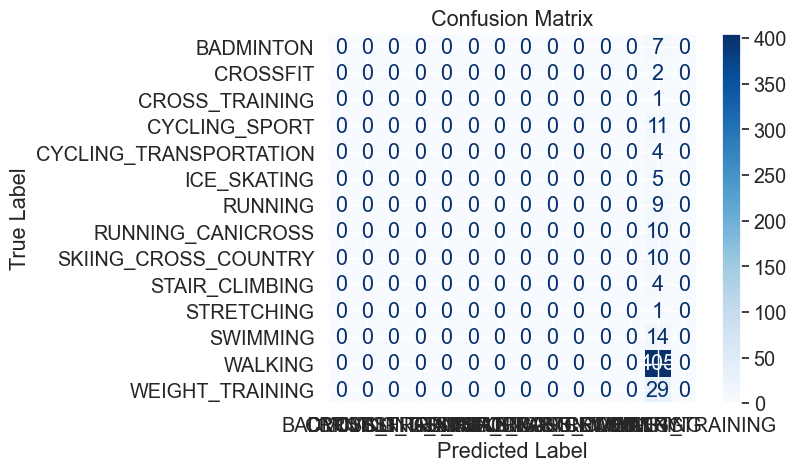

['model/DF2_SPORT_MODEL_KNN.sav']

In [158]:
#del max
DF2_SPORT_MAX_ACCURACY_KNN = max(DF2_SPORT_ACCURACY_KNN_DICT.values())
DF2_SPORT_MAX_ACCURACY_nNeighbours_KNN = max(DF2_SPORT_ACCURACY_KNN_DICT, key=DF2_SPORT_ACCURACY_KNN_DICT.get)
print(f"The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of {DF2_SPORT_MAX_ACCURACY_KNN} is {DF2_SPORT_MAX_ACCURACY_nNeighbours_KNN}. Therefore, the selected model is the corresponding model of that accuracy.\n The model can be accessed from:")
DF2_SPORT_MODEL_KNN = DF2_SPORT_MODEL_KNN_DICT[DF2_SPORT_MAX_ACCURACY_nNeighbours_KNN]
DF2_SPORT_Ytest_pred_KNN = DF2_SPORT_Ytest_pred_KNN_DICT[DF2_SPORT_MAX_ACCURACY_nNeighbours_KNN]
DF2_SPORT_ACCURACY_KNN = DF2_SPORT_ACCURACY_KNN_DICT[DF2_SPORT_MAX_ACCURACY_nNeighbours_KNN]

plottingConfusionMatrix(DF2_SPORT_MODEL_KNN, DF2_SPORT_Xtest, DF2_SPORT_Ytest)

# Save the model to disk
DF2_SPORT_MODEL_KNN_filename = 'model/DF2_SPORT_MODEL_KNN.sav'
joblib.dump(DF2_SPORT_MODEL_KNN, DF2_SPORT_MODEL_KNN_filename)

`OVERALL FOR DATASET DF2, PERFORMANCE OF KNN CLASSIFICATION FOR SPORT PREDICTION IS SIMILAR COMPARED TO THE DATASET DF1.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 2:</b> Model 2 - KNN Classification, Logistic Regression and Decision Tree Classification for time prediction
</div>

In [159]:
nNeighboursTuning = list(range(7, 50))
DF2_DAYTIME_MODEL_KNN_DICT, DF2_DAYTIME_Ytest_pred_KNN_DICT, DF2_DAYTIME_ACCURACY_KNN_DICT = KNNClassify(DF2_DAYTIME_Xtrain, DF2_DAYTIME_Xtest, DF2_DAYTIME_Ytrain, DF2_DAYTIME_Ytest, nNeighboursTuning)
print("Accuracy of KNN model for predicting DAYTIME of Alternative 2 ...\n<number of neighbours> : <accuracy>")
printDict(DF2_DAYTIME_ACCURACY_KNN_DICT)

Accuracy of KNN model for predicting DAYTIME of Alternative 2 ...
<number of neighbours> : <accuracy>
7  :  49.609375
8  :  49.609375
9  :  49.609375
10  :  51.171875
11  :  51.7578125
12  :  51.3671875
13  :  50.9765625
14  :  51.953125
15  :  50.78125
16  :  51.953125
17  :  50.9765625
18  :  52.34375
19  :  51.7578125
20  :  51.953125
21  :  50.9765625
22  :  52.1484375
23  :  50.78125
24  :  50.390625
25  :  49.8046875
26  :  50.0
27  :  50.78125
28  :  50.390625
29  :  50.9765625
30  :  50.1953125
31  :  49.8046875
32  :  47.65625
33  :  47.8515625
34  :  49.4140625
35  :  48.828125
36  :  48.6328125
37  :  48.2421875
38  :  48.6328125
39  :  49.21875
40  :  49.21875
41  :  49.609375
42  :  50.78125
43  :  50.0
44  :  50.78125
45  :  50.5859375
46  :  50.5859375
47  :  49.8046875
48  :  51.7578125
49  :  50.5859375


The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of 52.34375 is 18. Therefore, the selected model is the corresponding model of that accuracy.
 The model can be accessed from:


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


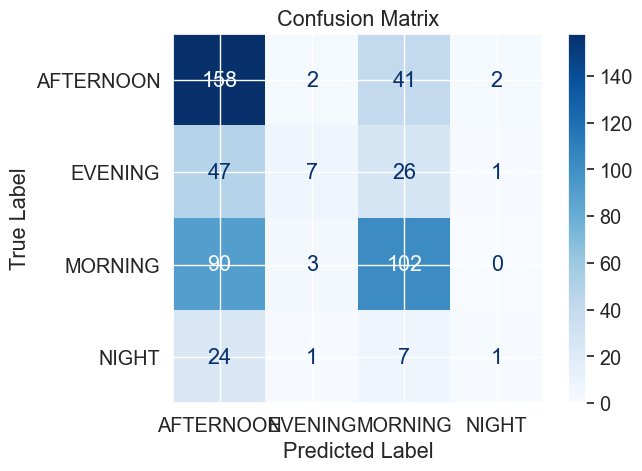

In [160]:
DF2_DAYTIME_MAX_ACCURACY_KNN = max(DF2_DAYTIME_ACCURACY_KNN_DICT.values())
DF2_DAYTIME_MAX_ACCURACY_nNeighbours_KNN = max(DF2_DAYTIME_ACCURACY_KNN_DICT, key=DF2_DAYTIME_ACCURACY_KNN_DICT.get)
print(f"The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of {DF2_DAYTIME_MAX_ACCURACY_KNN} is {DF2_DAYTIME_MAX_ACCURACY_nNeighbours_KNN}. Therefore, the selected model is the corresponding model of that accuracy.\n The model can be accessed from:")
DF2_DAYTIME_MODEL_KNN = DF2_DAYTIME_MODEL_KNN_DICT[DF2_DAYTIME_MAX_ACCURACY_nNeighbours_KNN]
DF2_DAYTIME_Ytest_pred = DF2_DAYTIME_Ytest_pred_KNN_DICT[DF2_DAYTIME_MAX_ACCURACY_nNeighbours_KNN]
DF2_DAYTIME_ACCURACY = DF2_DAYTIME_ACCURACY_KNN_DICT[DF2_DAYTIME_MAX_ACCURACY_nNeighbours_KNN]

plottingConfusionMatrix(DF2_DAYTIME_MODEL_KNN, DF2_DAYTIME_Xtest, DF2_DAYTIME_Ytest)

# Save the model to disk
DF2_DAYTIME_MODEL_KNN_filename = 'model/DF2_DAYTIME_MODEL_KNN.sav'
#joblib.dump(DF2_DAYTIME_MODEL_KNN, DF2_DAYTIME_MODEL_KNN_filename)

`OVERALL FOR DATASET DF2, PERFORMANCE OF KNN CLASSIFICATION FOR DAYTIME PREDICTION IS SIMILAR COMPARED TO THE DATASET DF1.`

c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 66.6%


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


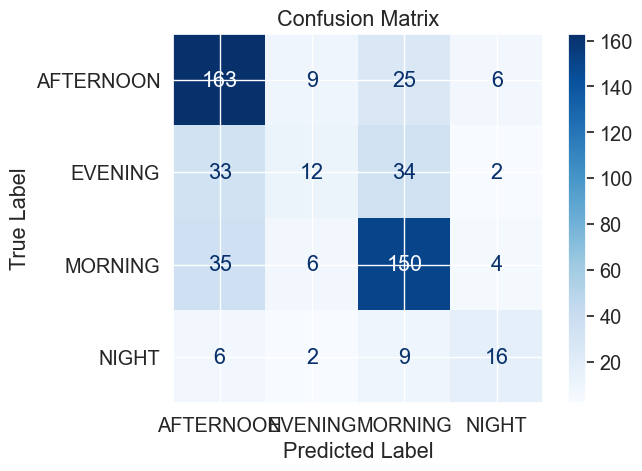

['model/DF2_DAYTIME_MODEL_LOG.sav']

In [161]:
### Logistic regression
DF2_DAYTIME_MODEL_LOG, DF2_DAYTIME_Ytest_pred_LOG, DF2_DAYTIME_ACCURACY_LOG = LogisticRegress_Multiclass(DF2_DAYTIME_Xtrain, DF2_DAYTIME_Xtest, DF2_DAYTIME_Ytrain, DF2_DAYTIME_Ytest)
plottingConfusionMatrix(DF2_DAYTIME_MODEL_LOG, DF2_DAYTIME_Xtest, DF2_DAYTIME_Ytest)

# Save the model to disk
DF2_DAYTIME_MODEL_LOG_filename = 'model/DF2_DAYTIME_MODEL_LOG.sav'
joblib.dump(DF2_DAYTIME_MODEL_LOG, DF2_DAYTIME_MODEL_LOG_filename)

`OVERALL FOR DATASET DF2, PERFORMANCE OF LOGISTIC REGRESSION FOR DAYTIME PREDICTION IS SIMILAR COMPARED TO THE DATASET DF1.`

Accuracy: 56.64%


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


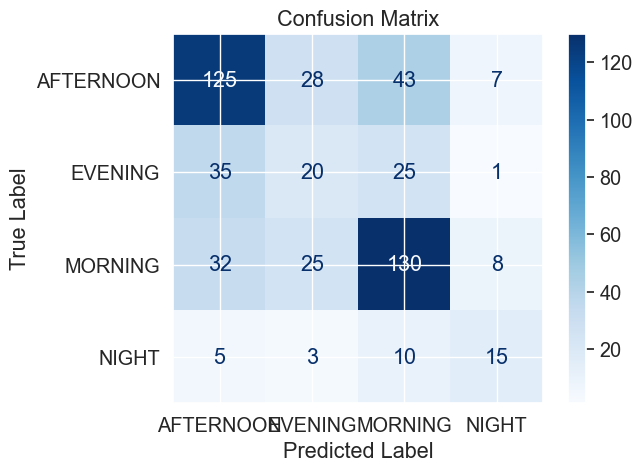

['model/DF2_DAYTIME_MODEL_TREE.sav']

In [162]:
### Decision Tree Classification
DF2_DAYTIME_MODEL_TREE, DF2_DAYTIME_Ytest_pred_TREE, DF2_DAYTIME_ACCURACY_TREE = DecisionTreeClassify(DF2_DAYTIME_Xtrain, DF2_DAYTIME_Xtest, DF2_DAYTIME_Ytrain, DF2_DAYTIME_Ytest)
plottingConfusionMatrix(DF2_DAYTIME_MODEL_TREE, DF2_DAYTIME_Xtest, DF2_DAYTIME_Ytest)

# Save the model to disk
DF2_DAYTIME_MODEL_TREE_filename = 'model/DF2_DAYTIME_MODEL_TREE.sav'
joblib.dump(DF2_DAYTIME_MODEL_TREE, DF2_DAYTIME_MODEL_TREE_filename)

`OVERALL FOR DATASET DF2, PERFORMANCE OF DECISION TREE CLASSIFICATION FOR DAYTIME PREDICTION IS SIMILAR COMPARED TO THE DATASET DF1.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 2:</b> Model 3 - Huber Regression for hour prediction
</div>

In [163]:
### start time Hour prediction
DF2_HOUR_MODEL, DF2_HOUR_Ytest_pred, DF2_HOUR_MEANERROR = HuberRegress(DF2_HOUR_Xtrain, DF2_HOUR_Xtest, DF2_HOUR_Ytrain, DF2_HOUR_Ytest)

# Save the model to disk
DF2_HOUR_MODEL_filename = 'model/DF2_HOUR_MODEL.sav'
joblib.dump(DF2_HOUR_MODEL, DF2_HOUR_MODEL_filename)

mean_absolute_error is 3.1299455997774794
mean_squared_error is 16.787561005578745


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Actual  Predicted
0        14  12.024390
1         6   8.893565
2         7   9.892723
3        15  15.371398
4        15   7.186986
..      ...        ...
507       9  15.981013
508      13  15.016312
509       6   8.999826
510       8   9.378189
511       3   3.128063

[512 rows x 2 columns]

['model/DF2_HOUR_MODEL.sav']

`OVERALL FOR DATASET DF2, PERFORMANCE OF HUBER REGRESSION FOR START TIME HOUR OF NEXT EVENT PREDICTION IS SIMILAR COMPARED TO THE DATASET DF1.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 2:</b> Model 4 - Huber Regression for duration prediction
</div>

In [164]:
DF2_DUR_MODEL, DF2_DUR_Ytest_pred, DF2_DUR_MEANERROR = HuberRegress(DF2_DUR_Xtrain, DF2_DUR_Xtest, DF2_DUR_Ytrain, DF2_DUR_Ytest)

# Save the model to disk
DF2_DUR_MODEL_filename = 'model/DF2_DUR_MODEL.sav'
joblib.dump(DF2_DUR_MODEL, DF2_DUR_MODEL_filename)

mean_absolute_error is 716.196275698845
mean_squared_error is 862610.7107619715


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Actual    Predicted
0      3721  2245.606607
1      1674  1846.498485
2      3314  2271.598033
3      2381  2148.410489
4      3600  1869.146227
..      ...          ...
507    1903  2421.571726
508    2580  2049.943912
509    1656  1408.082212
510    1748  1673.009189
511    2292  1379.153032

[512 rows x 2 columns]

['model/DF2_DUR_MODEL.sav']

`OVERALL FOR DATASET DF2, PERFORMANCE OF HUBER REGRESSION FOR DURATION PREDICTION IS SIMILAR TO THE DATASET DF1.`

`THEREFORE, DUE TO THE FACT THAT DF2 BRINGS SIMILAR RESULTS COMPARED TO THE DF1 AND THE DATASET DF2 IS MUCH SMALLER THAN DF1, ALTERNATIVE 2 IS GIVING ONE VOTE. WE WILL ANALYSE THE DATASET DF3 AND DF4 WITH KNN CLASSIFICATION FOR SPORT PREDICTION, LOGISTIC REGRESSION FOR DAYTIME PREDICTION AND HUBER REGRESSION FOR HOUR AND DURATION PREDICTION.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 3:</b> Model 1 - KNN Classification for sport prediction ############### UNCOMMENT THE BELOW CODE SNIPPET TO RUN ALTERNATIVE 3 ###################
</div>

In [165]:
### Dataset DF3_SPORT_X
# DF3_SPORT_MODEL_DICT, DF3_SPORT_Ytest_pred_DICT, DF3_SPORT_ACCURACY_DICT = KNNClassify(DF3_SPORT_Xtrain, DF3_SPORT_Xtest, DF3_SPORT_Ytrain, DF3_SPORT_Ytest, nNeighboursTuning)

# DF3_SPORT_MAX_ACCURACY = max(DF3_SPORT_ACCURACY_DICT.values())
# DF3_SPORT_MAX_ACCURACY_nNeighbours = max(DF3_SPORT_ACCURACY_DICT, key=DF3_SPORT_ACCURACY_DICT.get)
# print(f"The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of {DF3_SPORT_MAX_ACCURACY} is {DF3_SPORT_MAX_ACCURACY_nNeighbours}. Therefore, the selected model is the corresponding model of that accuracy.\n The model can be accessed from:")
# DF3_SPORT_MODEL = DF3_SPORT_MODEL_DICT[DF3_SPORT_MAX_ACCURACY_nNeighbours]
# DF3_SPORT_Ytest_pred = DF3_SPORT_Ytest_pred_DICT[DF3_SPORT_MAX_ACCURACY_nNeighbours]
# DF3_SPORT_ACCURACY = DF3_SPORT_ACCURACY_DICT[DF3_SPORT_MAX_ACCURACY_nNeighbours]

# plottingConfusionMatrix(DF3_SPORT_MODEL, DF3_SPORT_Xtest, DF3_SPORT_Ytest)

# Save the model to disk
# DF3_SPORT_MODEL_filename = 'model/DF3_SPORT_MODEL.sav'
#joblib.dump(DF3_SPORT_MODEL, DF3_SPORT_MODEL_filename)

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 3:</b> Model 2 - Logistic Regression for daytime prediction ############### UNCOMMENT THE BELOW CODE SNIPPET TO RUN ALTERNATIVE 3 ###################
</div>

In [166]:
### Logistic regression
# DF3_DAYTIME_MODEL_LOG, DF3_DAYTIME_Ytest_pred_LOG, DF3_DAYTIME_ACCURACY_LOG = LogisticRegress_Multiclass(DF3_DAYTIME_Xtrain, DF3_DAYTIME_Xtest, DF3_DAYTIME_Ytrain, DF3_DAYTIME_Ytest)
# plottingConfusionMatrix(DF3_DAYTIME_MODEL_LOG, DF3_DAYTIME_Xtest, DF3_DAYTIME_Ytest)

# Save the model to disk
# DF3_DAYTIME_MODEL_LOG_filename = 'model/DF3_TIME_MODEL_LOG.sav'
# joblib.dump(DF3_DAYTIME_MODEL_LOG, DF3_DAYTIME_MODEL_LOG_filename)

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 3:</b> Model 3 - Huber Regression for hour prediction ############### UNCOMMENT THE BELOW CODE SNIPPET TO RUN ALTERNATIVE 3 ###################
</div>

In [167]:
### start time Hour prediction
# DF3_HOUR_MODEL, DF3_HOUR_Ytest_pred, DF3_HOUR_MEANERROR = HuberRegress(DF3_HOUR_Xtrain, DF3_HOUR_Xtest, DF3_HOUR_Ytrain, DF3_HOUR_Ytest)

# Save the model to disk
# DF3_HOUR_MODEL_filename = 'model/DF3_HOUR_MODEL.sav'
# joblib.dump(DF3_HOUR_MODEL, DF3_HOUR_MODEL_filename)

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 3:</b> Model 4 - Huber Regression for duration prediction ############### UNCOMMENT THE BELOW CODE SNIPPET TO RUN ALTERNATIVE 3 ###################
</div>

In [168]:
# DF3_DUR_MODEL, DF3_DUR_Ytest_pred, DF3_DUR_MEANERROR = HuberRegress(DF3_DUR_Xtrain, DF3_DUR_Xtest, DF3_DUR_Ytrain, DF3_DUR_Ytest)

# Save the model to disk
# DF3_DUR_MODEL_filename = 'model/DF3_DUR_MODEL.sav'
# joblib.dump(DF3_DUR_MODEL, DF3_DUR_MODEL_filename)

`DUE TO THE FACT THE ALTERNATIVE 3'S DATASETS ARE MUCH BIGGER THAN THE PROCESSING CAPACITY OF OUR COMPUTERS, WE CANNOT PROVIDE PREDICTION RESULTS OF THE ALTERNATIVE 3.`

`THEREFORE, DF2 IS STILL THE WINNER SO FAR.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 4:</b> Model 1 - KNN Classification for sport prediction
</div>

The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of 79.1015625 is 10. Therefore, the selected model is the corresponding model of that accuracy.


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


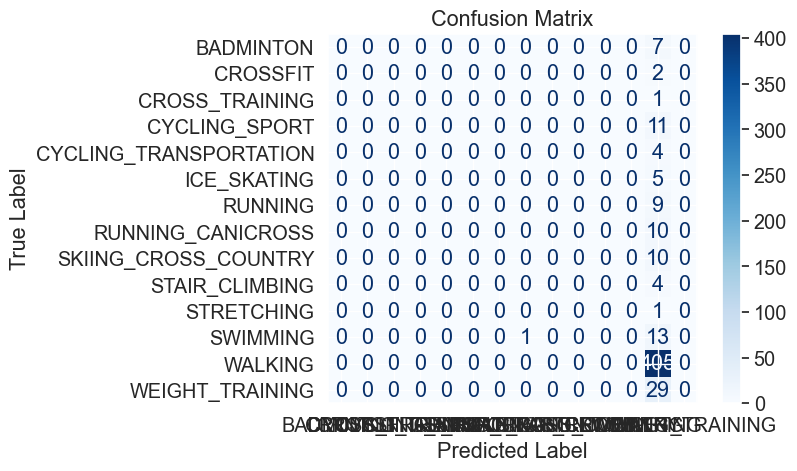

['model/DF4_SPORT_MODEL_KNN.sav']

In [169]:
### Dataset DF1_SPORT_X
nNeighboursTuning = list(range(7, 50))
DF4_SPORT_MODEL_DICT, DF4_SPORT_Ytest_pred_DICT, DF4_SPORT_ACCURACY_DICT = KNNClassify(DF4_SPORT_Xtrain, DF4_SPORT_Xtest, DF4_SPORT_Ytrain, DF4_SPORT_Ytest, nNeighboursTuning)

### KNN Classification
DF4_SPORT_MAX_ACCURACY = max(DF4_SPORT_ACCURACY_DICT.values())
DF4_SPORT_MAX_ACCURACY_nNeighbours = max(DF4_SPORT_ACCURACY_DICT, key=DF4_SPORT_ACCURACY_DICT.get)
print(f"The number of neighbours, which is within the defined tuning parameters, generating the maximum accuracy of {DF4_SPORT_MAX_ACCURACY} is {DF4_SPORT_MAX_ACCURACY_nNeighbours}. Therefore, the selected model is the corresponding model of that accuracy.")
DF4_SPORT_MODEL_KNN = DF4_SPORT_MODEL_DICT[DF4_SPORT_MAX_ACCURACY_nNeighbours]
DF4_SPORT_Ytest_pred_KNN = DF4_SPORT_Ytest_pred_DICT[DF4_SPORT_MAX_ACCURACY_nNeighbours]
DF4_SPORT_ACCURACY_KNN = DF4_SPORT_ACCURACY_DICT[DF4_SPORT_MAX_ACCURACY_nNeighbours]

plottingConfusionMatrix(DF4_SPORT_MODEL_KNN, DF4_SPORT_Xtest, DF4_SPORT_Ytest)

# Save the model to disk
DF4_SPORT_MODEL_KNN_filename = 'model/DF4_SPORT_MODEL_KNN.sav'
joblib.dump(DF4_SPORT_MODEL_KNN, DF4_SPORT_MODEL_KNN_filename)

`OVERALL FOR DATASET DF4, PERFORMANCE OF KNN CLASSIFICATION FOR SPORT PREDICTION HAS NO IMPROVEMENT COMPARED TO THE DATASET DF2.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 4:</b> Model 2 - Logistic Regression for daytime prediction
</div>

c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 66.99%


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


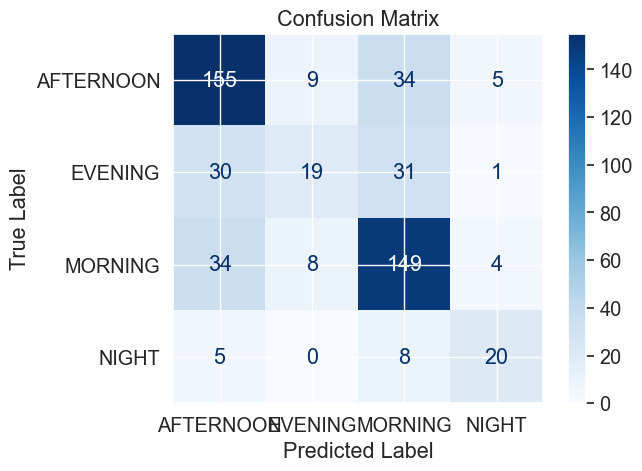

['model/DF4_TIME_MODEL_LOG.sav']

In [170]:
### Logistic regression
DF4_DAYTIME_MODEL_LOG, DF4_DAYTIME_Ytest_pred_LOG, DF4_DAYTIME_ACCURACY_LOG = LogisticRegress_Multiclass(DF4_DAYTIME_Xtrain, DF4_DAYTIME_Xtest, DF4_DAYTIME_Ytrain, DF4_DAYTIME_Ytest)
plottingConfusionMatrix(DF4_DAYTIME_MODEL_LOG, DF4_DAYTIME_Xtest, DF4_DAYTIME_Ytest)

# Save the model to disk
DF4_DAYTIME_MODEL_LOG_filename = 'model/DF4_TIME_MODEL_LOG.sav'
joblib.dump(DF4_DAYTIME_MODEL_LOG, DF4_DAYTIME_MODEL_LOG_filename)

`OVERALL FOR DATASET DF4, PERFORMANCE OF LOGISTIC REGRESSION FOR DAYTIME PREDICTION HAS NO IMPROVEMENT COMPARED TO THE DATASET DF2.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 4:</b> Model 3 - Huber Regression for hour prediction
</div>

In [171]:
### start time Hour prediction
DF4_HOUR_MODEL, DF4_HOUR_Ytest_pred, DF4_HOUR_MEANERROR = HuberRegress(DF4_HOUR_Xtrain, DF4_HOUR_Xtest, DF4_HOUR_Ytrain, DF4_HOUR_Ytest)

# Save the model to disk
DF4_HOUR_MODEL_filename = 'model/DF4_HOUR_MODEL.sav'
joblib.dump(DF4_HOUR_MODEL, DF4_HOUR_MODEL_filename)

mean_absolute_error is 3.161657131224116
mean_squared_error is 17.128112545955318


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Actual  Predicted
0        14  13.742554
1         6   7.733531
2         7  10.750740
3        15  17.786634
4        15   6.182355
..      ...        ...
507       9  15.445114
508      13  15.560209
509       6   9.430115
510       8   9.910710
511       3   4.231782

[512 rows x 2 columns]

['model/DF4_HOUR_MODEL.sav']

`OVERALL FOR DATASET DF4, PERFORMANCE OF HUBER REGRESSION FOR HOUR PREDICTION HAS NO IMPROVEMENT COMPARED TO THE DATASET DF2.`

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Alternative 4:</b> Model 4 - Huber Regression for duration prediction
</div>

In [172]:
DF4_DUR_MODEL, DF4_DUR_Ytest_pred, DF4_DUR_MEANERROR = HuberRegress(DF4_DUR_Xtrain, DF4_DUR_Xtest, DF4_DUR_Ytrain, DF4_DUR_Ytest)

# Save the model to disk
DF4_DUR_MODEL_filename = 'model/DF4_DUR_MODEL.sav'
joblib.dump(DF4_DUR_MODEL, DF4_DUR_MODEL_filename)

mean_absolute_error is 706.1852455458711
mean_squared_error is 840530.3486660721


c:\Users\thanh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Actual    Predicted
0      3721  2764.627201
1      1674  1606.683557
2      3314  2303.541632
3      2381  2366.701348
4      3600  1587.220921
..      ...          ...
507    1903  2345.746920
508    2580  2397.872128
509    1656  1824.021045
510    1748  2215.204259
511    2292  1955.002755

[512 rows x 2 columns]

['model/DF4_DUR_MODEL.sav']

`OVERALL FOR DATASET DF4, PERFORMANCE OF HUBER REGRESSION FOR DURATION PREDICTION HAS INCONSIDERABLY LITTE IMPROVEMENT COMPARED TO THE DATASET DF2. DUE TO THE SIGNIFICANT INCREASE OF COMPLEXITY OF THE DATASET AND ADDITIONAL FEATURE ENGINEERING STEPS REQUIRED, THE IMPROVEMENT IS CONSIDERED NOT WORTHY. THEREFORE, DF2'S MODELS STILL WIN.`

`THEREFORE, WE CAN CONCLUDE THAT DATA PRETREATMENT AND FEATURE ENGINEERING FOR THE DATASET DF2 ARE GOOD ENOUGH TO GENERATE PREDICTIVE MODELS WHICH ARE CHOSEN TO BE OUR FINAL MODELS`

In [173]:
FINAL_SPORT_PREDICTION_MODEL = DF2_SPORT_MODEL_KNN
FINAL_DAYTIME_PREDICTION_MODEL = DF2_DAYTIME_MODEL_LOG
FINAL_HOUR_PREDICTION_MODEL = DF2_HOUR_MODEL
FINAL_DURATION_PREDICTION_MODEL = DF2_DUR_MODEL

print(f"The final SPORT prediction model is stored in {DF2_SPORT_MODEL_KNN_filename}")
print(f"The final DAYTIME prediction model is stored in {DF2_DAYTIME_MODEL_LOG_filename}")
print(f"The final HOUR prediction model is stored in {DF2_HOUR_MODEL_filename}")
print(f"The final DURATION prediction model is stored in {DF2_DUR_MODEL_filename}")

The final SPORT prediction model is stored in model/DF2_SPORT_MODEL_KNN.sav
The final DAYTIME prediction model is stored in model/DF2_DAYTIME_MODEL_LOG.sav
The final HOUR prediction model is stored in model/DF2_HOUR_MODEL.sav
The final DURATION prediction model is stored in model/DF2_DUR_MODEL.sav


## MODELLING GOAL ACHIEVED

This below code snippet defines a function `predictNextEvent` which performs as a predictive model pipeline to predict the EXERCISE TYPE, DAYTIME, HOUR and DURATION of the NEXT EVENT using 16 consecutive past events' data.

At the end of the code snippet, we test the pipeline with 16 first JSON files that we have.

In [174]:
def min_max_normalize_with_min_max_values(df, min_max_values_df, reallocate = True):
    Cols = df.columns.to_list()

    numeric_types = ["float", "float64", "int", "int64", "uint8"]
    Cols_Idx = df.shape[1]
    skipped_cols = []
    normalized_cols = []

    for c in range(Cols_Idx):
        if df.iloc[:,c].dtype in numeric_types:
            # Get min and max values
            col_name = Cols[c]
            rowIdx = min_max_values_df.index[min_max_values_df['Columns Name'] == col_name]
            min_val = float(min_max_values_df.loc[rowIdx, 'min_values'])
            max_val = float(min_max_values_df.loc[rowIdx, 'max_values'])
            df.iloc[:,c] = (df.iloc[:,c]-min_val)/(max_val-min_val)
            normalized_cols.append(c)

        else:
            skipped_cols.append(c)

    if reallocate:
        df = df.iloc[:, skipped_cols + normalized_cols]

    return df

def predictNextEvent(jsonFileList):
    """
    This function is used to predict the next event based on 16 past events which should be given as a list of JSON file name
    
    params jsonFilelist: list of str, list of file names
    return DF_SPORT_Y_pred: str, predicted SPORT
           DF_SPORT_Y: str, actual SPORT
           DF_DAYTIME_Y_pred: str, predicted DAYTIME
           DF_DAYTIME_Y: str, actual DAYTIME
           DF_HOUR_Y_pred: float, predicted HOUR
           DF_HOUR_Y: float, actual HOUR
           DF_DUR_Y_pred: float, predicted DURATION
           DF_DUR_Y: float, actual DURATION
    """
    # Initialize return values
    DF_SPORT_Y_pred, DF_SPORT_Y, DF_DAYTIME_Y_pred, DF_DAYTIME_Y, DF_HOUR_Y_pred, DF_HOUR_Y, DF_DUR_Y_pred, DF_DUR_Y = None, None, None, None, None, None, None, None
    # Load JSON data files from data folder
    df_res = pd.DataFrame()
    
    # Read files to a common dataframe
    print("Data loading ...........................................................................")
    for filename in jsonFileList:
        print('\n'+ filename)
        df_process = read_file_to_df(folder + '/' + filename)
        df_res = pd.concat([df_res, df_process], 0)
        
    df_res.reset_index(drop=True, inplace = True)
    
    print("Data processing ...........................................................................")
    # Sort by start time
    # Convert time variable to datetime format
    df_res["start_time"] = pd.to_datetime(df_res["start_time"])

    # Sort dataset by variable "start_time" and reset index
    df_res.sort_values(by="start_time", ascending = True, inplace = True)
    df_res.reset_index(drop = True, inplace = True)
    
    # Convert object-typed variables to string
    df_res["sport"] = df_res["sport"].astype('string')
    df_res["source"] = df_res["source"].astype('string')
    
    # Removed cols
    df_res_cols = df_res.columns.to_list()
    
    excluded_cols = ["source", "created_date", "end_time", "start_lat", "start_long", "end_lat", "end_long", "speed_max_kmh", "altitude_min_m", "altitude_max_m", "ascend_m", "descend_m"]
    
    if "hydration_l" in df_res_cols:
        excluded_cols.append("hydration_l")
    
    df_res = df_res.drop(excluded_cols, axis=1)
    
    # Check NaN
    # Count NaN values of each feature
    df_res_nNaN = dict()  # Initialize list of number of NaN values in corresponding columns
    df_res_cols = list(df_res.columns)  # columns of df_res
    [df_res_nObs, df_res_nCol] = df_res.shape
    
    for col in df_res_cols:
        df_res_nNaN[col] = df_res[col].isnull().sum()
    
    if sum(df_res_nNaN.values()) > 0:
        print("Model cannot predict because of NaN existence")
    else:
        df_res, start_time_num_cols, start_time_cat_cols = extractDatetime(df_res, "start_time")
        # Extract categorical daytime from "start_time"
        df_res, start_time_daytime_catColName = getDaytimeFromHour(df_res, "start_time")
        # Extract categorical seasons from "start_time"
        df_res, start_time_season_catColName = getNorthernSeasonFromMonth(df_res, "start_time")
        start_time_cat_cols = start_time_cat_cols + [start_time_daytime_catColName, start_time_season_catColName]
        
        # Create dummy for "sport" variable
        sport_dummy_cols = ['sport_BADMINTON', 'sport_BEACH_VOLLEY', 'sport_CROSSFIT', 'sport_CROSS_TRAINING', 'sport_CYCLING_SPORT', 'sport_CYCLING_TRANSPORTATION', 'sport_FITNESS_WALKING', 'sport_ICE_SKATING', 'sport_ROLLER_SKATING', 'sport_RUNNING', 'sport_RUNNING_CANICROSS', 'sport_SKIING_CROSS_COUNTRY', 'sport_STAIR_CLIMBING', 'sport_STRETCHING', 'sport_SWIMMING', 'sport_WALKING', 'sport_WEIGHT_TRAINING']
        
        for c in sport_dummy_cols:
            df_res[c] = 0
            
        # Create dummy for "start_time_weekday_cat" variable
        start_time_weekday_dummy_cols = ['start_time_weekday_Friday', 'start_time_weekday_Monday', 'start_time_weekday_Saturday', 'start_time_weekday_Sunday', 'start_time_weekday_Thursday', 'start_time_weekday_Tuesday', 'start_time_weekday_Wednesday']
        
        for c in start_time_weekday_dummy_cols:
            df_res[c] = 0
            
        # Create dummy for "start_time_daytime_cat" variable
        start_time_daytime_dummy_cols = ['start_time_daytime_AFTERNOON', 'start_time_daytime_EVENING', 'start_time_daytime_MORNING', 'start_time_daytime_NIGHT']
        
        for c in start_time_daytime_dummy_cols:
            df_res[c] = 0
            
        # Create dummy for "start_time_season_cat" variable
        start_time_season_dummy_cols = ['start_time_season_AUTUMN', 'start_time_season_SPRING', 'start_time_season_SUMMER', 'start_time_season_WINTER']
        
        for c in start_time_season_dummy_cols:
            df_res[c] = 0
            
        ### Create dummies
        for rIdx in range(len(df_res)):
            # Fix dummy sport
            rSport = df_res.loc[rIdx, "sport"]
            df_res.loc[rIdx, f"sport_{rSport}"] = 1
            # Fix dummy weekday
            rWeekday = df_res.loc[rIdx, "start_time_weekday_cat"]
            df_res.loc[rIdx, f"start_time_weekday_{rWeekday}"] = 1
            # Fix dummy daytime
            rDaytime = df_res.loc[rIdx, "start_time_daytime_cat"]
            df_res.loc[rIdx, f"start_time_daytime_{rDaytime}"] = 1
            # Fix dummy season
            rSeason = df_res.loc[rIdx, "start_time_season_cat"]
            df_res.loc[rIdx, f"start_time_season_{rSeason}"] = 1
        
        # Normalize
        min_max_values_df = pd.read_csv('data/min_max_values.csv')
        df_norm = df_res.copy()
        df_norm = min_max_normalize_with_min_max_values(df_norm, min_max_values_df)
        
        #Remove additional cols
        additional_excluded_cols = ["start_time"] + start_time_num_cols + [start_time_season_catColName] + ["start_time_weekday_cat"]
        df_norm = df_norm.drop(additional_excluded_cols, axis=1)
        
        # Generate datasets
        SPORT_CLASS_COL = "sport"
        DAYTIME_CLASS_COL = "start_time_daytime_cat"
        HOUR_CLASS_COL = "start_time_hour_original"
        DUR_CLASS_COL = "duration_s_original"

        DF_SPORT = df_norm.drop([DAYTIME_CLASS_COL], axis=1)
        
        DF_DAYTIME = df_norm.drop([SPORT_CLASS_COL], axis=1)
        
        DF_HOUR = df_norm.drop([start_time_daytime_catColName, "sport"], axis=1)
        DF_HOUR_Cols = DF_HOUR.columns.to_list()
        DF_HOUR[HOUR_CLASS_COL] = df_res["start_time_hour"]
        DF_HOUR = DF_HOUR.loc[:, [HOUR_CLASS_COL] + DF_HOUR_Cols]
        
        DF_DUR = df_norm.drop([start_time_daytime_catColName, "sport"], axis=1)
        DF_DUR_Cols = DF_DUR.columns.to_list()
        DF_DUR[DUR_CLASS_COL] = df_res["duration_s"]
        DF_DUR = DF_DUR.loc[:, [DUR_CLASS_COL] + DF_DUR_Cols]
        
        ### Past event shifting
        
        nEvents = 15
        ### Dataset DF2_SPORT_X
        DF_SPORT_X, DF_SPORT_Y = past_time_shift(DF_SPORT, SPORT_CLASS_COL, nEvents, True)
        
        ### Dataset DF2_DAYTIME_X
        DF_DAYTIME_X, DF_DAYTIME_Y = past_time_shift(DF_DAYTIME, DAYTIME_CLASS_COL, nEvents, True)
        
        ### Dataset DF2_HOUR_X
        DF_HOUR_X, DF_HOUR_Y = past_time_shift(DF_HOUR, HOUR_CLASS_COL, nEvents, True)
        
        ### Dataset DF2_DUR_X
        DF_DUR_X, DF_DUR_Y = past_time_shift(DF_DUR, DUR_CLASS_COL, nEvents, True)
        
        ### Load trained models
        print("MODEL loading ...........................................................................")
        DF2_SPORT_MODEL_KNN_filename = "model/DF2_SPORT_MODEL_KNN.sav"
        DF2_DAYTIME_MODEL_LOG_filename = "model/DF2_DAYTIME_MODEL_LOG.sav"
        DF2_HOUR_MODEL_filename = "model/DF2_HOUR_MODEL.sav"
        DF2_DUR_MODEL_filename = "model/DF2_DUR_MODEL.sav"
        
        FINAL_SPORT_PREDICTION_MODEL = joblib.load(DF2_SPORT_MODEL_KNN_filename)
        FINAL_DAYTIME_PREDICTION_MODEL = joblib.load(DF2_DAYTIME_MODEL_LOG_filename)
        FINAL_HOUR_PREDICTION_MODEL = joblib.load(DF2_HOUR_MODEL_filename)
        FINAL_DURATION_PREDICTION_MODEL = joblib.load(DF2_DUR_MODEL_filename)
        
        ### Predict next event
        print("PREDICTING ...........................................................................")

        DF_SPORT_Y_pred = FINAL_SPORT_PREDICTION_MODEL.predict(DF_SPORT_X)
        print(f"SPORT: \n       Predicted: {DF_SPORT_Y_pred}\n       Actual: {DF_SPORT_Y}")
        
        DF_DAYTIME_Y_pred = FINAL_DAYTIME_PREDICTION_MODEL.predict(DF_DAYTIME_X)
        print(f"DAYTIME: \n       Predicted: {DF_DAYTIME_Y_pred}\n       Actual: {DF_DAYTIME_Y}")
        
        DF_HOUR_Y_pred = FINAL_HOUR_PREDICTION_MODEL.predict(DF_HOUR_X)
        print(f"HOUR: \n       Predicted: {DF_HOUR_Y_pred} (Mean error: ~3h)\n       Actual: {DF_HOUR_Y}")
        
        DF_DUR_Y_pred = FINAL_DURATION_PREDICTION_MODEL.predict(DF_DUR_X)
        print(f"DURATION: \n       Predicted: {DF_DUR_Y_pred} (Mean error: ~700s)\n       Actual: {DF_DUR_Y}")
        
        print("FINISHED!")
        
    return DF_SPORT_Y_pred, DF_SPORT_Y, DF_DAYTIME_Y_pred, DF_DAYTIME_Y, DF_HOUR_Y_pred, DF_HOUR_Y, DF_DUR_Y_pred, DF_DUR_Y

# REQUIREMENT: MINIMUM 16 PAST EVENT FILES MUST BE AVAILABLE
folder = 'WorkoutData_2017to2020'
file_list = os.listdir(folder)

# TEST PREDICTING FUNCTION
TestJsonFileList = file_list[:16]
DF_SPORT_Y_pred, DF_SPORT_Y, DF_DAYTIME_Y_pred, DF_DAYTIME_Y, DF_HOUR_Y_pred, DF_HOUR_Y, DF_DUR_Y_pred, DF_DUR_Y = predictNextEvent(TestJsonFileList)



C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\241711109.py:51: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_res = pd.concat([df_res, df_process], 0)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\241711109.py:51: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_res = pd.concat([df_res, df_process], 0)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\241711109.py:51: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_res = pd.concat([df_res, df_process], 0)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\241711109.py:51: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_res = pd.concat([df_res, df_process], 0)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\241711109.

Data loading ...........................................................................

2017-01-01 08_54_23.0.json

2017-01-01 15_02_04.0.json
No detailed data recorded

2017-01-01 17_47_03.0.json

2017-01-02 08_57_23.0.json

2017-01-02 16_20_51.0.json

2017-01-03 09_25_22.0.json

2017-01-03 17_41_24.0.json
No detailed data recorded

2017-01-03 17_54_10.0.json

2017-01-04 09_16_33.0.json

2017-01-04 09_52_22.0.json

2017-01-04 18_04_33.0.json

2017-01-04 18_05_32.0.json

2017-01-04 18_05_48.0.json
No detailed data recorded

2017-01-05 08_42_51.0.json

2017-01-05 18_06_57.0.json

2017-01-06 09_19_39.0.json
Data processing ...........................................................................


C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_X[name] = df_X[c].shift(e)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_X[name] = df_X[c].shift(e)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

MODEL loading ...........................................................................
PREDICTING ...........................................................................
SPORT: 
       Predicted: ['WALKING']
       Actual: ['WALKING']
DAYTIME: 
       Predicted: ['MORNING']
       Actual: ['MORNING']
HOUR: 
       Predicted: [7.25150958] (Mean error: ~3h)
       Actual: [8]
DURATION: 
       Predicted: [2078.71672555] (Mean error: ~700s)
       Actual: [1496]
FINISHED!


C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_X[name] = df_X[c].shift(e)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_X[name] = df_X[c].shift(e)
C:\Users\thanh\AppData\Local\Temp\ipykernel_24884\392544552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

`AS A CONCLUSION, WE PERFORMED DATA PRETREATMENT, FEATURE ENGINEERING PARAMETER TUNING AND MODEL SELECTION ON 4 ALTERNATIVES IN ORDER TO ACHIEVE THE MODELLING GOAL OF A PIPELINE PREDICTING FUTURE EVENT WITH SELECTED TRAINED MODEL.`

`WE SELECTED KNN CLASSIFICATION FOR SPORT PREDICTION WITH ~ 80% ACCURACY, LOGISTIC REGRESSION FOR DAYTIME PREDICTION WITH ~ 66.6% ACCURACY (GOOD TO PREDICT "AFTERNOON" AND "MORNING") AND HUBER REGRESSION FOR BOTH HOUR WITH MEAN ERROR OF ~ 3 HOURS AND DURATION PREDICTION WITH MEAN ERROR OF ~ 700 SECONDS.`
`DUE TO THE IMBALANCE OF OUR ORIGINAL DATASET WITH NOISES, SOME CLASSES CAN BE PREDICTED MORE ACCURATELY THAN THE OTHERS.`

